# Interface Boundary Conditions (DDM) for the dispersive part of the Serre Equation

* Definition and validation
* No advection
* Objective : application to the DDM full Serre


## Procedure
* Resolution of the dispersive part of the Serre equations in a 2 domains DDM
* Reference solution : solution computed in the mono domain
* BCs for the dispersion : 
    * interface --> TBC
    * boundary --> doesn't matter

## Resolution functions

In [1]:
%%writefile serre_DDM.py

import sys
sys.path.append('../')
sys.path.append('../nswe')

import numpy as np
import matplotlib.pyplot as plt
import serre
import cnoidal
import nswe_wbmuscl4 as wb4


nan = float("nan")

Overwriting serre_DDM.py


## FV scheme adapted to DDM
We adapt the RK4 solver for DDM because we have to manage the transfer of ghost cells for the MUSCL scheme differently

#### Boundary conditions for the advection scheme

We work here with a boundary conditions array of the form

BC = h  (boundary)
     
     hu (boundary)


In [2]:
%%writefile serre_DDM.py -a

def periodicSubDomain_1_TwoGC(h,hu,BC,dx,t):
    """
    Boundary conditions for the left subdomain, with two ghostcells on the left for periodicity.
    """
    
    hb = 1.*h
    hub = 1.*hu
    
    hb[0] = BC[0,-2]
    hub[0] = BC[1,-2]   
    hb[1] = BC[0,-1]
    hub[1] = BC[1,-1]
    
    return hb,hub

def periodicSubDomain_2_TwoGC(h,hu,BC,dx,t):
    """
    Boundary conditions for the right subdomain, with two ghostcells on the right for periodicity.
    """
    
    hb = 1.*h
    hub = 1.*hu
    
    hb[-1] = BC[0,1]
    hub[-1] = BC[1,1]   
    hb[-2] = BC[0,0]
    hub[-2] = BC[1,0]
    
    return hb,hub

def impose_periodicity_2subdom(a1,b1,a2,b2):
    """
    Impose periodicity once the solution from the advection step have been computed in each domain 
    by the MUSCL scheme.
    """
    a1b = np.copy(a1)
    b1b = np.copy(b1)
    a2b = np.copy(a2)
    b2b = np.copy(b2)
    
    a1b[:2] = a2[-4:-2]
    b1b[:2] = b2[-4:-2]
    
    a2b[-2:] = a1[2:4]
    b2b[-2:] = b1[2:4]                  
                  
    return a1b,b1b,a2b,b2b
    

Appending to serre_DDM.py


In [3]:
%%writefile serre_DDM.py -a

def extend2GhostCells(v,ng):
    """
    complete the vector of RK4 coefficients with zeros in the ghost cells 
    (to perform the sum u  + k_i)
    """
    return np.concatenate((np.zeros(ng),v,np.zeros(ng)))

def extend2GhostCells_right(v,ng):
    """
    complete the vector with ng ghost cells on the right
    (to perform the sum u  + k_i in RK4)
    """
    return np.concatenate((v,np.zeros(ng)))

def restrict2GhostCells_right(v,ng):
    """
    remove the ng ghost cells on the right
    """
    return v[:len(v)-ng]

def extend2GhostCells_left(v,ng):
    """
    complete the vector with ng ghost cells on the left
    (to perform the sum u  + k_i in RK4)
    """
    return np.concatenate((np.zeros(ng),v))

def restrict2GhostCells_left(v,ng):
    """
    remove the ng ghost cells on the left
    """
    return v[ng:]

Appending to serre_DDM.py


In [4]:
%%writefile serre_DDM.py -a

import nswe_wbmuscl4 as wb4

def fluxes_periodic(h,hu,n,periodic,ng,u_refRK=[],h_refRK=[],idx=[]):
    """
    Finite volume solver for the monodomain. For the three ghost cells necessary to the MUSCL scheme,
    we use periodic conditions. Moreover, we save values at the interface for the debugging mode of the DDM. 
    """
    
    if u_refRK == [] and h_refRK == []:
        u_refRK_save1 = np.zeros(6)
        h_refRK_save1 = np.zeros(6)
        u_refRK_save2 = np.zeros(6)
        h_refRK_save2 = np.zeros(6)
    else:
        u_refRK_save1 = []
        h_refRK_save1 = []
        u_refRK_save2 = []
        h_refRK_save2 = []
            
    ## first, we remove the ghost cells
    nx = h.shape[0]-2*ng
    ## then we add 3 cells on each side for the muscl scheme
    h0 = np.zeros(nx+6)
    u0 = np.zeros(nx+6)
    d0 = np.zeros(nx+6)
    h0[3:-3] = h[ng:len(h)-ng]
    u0[3:-3] = hu[ng:len(hu)-ng]
    u0 = np.where(h0>1e-10,u0/h0,0) #hu/h
    u = np.where(h>1e-10,hu/h,0)
    
    if periodic and idx != []:
        h0[:3] = h0[-6:-3]
        h0[-3:] = h0[3:6]
        u0[:3] = u0[-6:-3]
        u0[-3:] = u0[3:6]
        ## saving the reference
        j1 = idx[0]
        o12 = idx[1]
        ## for domain 1 (left)
        u_refRK_save1 = np.append(u0[-6:-3], u[j1+1:j1+4])
        h_refRK_save1 = np.append(h0[-6:-3], h[j1+1:j1+4])
        ## for domain 2 (right)
        u_refRK_save2 = np.append(u[o12-3:o12], u0[3:6])
        h_refRK_save2 = np.append(h[o12-3:o12], h0[3:6])
        
    elif u_refRK != [] and h_refRK != []:
        h0[:3]  = h_refRK[:3]
        h0[-3:] = h_refRK[-3:]
        u0[:3]  = u_refRK[:3]
        u0[-3:] = u_refRK[-3:]

    else:
        h0[:3]  = h0[3:6]
        h0[-3:] = h0[-6:-3]
        u0[:3]  = u0[3:6]
        u0[-3:] = u0[-6:-3]
    
    fp, fm, sc = wb4.fluxes_sources(d0,h0,u0)
    
    if periodic and idx != []:
        return fp, np.array([u_refRK_save1, u_refRK_save2]), np.array([h_refRK_save1, h_refRK_save2])
    elif u_refRK != [] and h_refRK != []:
        return fp

Appending to serre_DDM.py


In [5]:
%%writefile serre_DDM.py -a

# compute any of the RK4 coefficients (k_i)
def getRK4coef(uA,uB,f,dx,dt,nx,periodic,ng,u_refRK=[],h_refRK=[],idx=[]):
    ## monodomain case
    if u_refRK == [] and h_refRK == []:
        F, u_refRK_save, h_refRK_save = f(uA,uB,nx,periodic,ng,u_refRK,h_refRK,idx)
        return -dt/dx*(F[0,1:] - F[0,:-1]), -dt/dx*(F[1,1:] - F[1,:-1]), u_refRK_save, h_refRK_save
    ## subdomains
    else:
        F = f(uA,uB,nx,periodic,ng,u_refRK,h_refRK)
        return -dt/dx*(F[0,1:] - F[0,:-1]), -dt/dx*(F[1,1:] - F[1,:-1])

# RK4 for one time step
def RK4(uA,uB,f,bcf,bcp,dx,dt,nx,t,periodic,ng,u_refRK=[],h_refRK=[],idx=[]):
    
    #### for the small domain, we need to impose the value of the bigdomain functions 
    #### on the 6 cells used for the MUSCL scheme
    #### we are storing them in refRK_save
    u_refRK_save = np.zeros((2,4,6))
    h_refRK_save = np.zeros((2,4,6))
        
    uuA = np.copy(uA)
    uuB = np.copy(uB)
    # uuA,uuB = bcf(uuA,uuB,bcp,dx,t)
    if u_refRK == [] and h_refRK == []:
        k1A,k1B,u_refRK_save[:,0],h_refRK_save[:,0] = getRK4coef(uuA,uuB,f,dx,dt,nx,periodic,ng,idx=idx)
    else:
        k1A,k1B = getRK4coef(uuA,uuB,f,dx,dt,nx,periodic,ng,u_refRK[0],h_refRK[0])
    k1A = extend2GhostCells(k1A,ng)
    k1B = extend2GhostCells(k1B,ng)

    uuA = uA+k1A/2.
    uuB = uB+k1B/2.
    # uuA,uuB = bcf(uuA,uuB,bcp,dx,t)
    if u_refRK == [] and h_refRK == []:
        k2A,k2B,u_refRK_save[:,1],h_refRK_save[:,1] = getRK4coef(uuA,uuB,f,dx,dt,nx,periodic,ng,idx=idx)
    else:
        k2A,k2B = getRK4coef(uuA,uuB,f,dx,dt,nx,periodic,ng,u_refRK[1],h_refRK[1])
    k2A = extend2GhostCells(k2A,ng)
    k2B = extend2GhostCells(k2B,ng)

    uuA = uA+k2A/2.
    uuB = uB+k2B/2.
    # uuA,uuB = bcf(uuA,uuB,bcp,dx,t)
    if u_refRK == [] and h_refRK == []:
        k3A,k3B,u_refRK_save[:,2],h_refRK_save[:,2] = getRK4coef(uuA,uuB,f,dx,dt,nx,periodic,ng,idx=idx)
    else:
        k3A,k3B = getRK4coef(uuA,uuB,f,dx,dt,nx,periodic,ng,u_refRK[2],h_refRK[2])
    k3A = extend2GhostCells(k3A,ng)
    k3B = extend2GhostCells(k3B,ng)

    uuA = uA+k3A
    uuB = uB+k3B
    # uuA,uuB = bcf(uuA,uuB,bcp,dx,t)
    if u_refRK == [] and h_refRK == []:
        k4A,k4B,u_refRK_save[:,3],h_refRK_save[:,3] = getRK4coef(uuA,uuB,f,dx,dt,nx,periodic,ng,idx=idx)
    else:
        k4A,k4B = getRK4coef(uuA,uuB,f,dx,dt,nx,periodic,ng,u_refRK[3],h_refRK[3])
    k4A = extend2GhostCells(k4A,ng)
    k4B = extend2GhostCells(k4B,ng)

    uuA = uA + 1./6.*(k1A+2.*k2A+2.*k3A+k4A)
    uuB = uB + 1./6.*(k1B+2.*k2B+2.*k3B+k4B)
        
    return uuA, uuB, u_refRK_save, h_refRK_save

Appending to serre_DDM.py


## Dispersive scheme

#### Boundary conditions for the dispersive scheme

In [6]:
%%writefile serre_DDM.py -a

def imposeBCDispersive(M,rhs,BCs,h,u,hx,hu,dx,dt,Y=[],eta=0.,hp1=[],inter=None):
    
    """
    Impose three boundary conditions for the dispersive part
    
    - Inputs :
        * M : matrix of the FD scheme
        * rhs : right-hand side of the FD scheme
        * BCs : array of dimensions 3x3 containing one TBC in each line, in the form
            [Position,Type,Value,Opt], where
                ::: Position (int) : indicates the point to be modified (0,1,...,-2,-1)
                ::: Type (str) : indicates the type of BC : "Dirichlet"/"Neumann"/"TBC"
                ::: Value (float) : value of the BC
                ::: Opt [int,float,array] : optional coefficients for the TBC; depends on the Type 
        * h,hx,hu : informations from the last computation
        * dt
        * hp1 : h from the next iteration
        
    - Outputs :
        * M
        * rhs
    """
    gr = 9.81
    
    ### verif number of TBCs
    #if BCs.shape[0] != 3 :
    #    sys.exit("Wrong number of BCs")
        
    ## impose BCs
    for i in range(BCs.shape[0]) :
        [pos,typ,val] = BCs[i,:3]
        pos = int(pos)
        val = float(val)
        if typ == "periodic":
            M[pos,:] = 0.
            M[pos,pos] = 1.
            rhs[pos] = -(val*h[pos]-hu[pos] - dt*gr*h[pos]*hx[pos])/dt
        elif typ == "Dirichlet" :
            M[pos,:] = 0.
            M[pos,pos] = 1.
            rhs[pos] = -(val*h[pos]-hu[pos] - dt*gr*h[pos]*hx[pos])/dt
        elif typ == "Neumann" :
            M[pos,:] = 0.
            if pos == 0:
                M[0,0] = -h[1]
                M[0,1] = h[0]
                rhs[0] = h[0]*h[1]/dt*(u[1]-u[0] + dt*gr*(hx[1]-hx[0]) - val*dx)
            else:
                M[pos,pos] = h[pos-1]
                M[pos,pos-1] = -h[pos]
                rhs[pos] = h[pos]*h[pos-1]/dt*(u[pos]-u[pos-1] + dt*gr*(hx[pos]-hx[pos-1]) - val*dx)
        elif typ == "Robin" :
            alpha = float(BCs[i,3])
            beta = float(BCs[i,4])
            M[pos,:] = 0.
            if pos == 0 or pos == -2 :
                M[pos,pos] = dt*h[pos+1]*(alpha*dx - beta)
                M[pos,pos+1] = beta*dt*h[pos]
                rhs[pos] = h[pos]*h[pos+1]*(\
                                    alpha*dx*(u[pos]+dt*gr*hx[pos]) + \
                                    beta*(u[pos+1] - u[pos] + dt*gr*(hx[pos+1]-hx[pos])) - dx*val)
            elif pos == 1 or pos == -1 :
                M[pos,pos] = dt*h[pos-1]*(alpha*dx + beta)
                M[pos,pos-1] = -beta*dt*h[pos]
                rhs[pos] = h[pos]*h[pos-1]*(\
                                            alpha*dx*(u[pos]+dt*gr*hx[pos]) + \
                                            beta*(u[pos] - u[pos-1] + dt*gr*(hx[pos]-hx[pos-1])) - dx*val)
        elif typ == "TBC" or typ == "TBC2" or typ == "TBC3":  ##alpha*uxx + beta*ux + gamma*u = val 

            if typ == "TBC" :
                alpha = float(BCs[i,3])
                beta = float(BCs[i,4])
                gamma = float(BCs[i,5])
            elif typ == "TBC2" : ##with time derivative
                if pos == 0 :
                    alpha = u[0]*dt
                    beta = 1. - dt*(u[1]-u[0])/dx
                    gamma = 0.
                    val = (u[1]-u[0])/dx
                elif pos == -1 :
                    alpha = u[-1]*dt
                    beta = 1. - dt*(u[-1]-u[-2])/dx
                    gamma = 0.
                    val = (u[-1]-u[-2])/dx
            elif typ == "TBC3" : ##with time derivative : ut + u + ux + uxx= 0
                if pos == 0 :
                    alpha = dt
                    beta = dt
                    gamma = 1. + dt
                    val = u[0]
                elif pos == -1 :
                    alpha = dt
                    beta = dt
                    gamma = 1. + dt
                    val = u[-1]
            M[pos,:] = 0.
            if pos == 0:
                c0 = alpha/(dx*dx) - beta/dx + gamma
                c1 = -2.*alpha/(dx*dx) + beta/dx
                c2 = alpha/(dx*dx)
                M[0,0] = -dt/h[0]*c0
                M[0,1] = -dt/h[1]*c1
                M[0,2] = -dt/h[2]*c2
                rhs[0] =val - (u[0]+dt*gr*(hx[0]+eta))*c0 - (u[1]+dt*gr*(hx[1]+eta))*c1 - (u[2]+dt*gr*(hx[2]+eta))*c2
            elif pos == 1 :
                c0 = alpha/(dx*dx) - beta/dx
                c1 = -2.*alpha/(dx*dx) + beta/dx + gamma
                c2 = alpha/(dx*dx)
                M[1,0] = -dt/h[0]*c0
                M[1,1] = -dt/h[1]*c1
                M[1,2] = -dt/h[2]*c2
                rhs[1] =val - (u[0]+dt*gr*(hx[0]+eta))*c0 - (u[1]+dt*gr*(hx[1]+eta))*c1 - (u[2]+dt*gr*(hx[2]+eta))*c2
            elif pos == -1 :
                c0 = alpha/(dx*dx) + beta/dx + gamma
                c1 = -2.*alpha/(dx*dx) - beta/dx
                c2 = alpha/(dx*dx)
                M[pos,pos] = -dt/h[pos]*c0
                M[pos,pos-1] = -dt/h[pos-1]*c1
                M[pos,pos-2] = -dt/h[pos-2]*c2
                rhs[pos] =val - (u[pos]+dt*gr*(hx[pos]+eta))*c0 - (u[pos-1]+dt*gr*(hx[pos-1]+eta))*c1 - \
                                (u[pos-2]+dt*gr*(hx[pos-2]+eta))*c2
            elif pos == -2 :
                c0 = alpha/(dx*dx) + beta/dx
                c1 = -2.*alpha/(dx*dx) - beta/dx + gamma
                c2 = alpha/(dx*dx)
                M[pos,pos+1] = -dt/h[pos+1]*c0
                M[pos,pos] = -dt/h[pos]*c1
                M[pos,pos-1] = -dt/h[pos-1]*c2
                rhs[pos] =val - (u[pos+1]+dt*gr*(hx[pos+1]+eta))*c0 - (u[pos]+dt*gr*(hx[pos]+eta))*c1 -\
                                (u[pos-1]+dt*gr*(hx[pos-1]+eta))*c2
                            
        elif typ == "DTBC_Y":
            
            M[pos,:] = 0.
            
            if pos == 0:
                # Left TBC 1 ==> unknown = U[0]
                M[0,0]   =  1.
                M[0,1]   = -   Y[4,0]*h[0]/h[1]
                M[0,2]   =     Y[6,0]*h[0]/h[2]
                rhs[pos] = val           
            elif pos == 1:
                # Left TBC 2 ==> unknown = U[1]
                M[1,0]   =  1.
                M[1,2]   = -   Y[5,0]*h[0]/h[2]
                M[1,3]   =  2.*Y[8,0]*h[0]/h[3]
                M[1,4]   = -   Y[7,0]*h[0]/h[4]
                rhs[pos] = val
            elif pos == -1:
                ## Right TBC 1 ==> unkonwn = U[J]
                M[-1,-1] =  1.
                M[-1,-2] = -   Y[0,0]*h[-1]/h[-2]
                M[-1,-3] =     Y[2,0]*h[-1]/h[-3]
                rhs[pos] = val
            elif pos == -2:
                ## Right TBC 2 ==> unknown = U[J-1]
                M[-2,-1] =  1.
                M[-2,-2] = -2.*Y[0,0]*h[-1]/h[-2]
                M[-2,-3] =     Y[1,0]*h[-1]/h[-3]
                M[-2,-5] = -   Y[3,0]*h[-1]/h[-5]
                rhs[pos] = val
                    
        else :
            sys.exit("Wrong type of TBC!! Please use Dirichlet/Neumann/TBC")
        
    return M,rhs

Appending to serre_DDM.py


In [7]:
%%writefile serre_DDM.py -a

def EFDSolverFM4(h,u,dx,dt,order,BCs,it,periodic=False,ng=2,side="left",href=None,uref=None,Y=[],
                 domain=0,ind=0,zref=None):
    
    """
    Finite Difference Solver for the second step of the splitted Serre equations, using the discretization derived
    in the paper of Fabien Marche
    MODIFICATION : imposition of BCs
    
    - Parameters
        * h,u (1D array) : solution
        * dx,dt,t (integers) : space step, time step, time
        * BCfunction (function) : function that modifies the linear system to impose the BCs
        * BCparam (1D array) : argument for BCfunction; contains the BCs in the form
             BC=[u(left),ux(left),uxx(left),alpha1*u(left) + beta1*ux(right) + gamma1*uxx(right),
                u(right),ux(right),uxx(right),alpha2*u(right) + beta2*ux(right) + gamma2*uxx(right),
                alpha1,beta1,gamma1,alpha2,beta2,gamma2,Fleft,Fright] 
        * periodic (boolean) : indicates if the function is periodic
        * ind : index to restrain to the given subdomain
        
    - Returns
        * u2 (1D array) : solution (velocity)
    """
    
    gr = 9.81
    
    if periodic :
        for v in [u,h] :
            v = serre.imposePeriodicity(v,ng)    

    hu = h*u
        
    order = 2
    
    ux = serre.get1d(u,dx,periodic,order=order)
    uxx = serre.get2d(u,dx,periodic,order=order)
    uux = u*ux
    uuxdx = serre.get1d(uux,dx,periodic,order=order)
    hx = serre.get1d(h,dx,periodic,order=order)
    hxx = serre.get2d(h,dx,periodic,order=order)
    h2x = serre.get1d(h*h,dx,periodic,order=order)
    hhx = h*hx
    
    Q = 2.*h*hx*ux*ux + 4./3.*h*h*ux*uxx
    rhs = gr*h*hx + h*Q   
    
    if periodic :
        for v in [ux,uux,uxx,uuxdx,h2x,hx,hhx,hxx] :
            v = serre.imposePeriodicity(v,ng)  
    
    if domain == 1:
        u = u[:ind]
        ux = ux[:ind]
        uxx = uxx[:ind]
        uux = uux[:ind]
        uuxdx = uuxdx[:ind]
        h = h[:ind]        
        hx = hx[:ind]
        hxx = hxx[:ind]
        h2x = h2x[:ind]
        hhx = hhx[:ind]
        hu = h*u
        Q = Q[:ind]
        rhs = rhs[:ind]
    elif domain == 2:
        u = u[ind:]
        ux = ux[ind:]
        uxx = uxx[ind:]
        uux = uux[ind:]
        uuxdx = uuxdx[ind:]
        h = h[ind:]        
        hx = hx[ind:]
        hxx = hxx[ind:]
        h2x = h2x[ind:]
        hhx = hhx[ind:]
        hu = h*u  
        Q = Q[ind:]
        rhs = rhs[ind:]
     
    d0 = 1. + hx*hx/3. + h*hxx/3. + 5.*h*h/(6.*dx*dx)
    dp1 = -2./3.*h*hx/(3.*dx) - 4./3.*h*h/(3.*dx*dx)
    dp1 = dp1[0:-1]
    dm1 = +2./3.*h*hx/(3.*dx) - 4./3.*h*h/(3.*dx*dx)
    dm1 = dm1[1:]
    dp2 = 1./3.*h*hx/(12.*dx) + 1./3.*h*h/(12.*dx*dx)
    dp2 = dp2[0:-2]
    dm2 = -1./3.*h*hx/(12.*dx) + 1./3.*h*h/(12.*dx*dx)
    dm2 = dm2[2:]
                
    M = np.diag(d0) + np.diag(dp1,1) + np.diag(dm1,-1) + np.diag(dp2,2) + np.diag(dm2,-2)

    np.set_printoptions(threshold=np.nan)
    
    M,rhs = imposeBCDispersive(M,rhs,BCs,h,u,hx,hu,dx,dt,Y=Y)    
    z = np.linalg.solve(M,rhs)
    
    hu2 = hu + dt*(gr*h*hx-z)
    
    return hu2/h, z

Appending to serre_DDM.py


## Splitting scheme

In [8]:
%%writefile serre_DDM.py -a

def norm2(u, dx):
  """
  Return the l^2 norm of an numpy array.
  """
  return np.sqrt(dx*np.sum(u**2))


def splitSerreDDM(x,u,h,t0,tmax,dt,dx,nx,cond_int_1,cond_int_2,cond_bound,periodic=True,
                  uref=None,href=None,zref=None,debug_1=False,debug_2=False,Y=[],
                  ng=3,fvTimesolver=RK4,u_refRK=[],h_refRK=[]):
    """
    If the DDM is overlapping : N1+N2 >= N+2, otherwise N1+N2 = N+1.

                   0 1 2                                                    N-2 N-1=J
    Monodomain   = [ - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ]
                   0 1 2             |         N1-2 N1-1=J_1
    Left Domain  = [ - - - - - - - - - - - - - - - ]
                                     | 1 2         |                       N2-2 N2-1=J_2
    Right Domain =                   [ - - - - - - - - - - - - - - - - - - - - ]
                                     |             |
    Index on the monodomain   :     N-N2          N1-1
    Index on the left domain  :     N-N2          N1-1
    Index on the right domain :      0          N1+N2-N-1

                                    O12            J21
                                    
    Arguments:
    ----------
    - x : domain of computation
    - u,h : unknowns of the Serre equations
    - t0, tmax : starting and stopping times
    - dt, dx : time and space steps
    - nx : unknowns in the monodomain
    - cond_int_1, cond_int_2 : conditions at the interface between the two domains
    - cond_bound : conditions at the boundaries of the mono-domain
    - uref, href, zref : references values (mono-domain)
    - Y : convolution coefficients for the discrete TBC
    - debug_1, debug_2 : if True, we impose the monodomain solution on the boundaries of the subdomain i
    - ng : number of ghostcells (3 for the advection part)
    - fvTimesolver : solver for the advection part
    - u_refRK, h_refRK : references for the RK part (necessary for debug mode)
    """
    
    ## time steps
    t = t0
    it = 0     
    
    ## parameters for the DDM
    n = nx
    assert nx == len(u)
    j = n-1
    n1 = int((4./5.)*n)
    j1 = n1-1
    # minimal overlapping for our TBC : n = n1+n2-5
    n2 = n-n1+5
    # n2 = int((3./4.)*n)
    j2 = n2-1
    
    ## communication between domains
    # last node of the left domain in the right domain
    j21 = n1+n2-n-1
    # first node of the right domain in the left domain
    o12 = n-n2
    
    ## initialization of the solutions in the subdomains
    u1 = u[:n1]
    u2 = u[n-n2:]
    
    ## store solutions of all timesteps
    uall = np.copy(u)
    u1all = np.copy(u1)
    u2all = np.copy(u2)
    tall = np.ones(1)*t0
    
    ## precision
    nitermax = 10
    eps = 10**(-12)

    print "*** starting DDM resolution with {} - {} at the interface".format(cond_int_1, cond_int_2)
    print " * "
    print " *  precision = {:.3e}".format(eps)
    print " * "
    
    while abs(t-tmax) > 10**(-12):
        
        if it < 0:
            it += 1
            t  += dt
            u1 = uref[:n1,it]
            h1 = href[:n1,it]
            u2 = uref[o12:,it]
            h2 = href[o12:,it]
            u[:o12] = u1[:o12]
            u[o12:n1] = .5*(u1[o12:] + u2[:j21+1])
            u[n1:] = u2[j21+1:]
            u1all = np.column_stack((u1all,u1))
            u2all = np.column_stack((u2all,u2))
            uall = np.column_stack((uall,u))
            tall = np.hstack((tall,t*np.ones(1)))
            continue
            
                       
        ## starting from the referential solution to have only the DDM error
        ## and not the error from the numerical scheme
        ## (we are interested in the error with respect to the monodomain solution, not to the exact solution)
        u1 = uref[:n1,it]
        h1 = href[:n1,it]
        h1u1 = h1*u1
        u2 = uref[o12:,it]
        h2 = href[o12:,it]
        h2u2 = h2*u2
                
        ## order of the dispersive solver
        FDorder = 4 
        
        ## starting the Schwarz algorithm
        cvg = False
        niter = 0
        ## for the z part of the dispersion 
        ## (it is the variable that is going to vary during the DDM, cf. reports from Joao)
        z1 = np.zeros_like(u1)
        z2 = np.zeros_like(u2)
        
        ## monitoring error
        if abs(t - 1.) < 10**(-12):
            err_tab = []
            
        ## advection step
        ## Schwarz iterations are not required as we can handle the DDM interface communication
        ## with ghost cells with the following form
        
        #      BC =   h  (periodic boundary)
        #             hu (periodic boundary)
        
        ## we need 3 ghost cells for the MUSCL scheme of order 4 to work
                
        ## left domain
        if debug_1:
            u_refRK_it1 = u_refRK[it,0]
            h_refRK_it1 = h_refRK[it,0]
        else:
            pass
        # copies and preparation of the vectors for the FV solver
        h1_save = np.copy(h1)
        u1_save = np.copy(u1)
        h1u1_save = np.copy(h1u1)
        # useless ghost cells to match the dimensions
        h1 = extend2GhostCells_right(h1,ng)
        h1u1 = extend2GhostCells_right(h1u1,ng)
        # solve with the FV solver
        h1,h1u1,trash1,trash2 = fvTimesolver(h1,h1u1,fluxes_periodic,None,None,
                                             dx,dt,nx,t,periodic,ng=ng,u_refRK=u_refRK_it1,h_refRK=h_refRK_it1)
        # restriction to remove the ghost cells we don't need
        h1 = restrict2GhostCells_right(h1,ng)
        h1u1 = restrict2GhostCells_right(h1u1,ng)        
        
        ## right domain
        if debug_2:
            u_refRK_it2 = u_refRK[it,1]
            h_refRK_it2 = h_refRK[it,1]
        else:
            pass
        # useless ghost cells to match the dimensions
        h2 = extend2GhostCells_left(h2,ng)
        h2u2 = extend2GhostCells_left(h2u2,ng)
        # solve with the FV solver
        h2,h2u2,trash1,trash2 = fvTimesolver(h2,h2u2,fluxes_periodic,None,None,
                                             dx,dt,nx,t,periodic,ng=ng,u_refRK=u_refRK_it2,h_refRK=h_refRK_it2)
        # restriction to remove the ghost cells we don't need
        h2 = restrict2GhostCells_left(h2,ng)
        h2u2 = restrict2GhostCells_left(h2u2,ng)
        
        ## periodicity
        h1,h1u1,h2,h2u2 = impose_periodicity_2subdom(h1,h1u1,h2,h2u2)
        
        ## retrieving u
        u1 = np.where(h1[:]>1e-10, h1u1[:]/h1[:], 0.) 
        u2 = np.where(h2[:]>1e-10, h2u2[:]/h2[:], 0.) 
    
        # extending the ddm solutions only to pass it to the FD solver and avoid problems 
        # to compute the derivatives at the interfaces of the subdomains
        # u1_aux = np.append(u1,u2[j21+1:j21+4])
        # u2_aux = np.append(u1[o12-3:o12],u2)
        u[:o12] = u1[:o12]
        u[o12:n1] = .5*(u1[o12:] + u2[:j21+1])
        u[n1:] = u2[j21+1:]
        h[:o12] = h1[:o12]
        h[o12:n1] = .5*(h1[o12:] + h2[:j21+1])
        h[n1:] = h2[j21+1:]
        
        print " *  --------------------------"
        print " *  t = {:.2f}".format(t+dt)
        print " *  Advection error for h :", np.sqrt(norm2(h1-href[:n1,it+1], dx)**2 + 
                                                     norm2(h2-href[o12:,it+1], dx)**2)
                    
        ## DDM for the dispersive part
        while niter < nitermax and cvg == False:
            
            ## \Omega_1 : left --> BC, right --> IBC
            if debug_1:
                cond_int_1 = "Dirichlet"
                val11 = uref[j1,it+1]
                val12 = uref[j1-1,it+1]
            elif cond_int_1 == "Dirichlet":
                val11 = u2[j21]
                val12 = u2[j21-1]
            elif cond_int_1 == "DTBC_Y":
                val11 = z2[j21] -   Y[0,0]*(href[j1,it+1]/href[j1-1,it+1])*z2[j21-1] \
                                +   Y[2,0]*(href[j1,it+1]/href[j1-2,it+1])*z2[j21-2]
                val12 = z2[j21] - 2*Y[0,0]*(href[j1,it+1]/href[j1-1,it+1])*z2[j21-1] \
                                +   Y[1,0]*(href[j1,it+1]/href[j1-2,it+1])*z2[j21-2] \
                                -   Y[3,0]*(href[j1,it+1]/href[j1-4,it+1])*z2[j21-4]
            else:
                val11 = 0.
                val12 = 0.

            if debug_1:
                bc11 = uref[0,it+1]
                bc12 = uref[1,it+1]  
            elif periodic:
                bc11 = u2[-4]
                bc12 = u2[-3]
            else:
                bc11 = 0.
                bc12 = 0.
                
            BCconfig1 = np.array([[0,cond_bound,bc11,1.,0.,1.],
                                 [-1,cond_int_1,val11,1.,0.,1.],
                                 [1,cond_bound,bc12,1.,0.,1.],
                                 [-2,cond_int_1,val12,1.,0.,1.]], dtype=object)
            
            ## solving in the left domain
            u1_save = np.copy(u1)
            z1_save = np.copy(z1)
            u1,z1 = EFDSolverFM4(h,u,dx,dt,FDorder,BCconfig1,it,
                                 Y=Y,domain=1,ind=n1,periodic=periodic)
            assert(len(u1) == n1)
            
            ## \Omega_2 : left --> IBC, right --> BC
            if debug_2:
                cond_int_2 = "Dirichlet"
                val21 = uref[o12,it+1]
                val22 = uref[o12+1,it+1]
            elif cond_int_2 == "Dirichlet":
                val21 = u1_save[o12]
                val22 = u1_save[o12+1]
            elif cond_int_2 == "DTBC_Y":
                val21 = z1_save[o12] -   Y[4,0]*(href[o12,it+1]/href[o12+1,it+1])*z1_save[o12+1] \
                                     +   Y[6,0]*(href[o12,it+1]/href[o12+2,it+1])*z1_save[o12+2]
                val22 = z1_save[o12] -   Y[5,0]*(href[o12,it+1]/href[o12+2,it+1])*z1_save[o12+2] \
                                     + 2*Y[8,0]*(href[o12,it+1]/href[o12+3,it+1])*z1_save[o12+3] \
                                     -   Y[7,0]*(href[o12,it+1]/href[o12+4,it+1])*z1_save[o12+4]
            else:
                val21 = 0.
                val22 = 0.
                
            if debug_2:
                bc21 = uref[-1,it+1]
                bc22 = uref[-2,it+1]    
            elif periodic:
                bc21 = u1_save[3]
                bc22 = u1_save[2]
            else:
                bc21 = 0.
                bc22 = 0.
                
            BCconfig2 = np.array([[0,cond_int_2,val21,1.,0.,1.],
                                 [-1,cond_bound,bc21,1.,0.,1.],
                                 [1,cond_int_2,val22,1.,0.,1.],
                                 [-2,cond_bound,bc22,1.,0.,1.]], dtype=object)      
            
            ## solving in the right domain
            u2_save = np.copy(u2)
            z2_save = np.copy(z2)
            u2,z2 = EFDSolverFM4(h,u,dx,dt,FDorder,BCconfig2,it,
                                 Y=Y,domain=2,ind=o12,periodic=periodic)
            assert(len(u2) == n2)
            
            ## periodicity
            h1,h1u1,h2,h2u2 = impose_periodicity_2subdom(h1,h1u1,h2,h2u2)
            
            ## test convergence with reference to uref
            ## convergence in u
            err_norm_ref = np.sqrt(norm2(u1-uref[:n1,it+1], dx)**2 + norm2(u2-uref[o12:,it+1], dx)**2)
            ## convergence in z
            # err_norm_ref = np.sqrt(norm2(z1-zref[:n1,it], dx)**2 + norm2(z2-zref[o12:,it], dx)**2)
            ## convergence error instead of reference (for when we don't know the reference solution)
            err_norm_cvg = np.sqrt(norm2(u1-u1_save, dx)**2 + norm2(u2-u2_save, dx)**2)
            
            ## choose which error to consider
            err_norm = err_norm_ref
            
            ## monitoring error
            if abs(t - 1.) < 10**(-12):
                err_tab.append(err_norm)
            
            niter += 1
            
            ## if convergence
            if err_norm < eps:
                print " *  DDM cvg reached in {:4d} iterations, error = {:.3e}".format(niter, err_norm)
                print " *  left domain interface  : {:.3e}".format(np.sqrt((u1[j1]-uref[j1,it+1])**2 +
                                                                           (u1[j1-1]-uref[j1-1,it+1])**2))
                print " *  right domain interface : {:.3e}".format(np.sqrt((u2[0]-uref[o12,it+1])**2 +
                                                                           (u2[1]-uref[o12+1,it+1])**2))
                print " * "
                cvg = True
                err1 = u1-uref[:n1,it+1]
                err2 = u2-uref[o12:,it+1]
                err1 = np.append(err1,np.zeros(n-n1))
                err2 = np.append(np.zeros(n-n2),err2)
                u[:o12] = u1[:o12]
                u[o12:n1] = .5*(u1[o12:] + u2[:j21+1])
                u[n1:] = u2[j21+1:]
                        
            ## if not convergence after nitermax iterations
            if niter == nitermax:
                # print abs(u1 - uref[:n1,it+1])
                # print abs(u2 - uref[o12:,it+1])
                print " *  DDM cvg not reached after {:4d} iterations, error = {:.3e}".format(niter,err_norm)
                print " *  left domain interface  : {:.3e}".format(np.sqrt((u1[j1]-uref[j1,it+1])**2 + 
                                                                          (u1[j1-1]-uref[j1-1,it+1])**2))
                print " *  right domain interface : {:.3e}".format(np.sqrt((u2[0]-uref[o12,it+1])**2 + 
                                                                          (u2[1]-uref[o12+1,it+1])**2))

                print " * "
                err1 = u1-uref[:n1,it+1]
                err2 = u2-uref[o12:,it+1]
                err1 = np.append(err1,np.zeros(n-n1))
                err2 = np.append(np.zeros(n-n2),err2)
                u[:o12] = u1[:o12]
                u[o12:n1] = .5*(u1[o12:] + u2[:j21+1])
                u[n1:] = u2[j21+1:]
                
        ## monitoring error
        if abs(t - 1.) < 10**(-12):
            plt.plot(err_tab)
            plt.yscale('log')
            plt.savefig('error_{}-{}.pdf'.format(cond_int_1, cond_int_2))
            plt.clf()
            
        ## stacking after convergence
        try:
            z1all = np.column_stack((z1all,z1))
            z2all = np.column_stack((z2all,z2))
        except:
            z1all = z1
            z2all = z2
        u1all = np.column_stack((u1all,u1))
        u2all = np.column_stack((u2all,u2))
        uall = np.column_stack((uall,u))
        tall = np.hstack((tall,t*np.ones(1)))
        try:
            err1all = np.column_stack((err1all,err1))
            err2all = np.column_stack((err2all,err2))
        except:
            err1all = np.copy(err1)
            err2all = np.copy(err2)
        
        
        t  += dt
        it += 1
        
    print "*** DDM over"
    
    # saving interfaces for plotting
    ddm = [x[o12],x[j1]]
        
    return uall,u1all,u2all,z1all,z2all,tall,ddm,err1all,err2all

Appending to serre_DDM.py


In [9]:
%%writefile serre_DDM.py -a

def computeErrorTBC(u,uref,idxlims,dx,dt):
    lim1 = idxlims[0]
    lim2 = idxlims[1]
    uwind = uref[lim1:lim2+1,:]
    errDom = np.linalg.norm(u-uwind)*np.sqrt(dx*dt)
    errInt1 = np.linalg.norm(u[0,:]-uwind[0,:])*np.sqrt(dt)
    errInt2 = np.linalg.norm(u[-1,:]-uwind[-1,:])*np.sqrt(dt)
    
    return errDom,errInt1,errInt2
    

Appending to serre_DDM.py


## Parameters and initialization

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import serre
import cnoidal
import nswe_wbmuscl4 as wb4
import sys
import serre_DDM
import generalFunctions as gF

reload(serre)
reload(serre_DDM)
%matplotlib inline

In [11]:
a0 = 1.
a1 = .1
k = 0.
g = 9.81
t0 = 0.
tmax = 15
dt = 0.05

lam, h0 = cnoidal.WaveLengthDepth(k,a0,a1)

L = 3.*lam
xmin = -L
xmax = L
nx = 101
x,dx = serre.discretizeSpace(xmin,xmax,nx)
dx = np.diff(x)[0]

In [12]:
t = t0
tallaux = np.arange(t0,tmax+dt,dt)
h,u = cnoidal.analyticalSolutionSolitary(x,t,a0,a1)

In [13]:
# Y coefficients for the DTBC of the linearized Serre equations

import Zt_tools as Z
print h0
Nf = 10**4
ps = Z.Parameters(h0, dx, nx, xmin, xmax, dt, Nf)
# ub = np.mean(u)
# Y = Z.compute_Y2(ps, ub)
Y = Z.compute_Y3(ps)
# Y = Z.compute_Y(ps)
# Z.plot_Y(Y, Nf, log_scale = False, export = False)
# K = Z.compute_K(dx, 1)

1.1
*** Starting computations of Ys
*** Computation of Ys (in Fourier space) --> done

*** Applying iFFT on Ys
 *  max(Y1) = 0.363230321384
 *  max(Y2) = 0.363230321384
*** iFFT --> done



## Monodomain solution

In [14]:
## parameters for the DDM
n = nx
j = n-1
n1 = int((4./5.)*n)
j1 = n1-1
# minimal overlapping for our TBC : n = n1+n2-5
n2 = n-n1+5
# n2 = int((3./4.)*n)
j2 = n2-1
## communication between domains
# last node of the left domain in the right domain
j21 = n1+n2-n-1
# first node of the right domain in the left domain
o12 = n-n2

## indexes to save the reference solution at the good points for the debug mode
idx = [j1, o12]

hallref,uallref,tallref,u_refRK,h_refRK = serre.splitSerre(x,h,u,0,tmax,
                                           serre.periodicDomainTwoGC,serre.periodicDomain2TwoGC,None,None,
                                           dx,nx,vardt=False,dt=dt,
                                           splitSteps=2,order=4, 
                                           fvTimesolver=serre_DDM.RK4,fvsolver=serre_DDM.fluxes_periodic,
                                           fdsolver=serre.EFDSolverFM4,
                                           ghostcells=2,periodic=True,idx=idx)

u_refRK = np.array(u_refRK)
h_refRK = np.array(h_refRK)

CFL = 0.118698


serre_DDM.py:121: RuntimeWarning: invalid value encountered in divide
  u0 = np.where(h0>1e-10,u0/h0,0) #hu/h


## DDM

In [15]:
reload(serre_DDM)
cond_bound = "periodic"
cond_int_1 = "Dirichlet"
cond_int_2 = "Dirichlet"

ng = 2

uall,u1all,u2all,z1all,z2all,tall,ddm,err1all,err2all = serre_DDM.splitSerreDDM(x,u,h,t0,tmax,dt,dx,nx,
                                                                cond_int_1,cond_int_2,cond_bound,periodic=True,
                                                                uref=uallref,href=hallref,zref=None,
                                                                debug_1=True,debug_2=True,Y=Y,ng=ng,
                                                                fvTimesolver=serre_DDM.RK4,
                                                                u_refRK=u_refRK,h_refRK=h_refRK)

umin = np.amin(uallref)
umax = np.amax(uallref)
hmin = np.amin(hallref)
hmax = np.amax(hallref)
emin = min(np.amin(err1all),np.amin(err2all))
emax = max(np.amax(err1all),np.amax(err2all))
# print np.linalg.norm(uallref[ng:-ng]-uall[ng:-ng])

*** starting DDM resolution with Dirichlet - Dirichlet at the interface
 * 
 *  precision = 1.000e-12
 * 
 *  --------------------------
 *  t = 0.05
 *  Advection error for h : 0.0
 *  DDM cvg reached in    1 iterations, error = 3.755e-19
 *  left domain interface  : 0.000e+00
 *  right domain interface : 0.000e+00
 * 
 *  --------------------------
 *  t = 0.10
 *  Advection error for h : 0.0
 *  DDM cvg reached in    1 iterations, error = 7.337e-22
 *  left domain interface  : 0.000e+00
 *  right domain interface : 0.000e+00
 * 
 *  --------------------------
 *  t = 0.15
 *  Advection error for h : 0.0
 *  DDM cvg reached in    1 iterations, error = 8.199e-22
 *  left domain interface  : 0.000e+00
 *  right domain interface : 0.000e+00
 * 
 *  --------------------------
 *  t = 0.20
 *  Advection error for h : 0.0
 *  DDM cvg reached in    1 iterations, error = 1.432e-24
 *  left domain interface  : 0.000e+00
 *  right domain interface : 0.000e+00
 * 
 *  --------------------------

serre_DDM.py:122: RuntimeWarning: invalid value encountered in divide
  u = np.where(h>1e-10,hu/h,0)


 *  --------------------------
 *  t = 0.30
 *  Advection error for h : 0.0
 *  DDM cvg reached in    1 iterations, error = 4.201e-22
 *  left domain interface  : 0.000e+00
 *  right domain interface : 0.000e+00
 * 
 *  --------------------------
 *  t = 0.35
 *  Advection error for h : 0.0
 *  DDM cvg reached in    1 iterations, error = 1.174e-20
 *  left domain interface  : 0.000e+00
 *  right domain interface : 0.000e+00
 * 
 *  --------------------------
 *  t = 0.40
 *  Advection error for h : 0.0
 *  DDM cvg reached in    1 iterations, error = 2.403e-17
 *  left domain interface  : 0.000e+00
 *  right domain interface : 0.000e+00
 * 
 *  --------------------------
 *  t = 0.45
 *  Advection error for h : 0.0
 *  DDM cvg reached in    1 iterations, error = 2.933e-21
 *  left domain interface  : 0.000e+00
 *  right domain interface : 0.000e+00
 * 
 *  --------------------------
 *  t = 0.50
 *  Advection error for h : 0.0
 *  DDM cvg reached in    1 iterations, error = 1.659e-20
 *

 *  --------------------------
 *  t = 2.30
 *  Advection error for h : 0.0
 *  DDM cvg reached in    1 iterations, error = 4.694e-20
 *  left domain interface  : 0.000e+00
 *  right domain interface : 0.000e+00
 * 
 *  --------------------------
 *  t = 2.35
 *  Advection error for h : 0.0
 *  DDM cvg reached in    1 iterations, error = 4.694e-20
 *  left domain interface  : 0.000e+00
 *  right domain interface : 0.000e+00
 * 
 *  --------------------------
 *  t = 2.40
 *  Advection error for h : 0.0
 *  DDM cvg reached in    1 iterations, error = 9.694e-20
 *  left domain interface  : 0.000e+00
 *  right domain interface : 0.000e+00
 * 
 *  --------------------------
 *  t = 2.45
 *  Advection error for h : 0.0
 *  DDM cvg reached in    1 iterations, error = 6.008e-18
 *  left domain interface  : 0.000e+00
 *  right domain interface : 0.000e+00
 * 
 *  --------------------------
 *  t = 2.50
 *  Advection error for h : 0.0
 *  DDM cvg reached in    1 iterations, error = 5.729e-24
 *

 *  --------------------------
 *  t = 4.40
 *  Advection error for h : 0.0
 *  DDM cvg reached in    1 iterations, error = 2.347e-20
 *  left domain interface  : 0.000e+00
 *  right domain interface : 0.000e+00
 * 
 *  --------------------------
 *  t = 4.45
 *  Advection error for h : 0.0
 *  DDM cvg reached in    1 iterations, error = 0.000e+00
 *  left domain interface  : 0.000e+00
 *  right domain interface : 0.000e+00
 * 
 *  --------------------------
 *  t = 4.50
 *  Advection error for h : 0.0
 *  DDM cvg reached in    1 iterations, error = 1.344e-17
 *  left domain interface  : 0.000e+00
 *  right domain interface : 0.000e+00
 * 
 *  --------------------------
 *  t = 4.55
 *  Advection error for h : 0.0
 *  DDM cvg reached in    1 iterations, error = 8.396e-19
 *  left domain interface  : 0.000e+00
 *  right domain interface : 0.000e+00
 * 
 *  --------------------------
 *  t = 4.60
 *  Advection error for h : 0.0
 *  DDM cvg reached in    1 iterations, error = 3.004e-18
 *

 *  --------------------------
 *  t = 6.30
 *  Advection error for h : 0.0
 *  DDM cvg reached in    1 iterations, error = 3.757e-19
 *  left domain interface  : 0.000e+00
 *  right domain interface : 0.000e+00
 * 
 *  --------------------------
 *  t = 6.35
 *  Advection error for h : 0.0
 *  DDM cvg reached in    1 iterations, error = 6.008e-18
 *  left domain interface  : 0.000e+00
 *  right domain interface : 0.000e+00
 * 
 *  --------------------------
 *  t = 6.40
 *  Advection error for h : 0.0
 *  DDM cvg reached in    1 iterations, error = 3.010e-18
 *  left domain interface  : 0.000e+00
 *  right domain interface : 0.000e+00
 * 
 *  --------------------------
 *  t = 6.45
 *  Advection error for h : 0.0
 *  DDM cvg reached in    1 iterations, error = 1.690e-18
 *  left domain interface  : 0.000e+00
 *  right domain interface : 0.000e+00
 * 
 *  --------------------------
 *  t = 6.50
 *  Advection error for h : 0.0
 *  DDM cvg reached in    1 iterations, error = 3.605e-17
 *

 *  --------------------------
 *  t = 8.20
 *  Advection error for h : 0.0
 *  DDM cvg reached in    1 iterations, error = 6.193e-18
 *  left domain interface  : 0.000e+00
 *  right domain interface : 0.000e+00
 * 
 *  --------------------------
 *  t = 8.25
 *  Advection error for h : 0.0
 *  DDM cvg reached in    1 iterations, error = 3.004e-18
 *  left domain interface  : 0.000e+00
 *  right domain interface : 0.000e+00
 * 
 *  --------------------------
 *  t = 8.30
 *  Advection error for h : 0.0
 *  DDM cvg reached in    1 iterations, error = 3.792e-19
 *  left domain interface  : 0.000e+00
 *  right domain interface : 0.000e+00
 * 
 *  --------------------------
 *  t = 8.35
 *  Advection error for h : 0.0
 *  DDM cvg reached in    1 iterations, error = 2.348e-20
 *  left domain interface  : 0.000e+00
 *  right domain interface : 0.000e+00
 * 
 *  --------------------------
 *  t = 8.40
 *  Advection error for h : 0.0
 *  DDM cvg reached in    1 iterations, error = 1.760e-20
 *

 *  --------------------------
 *  t = 10.15
 *  Advection error for h : 0.0
 *  DDM cvg reached in    1 iterations, error = 3.413e-17
 *  left domain interface  : 0.000e+00
 *  right domain interface : 0.000e+00
 * 
 *  --------------------------
 *  t = 10.20
 *  Advection error for h : 0.0
 *  DDM cvg reached in    1 iterations, error = 3.004e-18
 *  left domain interface  : 0.000e+00
 *  right domain interface : 0.000e+00
 * 
 *  --------------------------
 *  t = 10.25
 *  Advection error for h : 0.0
 *  DDM cvg reached in    1 iterations, error = 8.603e-19
 *  left domain interface  : 0.000e+00
 *  right domain interface : 0.000e+00
 * 
 *  --------------------------
 *  t = 10.30
 *  Advection error for h : 0.0
 *  DDM cvg reached in    1 iterations, error = 7.741e-19
 *  left domain interface  : 0.000e+00
 *  right domain interface : 0.000e+00
 * 
 *  --------------------------
 *  t = 10.35
 *  Advection error for h : 0.0
 *  DDM cvg reached in    1 iterations, error = 1.502e-

 *  --------------------------
 *  t = 12.10
 *  Advection error for h : 0.0
 *  DDM cvg reached in    1 iterations, error = 3.010e-18
 *  left domain interface  : 1.527e-21
 *  right domain interface : 0.000e+00
 * 
 *  --------------------------
 *  t = 12.15
 *  Advection error for h : 0.0
 *  DDM cvg reached in    1 iterations, error = 1.232e-20
 *  left domain interface  : 0.000e+00
 *  right domain interface : 0.000e+00
 * 
 *  --------------------------
 *  t = 12.20
 *  Advection error for h : 0.0
 *  DDM cvg reached in    1 iterations, error = 1.239e-17
 *  left domain interface  : 8.470e-22
 *  right domain interface : 0.000e+00
 * 
 *  --------------------------
 *  t = 12.25
 *  Advection error for h : 0.0
 *  DDM cvg reached in    1 iterations, error = 2.403e-17
 *  left domain interface  : 0.000e+00
 *  right domain interface : 0.000e+00
 * 
 *  --------------------------
 *  t = 12.30
 *  Advection error for h : 0.0
 *  DDM cvg reached in    1 iterations, error = 1.202e-

 *  --------------------------
 *  t = 14.00
 *  Advection error for h : 0.0
 *  DDM cvg reached in    1 iterations, error = 1.202e-17
 *  left domain interface  : 0.000e+00
 *  right domain interface : 0.000e+00
 * 
 *  --------------------------
 *  t = 14.05
 *  Advection error for h : 0.0
 *  DDM cvg reached in    1 iterations, error = 1.514e-18
 *  left domain interface  : 0.000e+00
 *  right domain interface : 0.000e+00
 * 
 *  --------------------------
 *  t = 14.10
 *  Advection error for h : 0.0
 *  DDM cvg reached in    1 iterations, error = 0.000e+00
 *  left domain interface  : 0.000e+00
 *  right domain interface : 0.000e+00
 * 
 *  --------------------------
 *  t = 14.15
 *  Advection error for h : 0.0
 *  DDM cvg reached in    1 iterations, error = 4.807e-17
 *  left domain interface  : 0.000e+00
 *  right domain interface : 0.000e+00
 * 
 *  --------------------------
 *  t = 14.20
 *  Advection error for h : 0.0
 *  DDM cvg reached in    1 iterations, error = 2.478e-

<Figure size 432x288 with 0 Axes>

*** Plotting animation ...



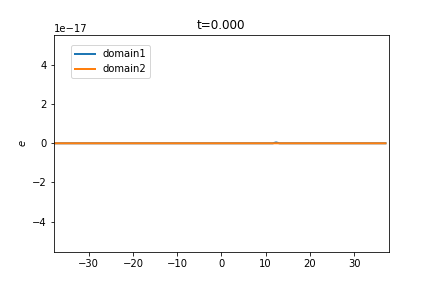
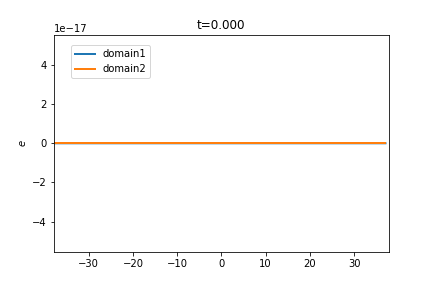
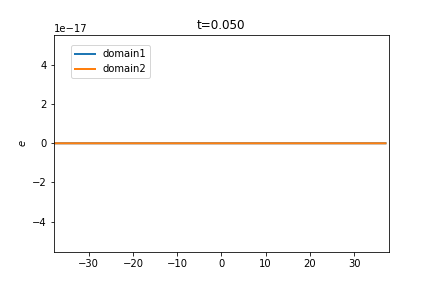
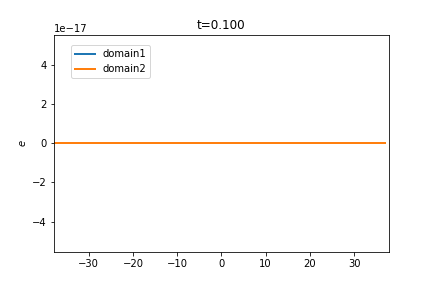
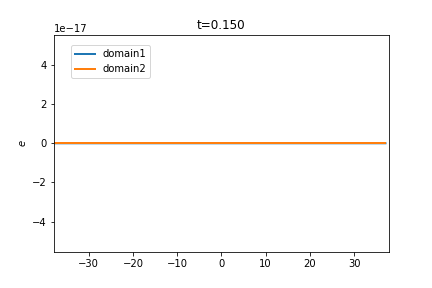
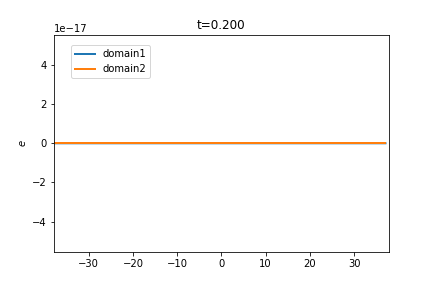
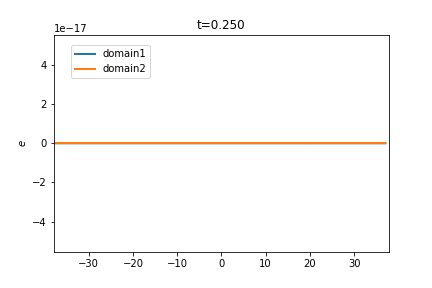
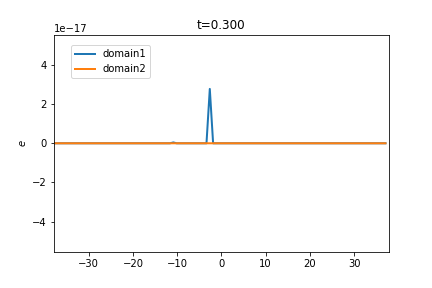
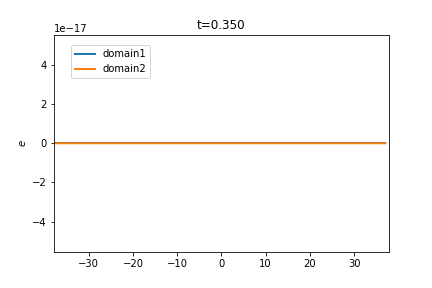
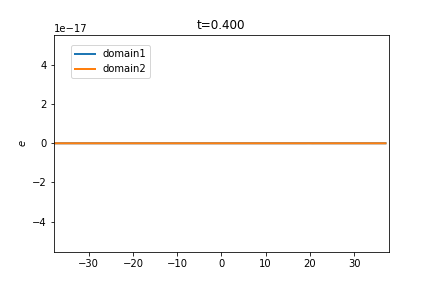
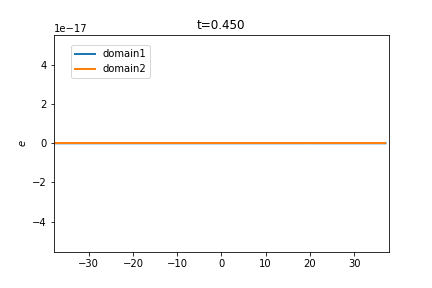
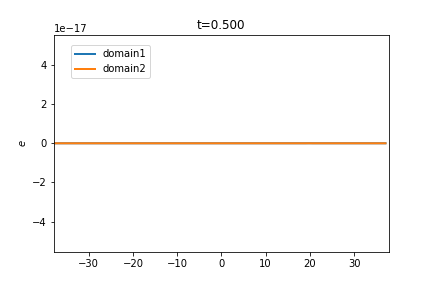
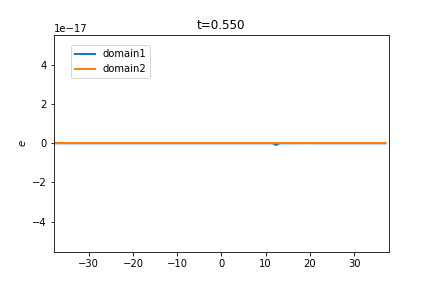
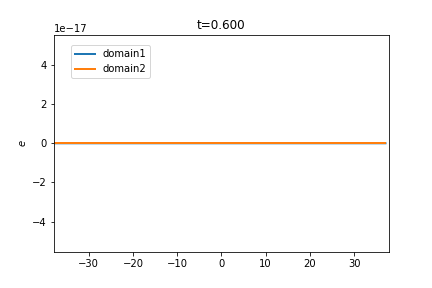
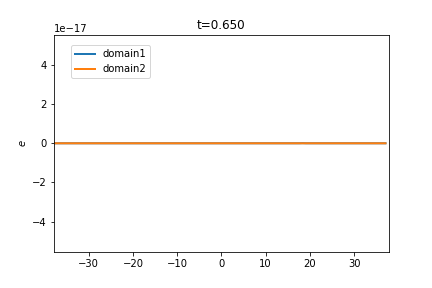
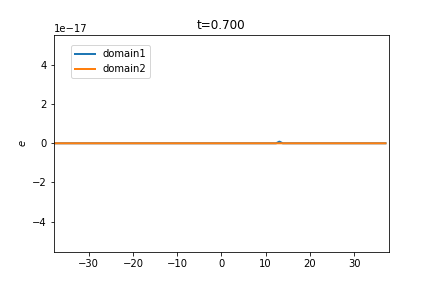
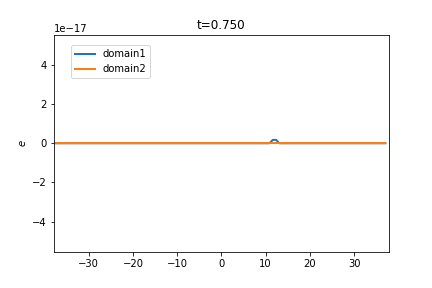
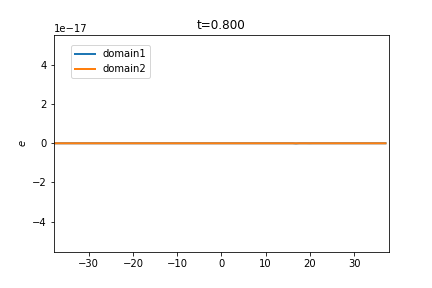
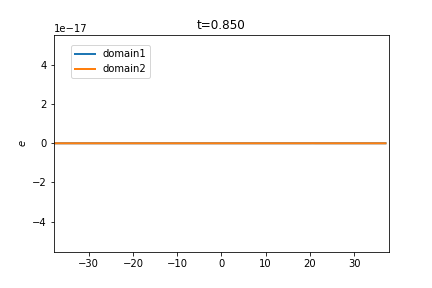
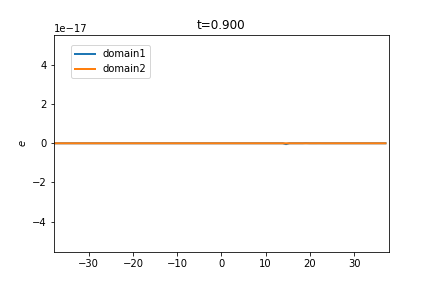
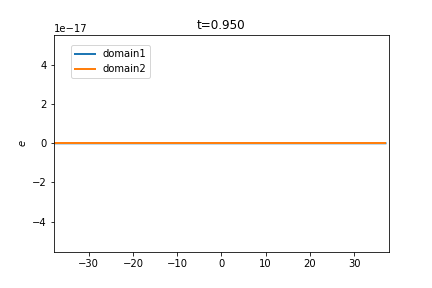
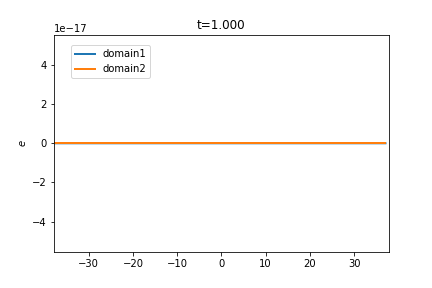
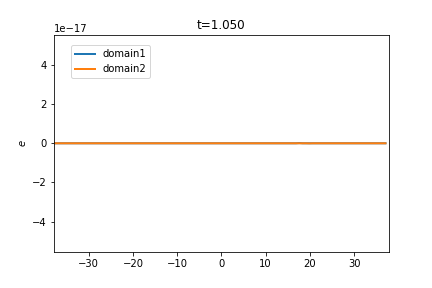
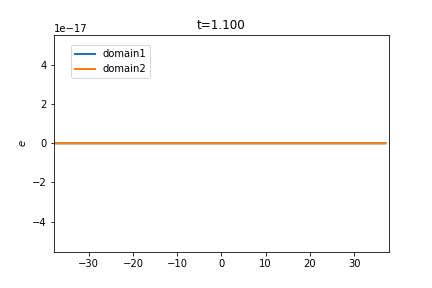
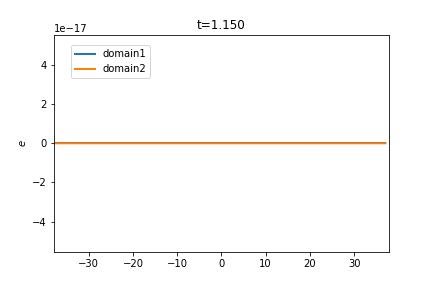
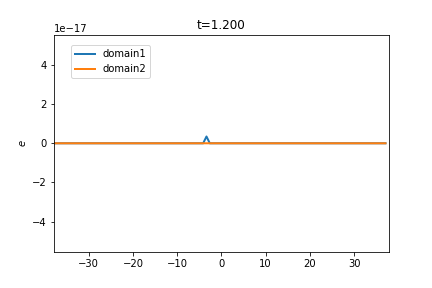
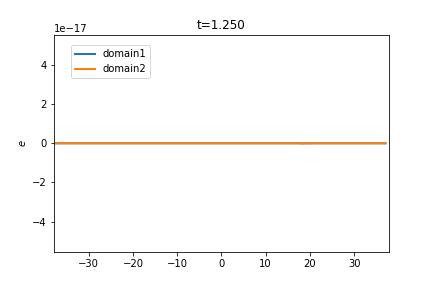
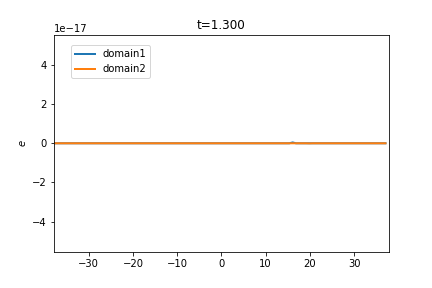
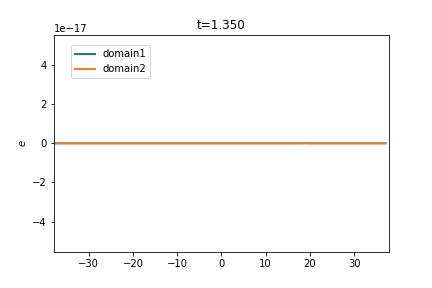
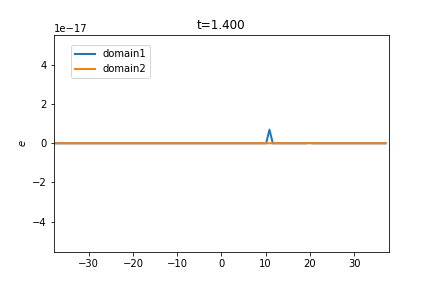
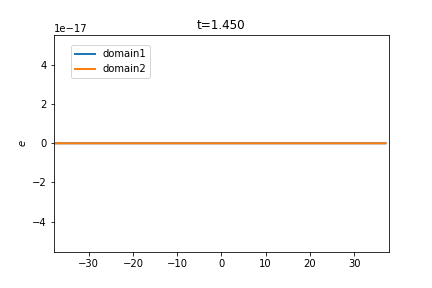
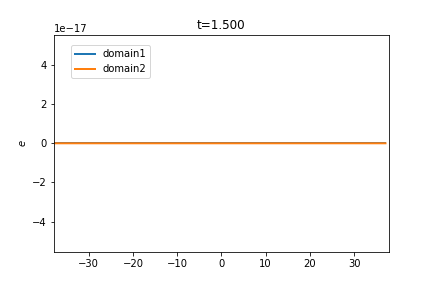
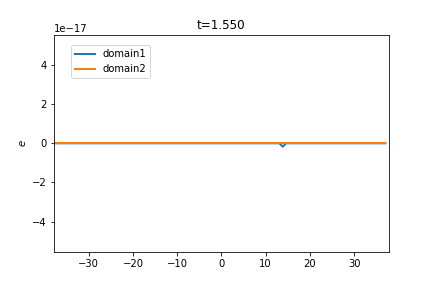
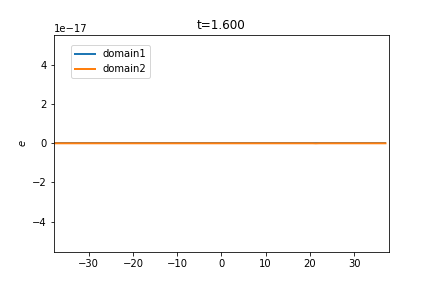
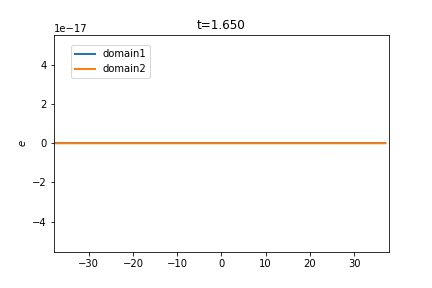
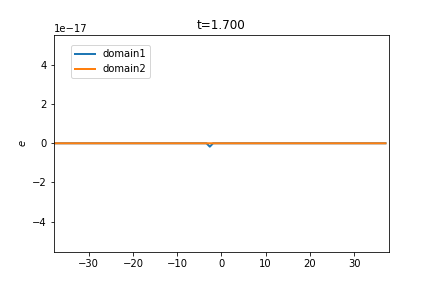
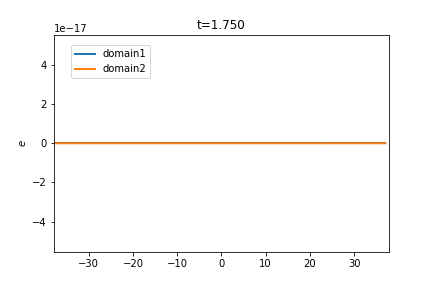
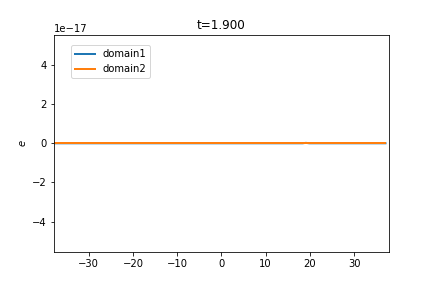
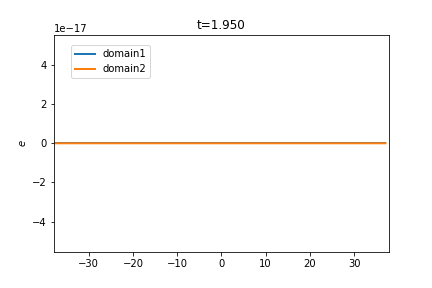
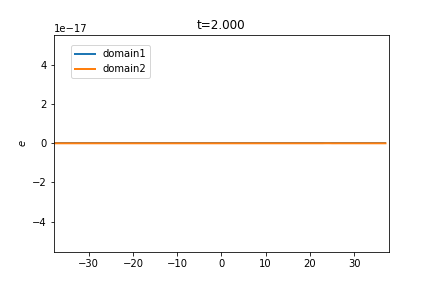
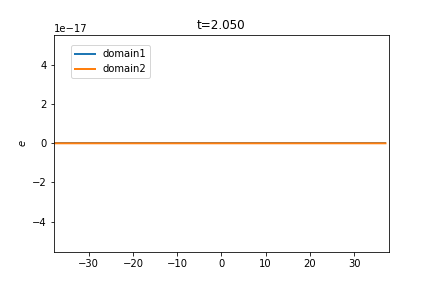
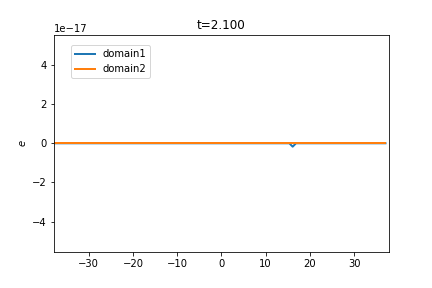
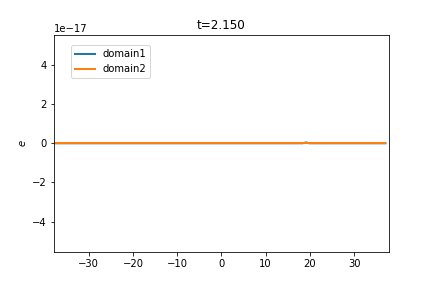
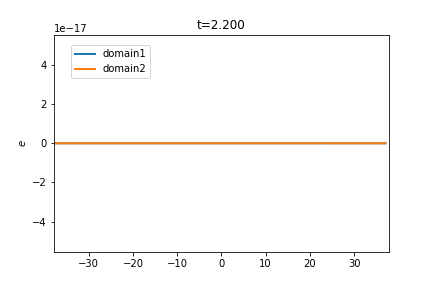
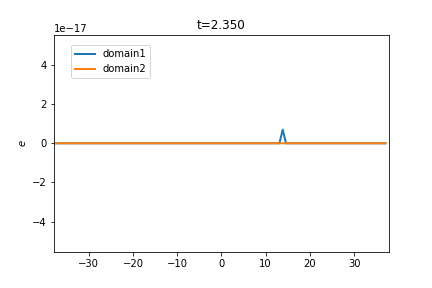
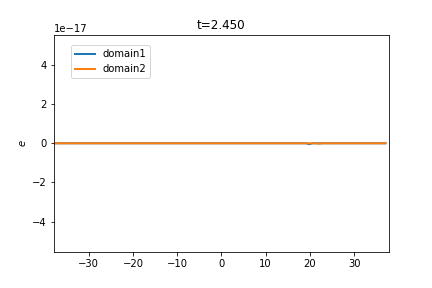
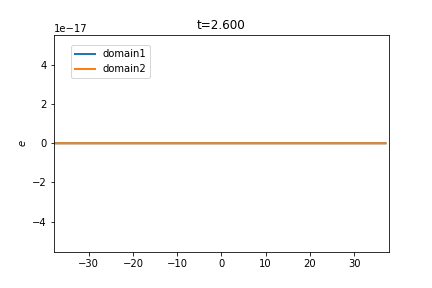
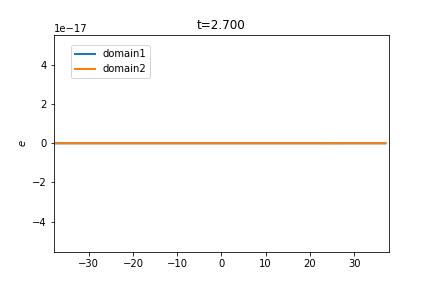
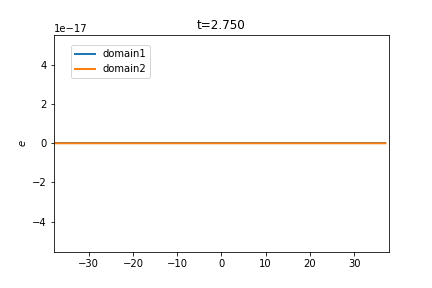
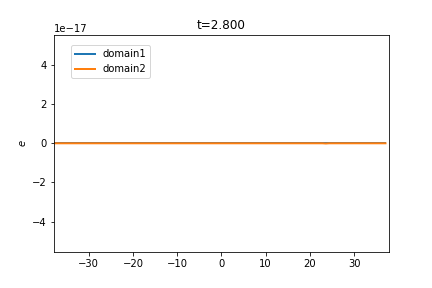
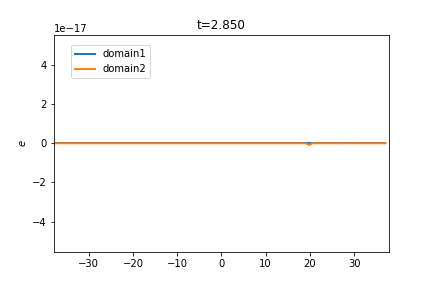
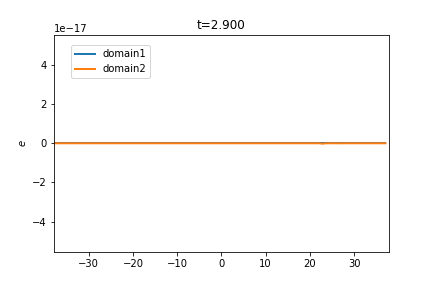
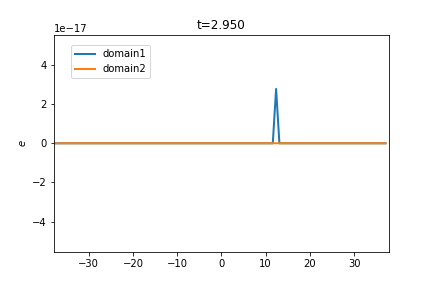
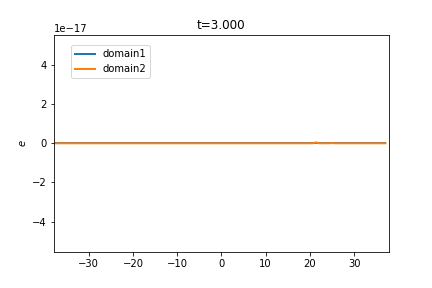
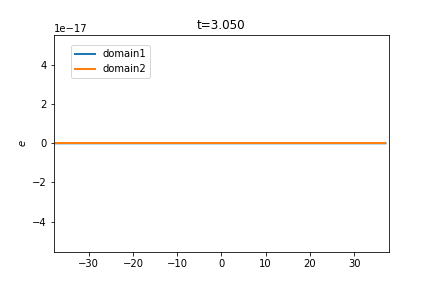
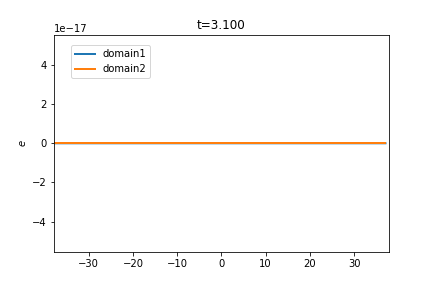
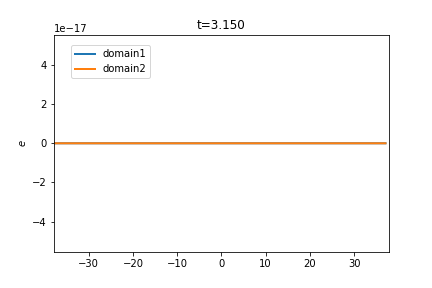
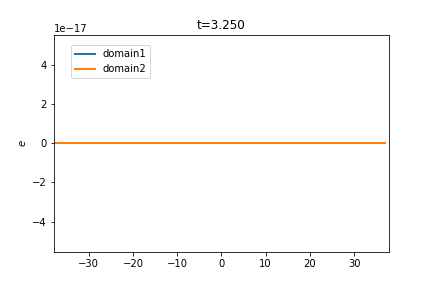
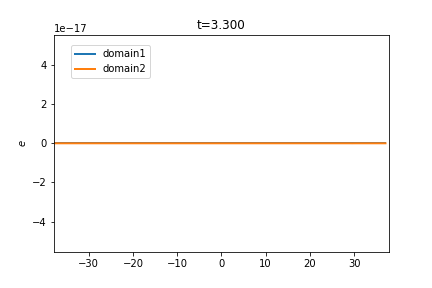
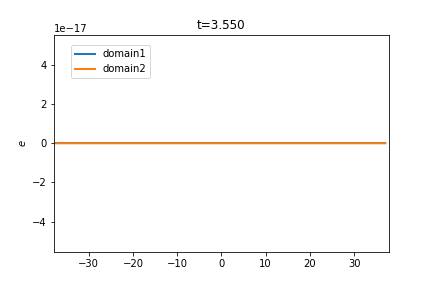
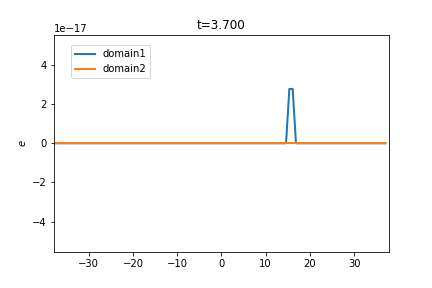
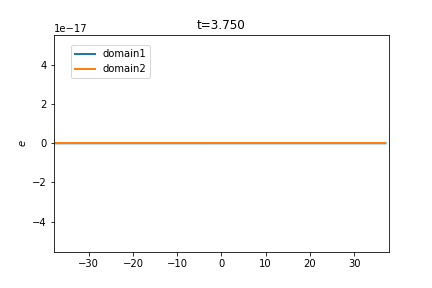
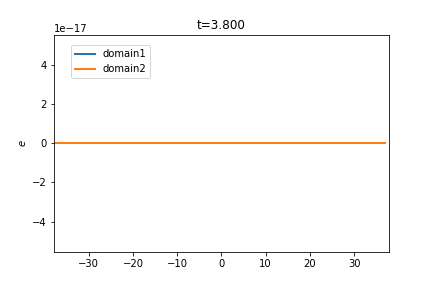
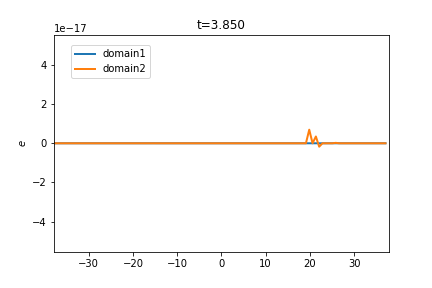
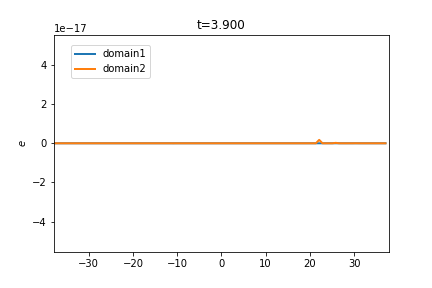
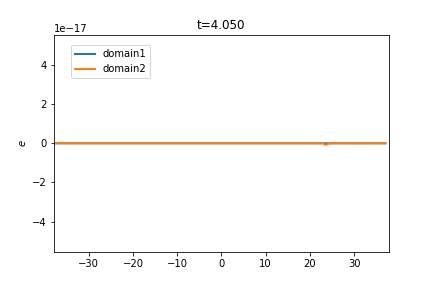
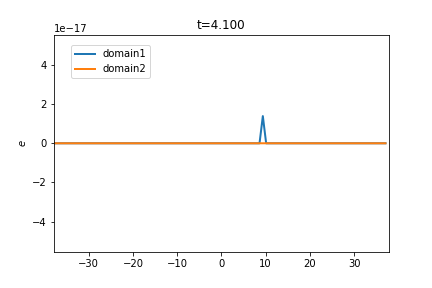
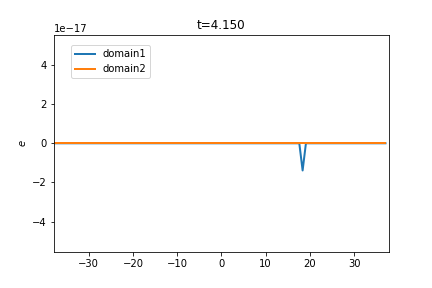
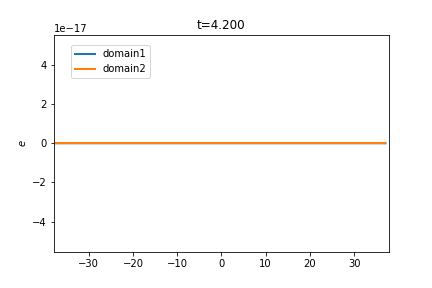
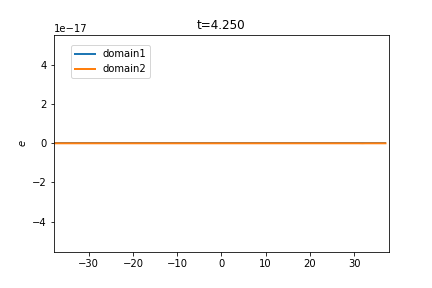
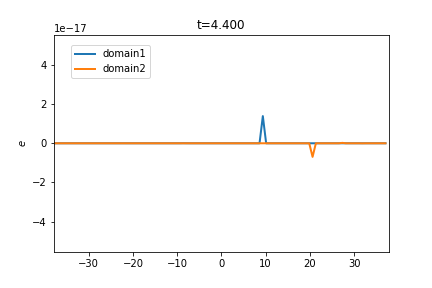
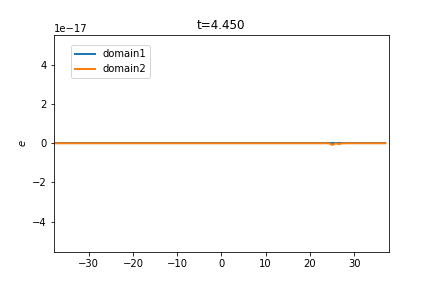
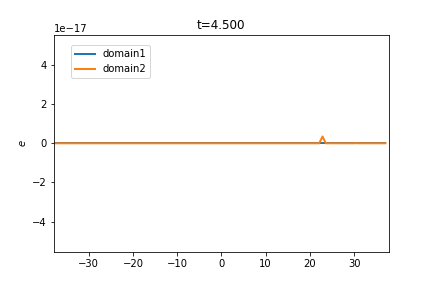
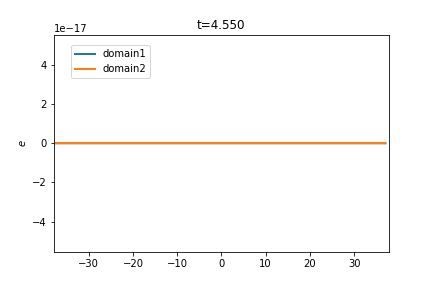
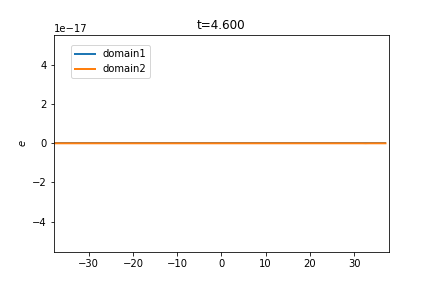
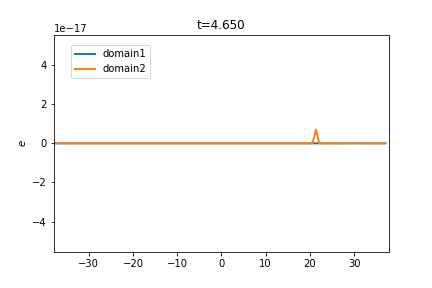
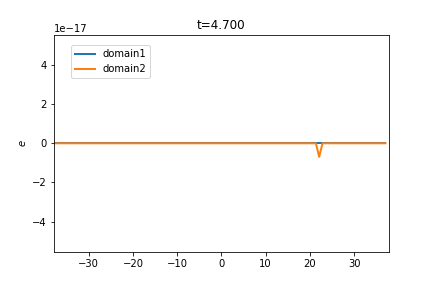
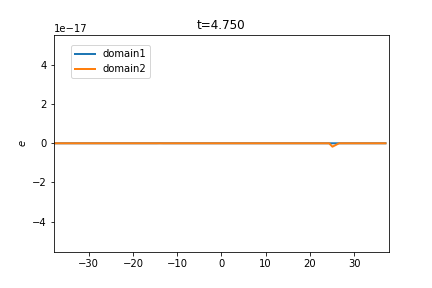
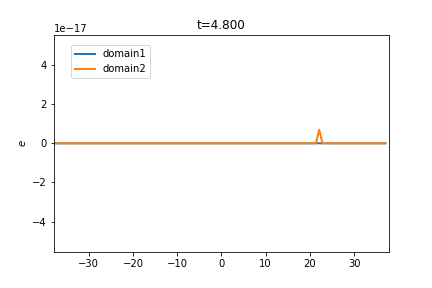
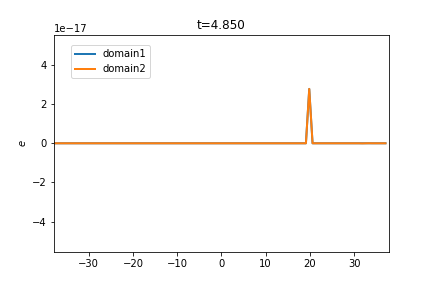
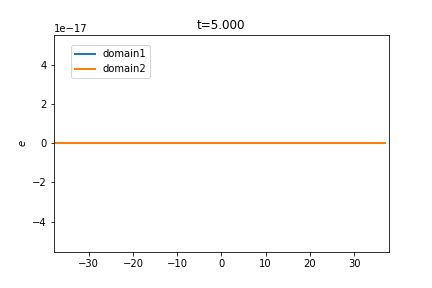
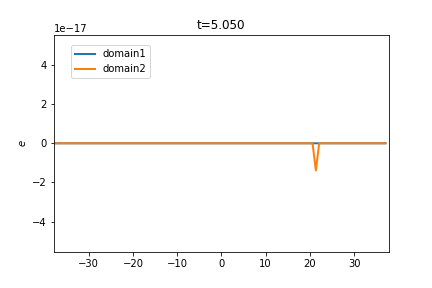
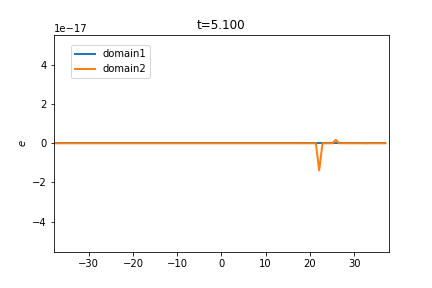
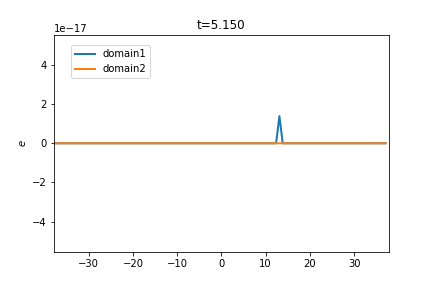
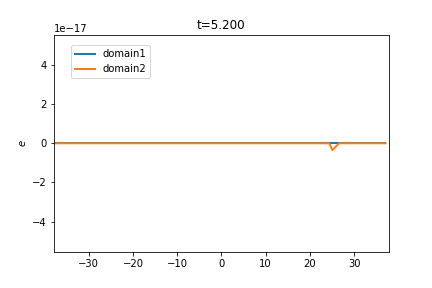
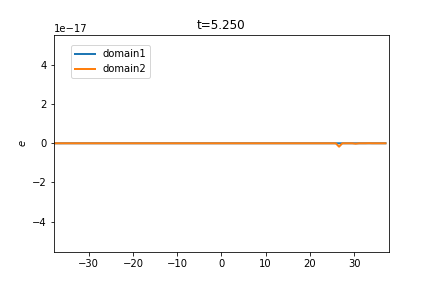
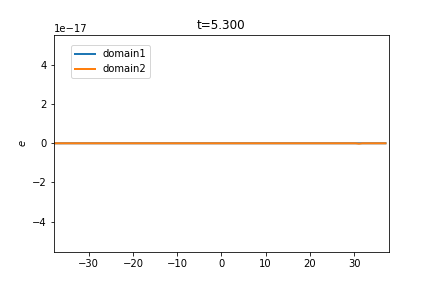
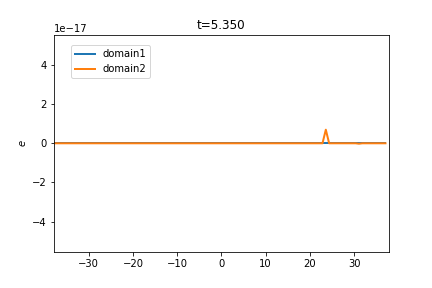
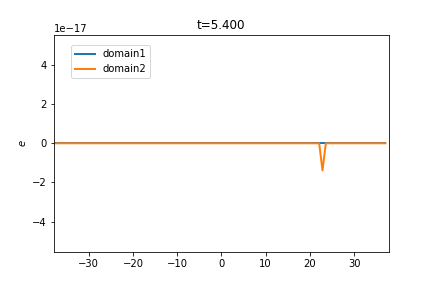
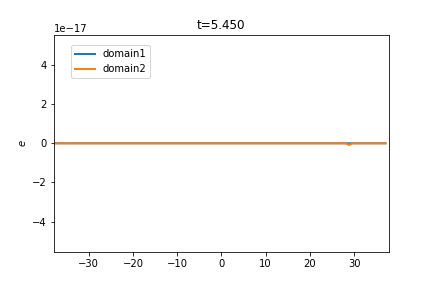
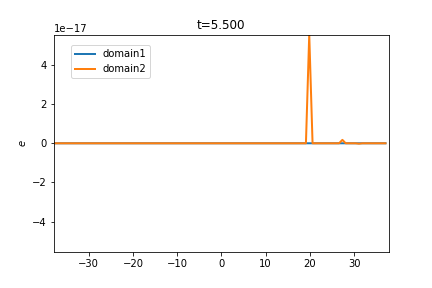
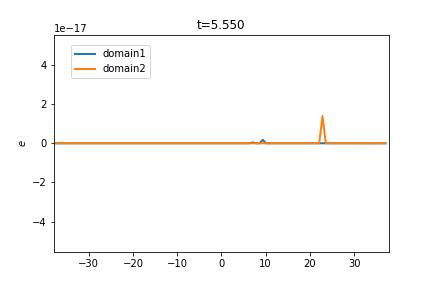
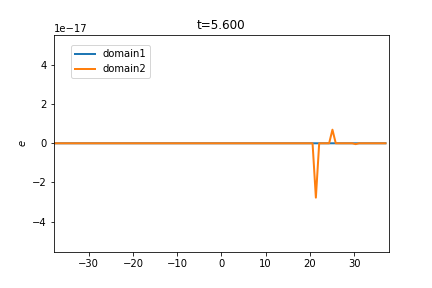
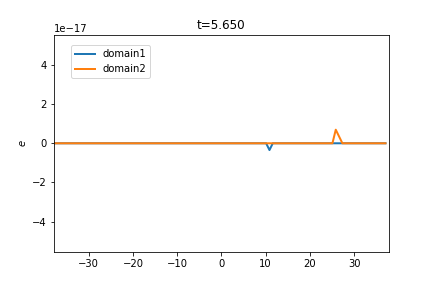
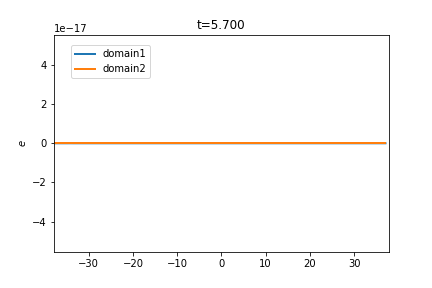
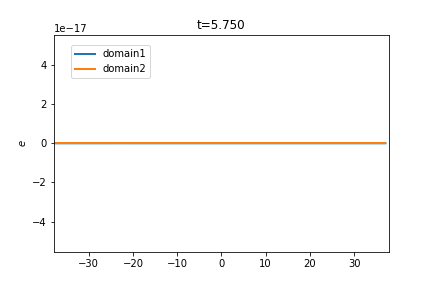
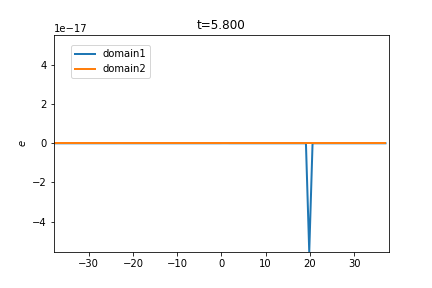
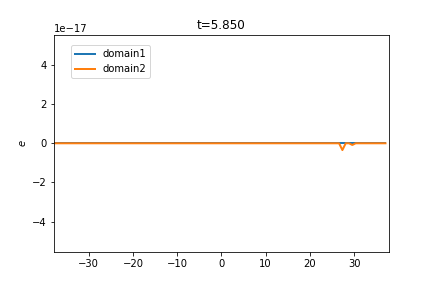
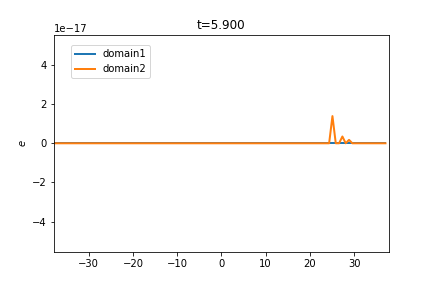
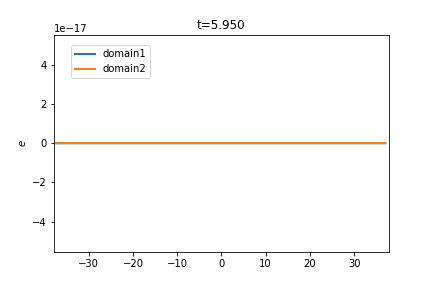
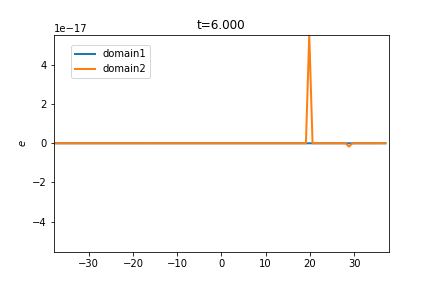
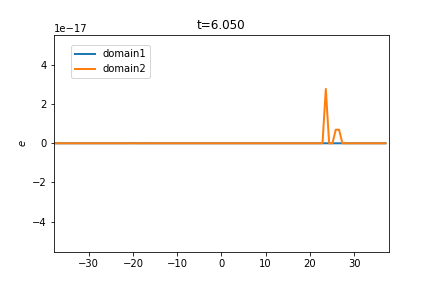
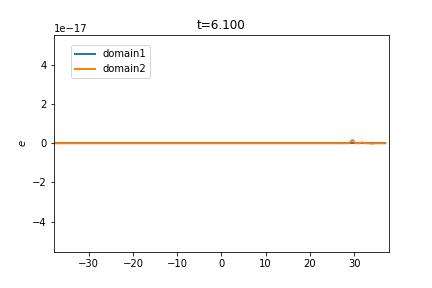
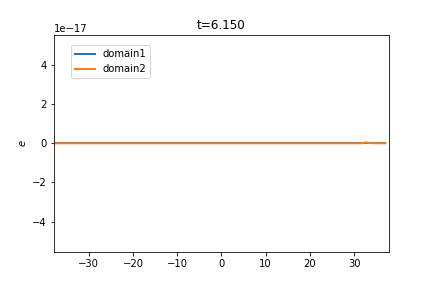
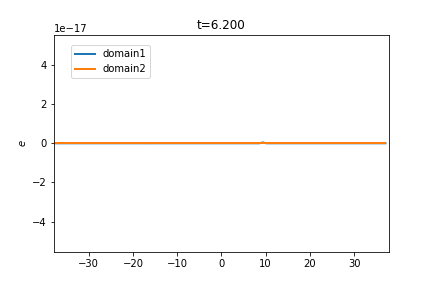
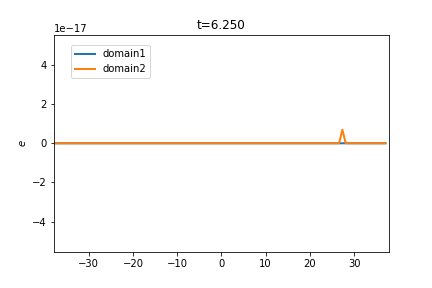
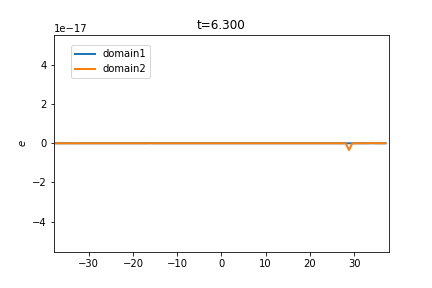
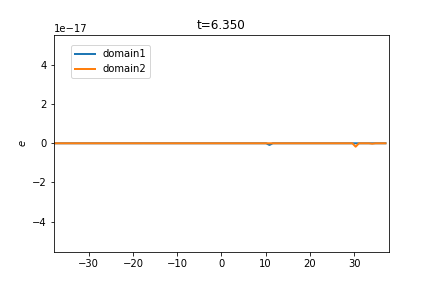
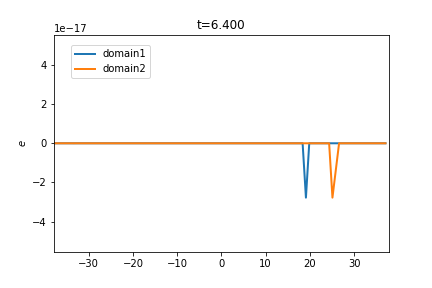
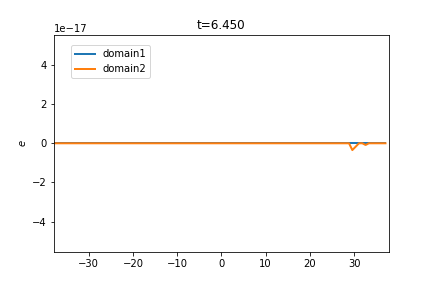
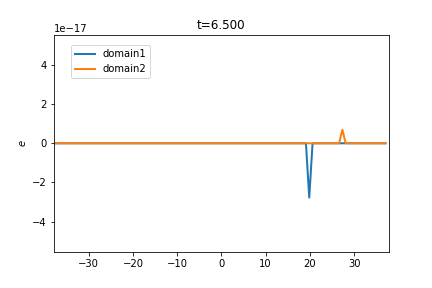
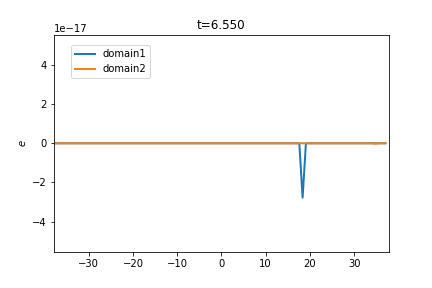
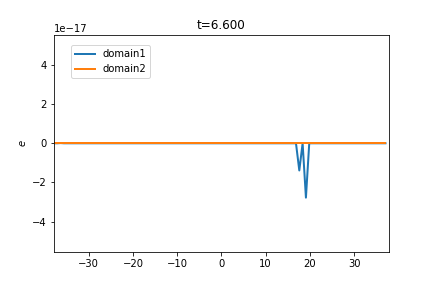
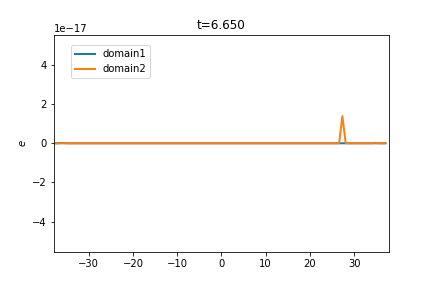
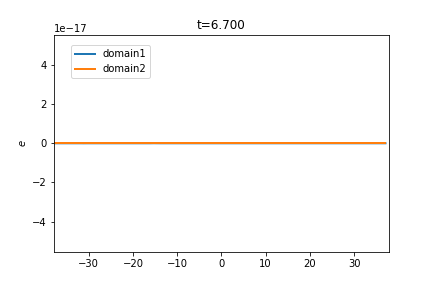
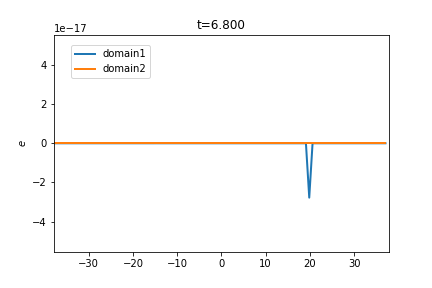
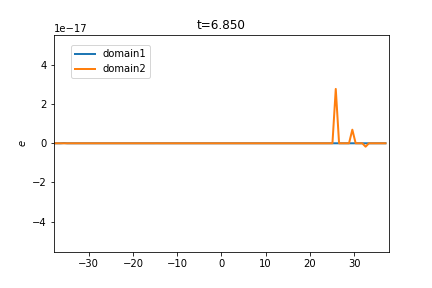
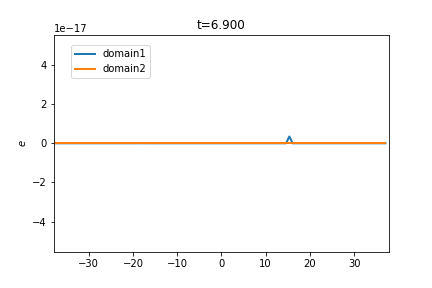
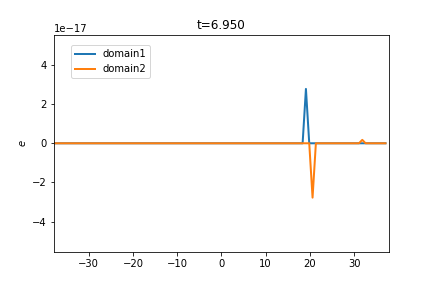
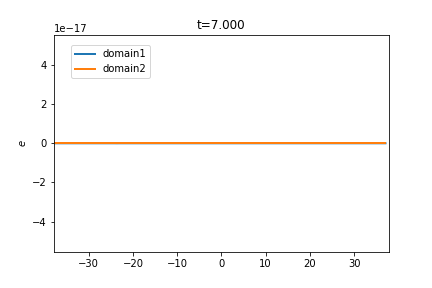
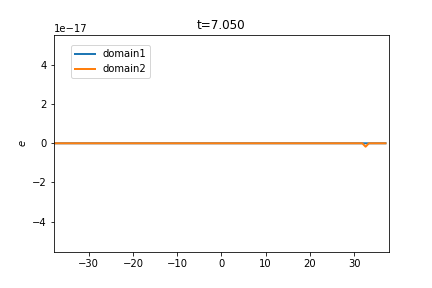
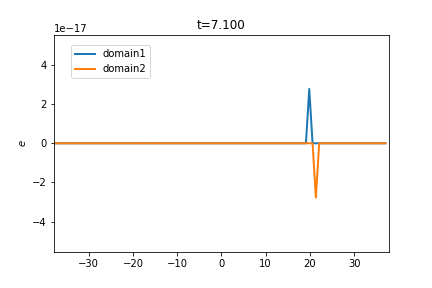
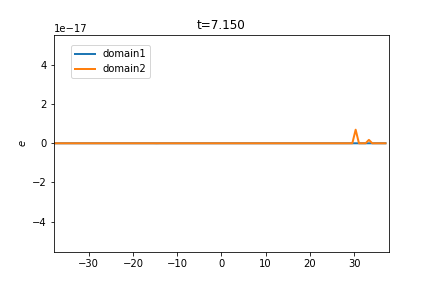
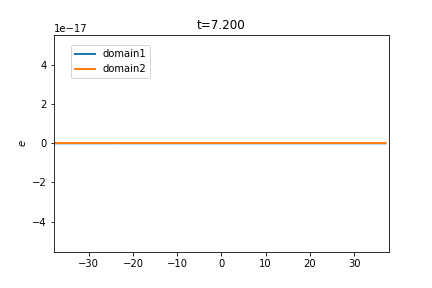
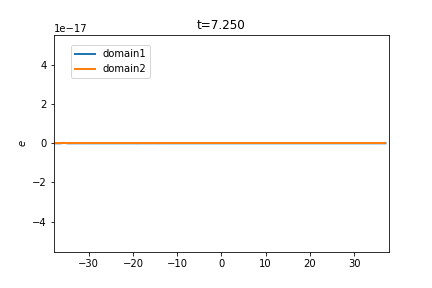
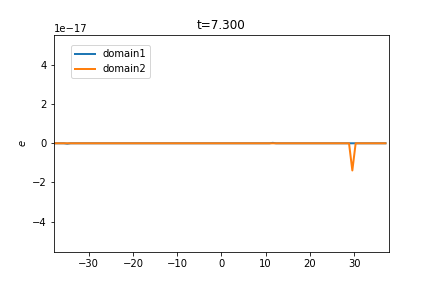
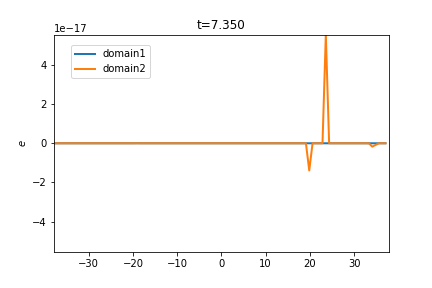
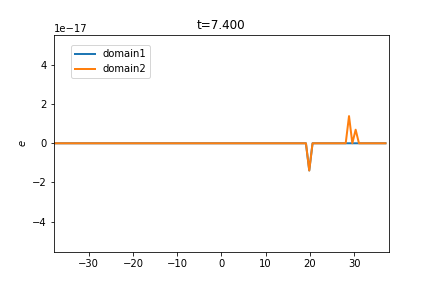
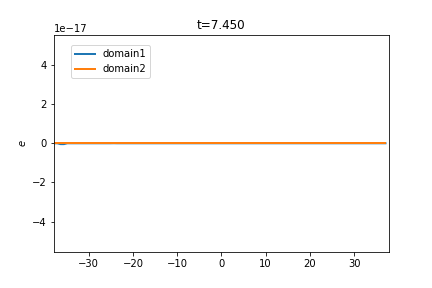
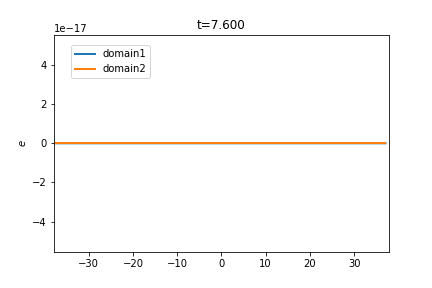
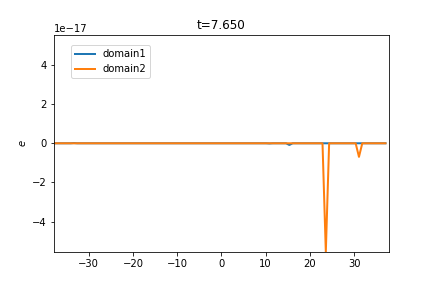
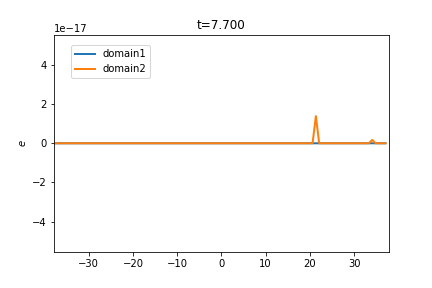
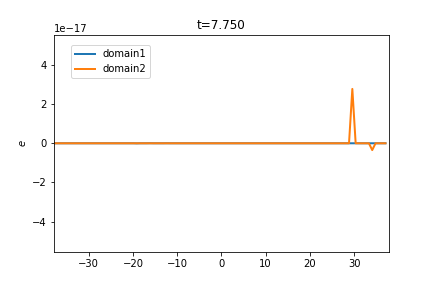
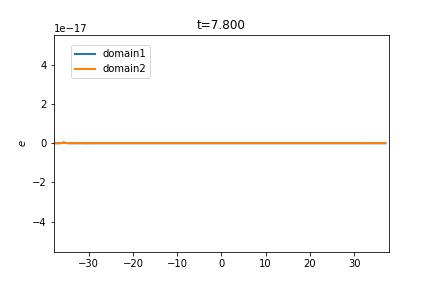
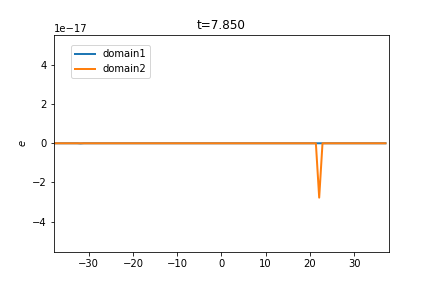
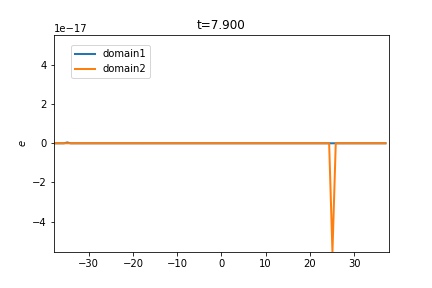
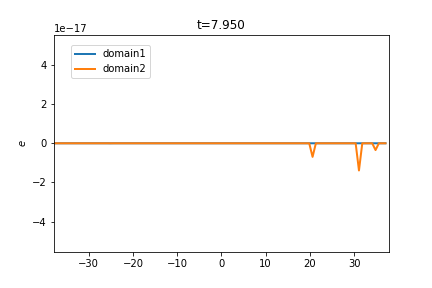
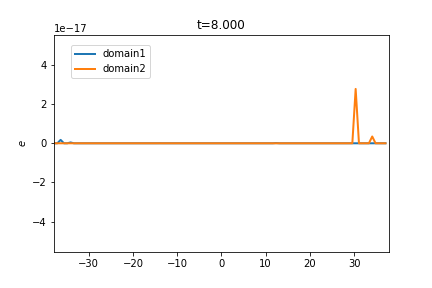
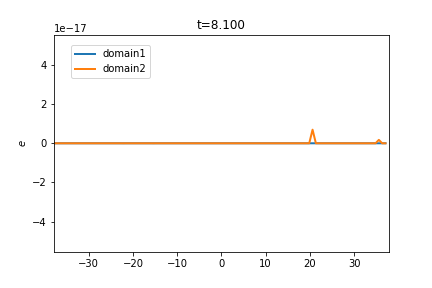
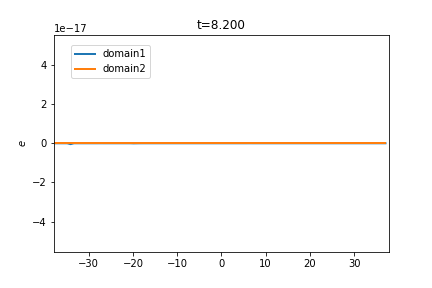
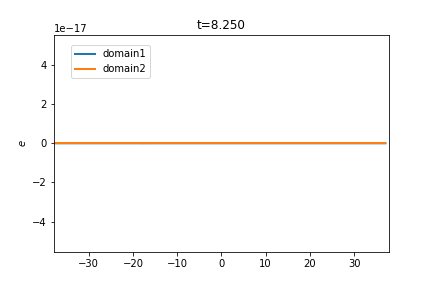
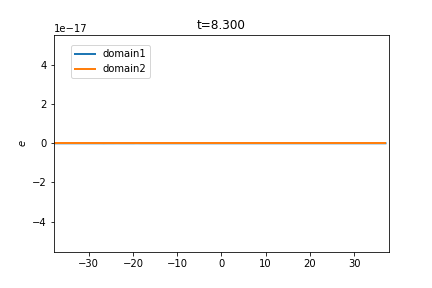
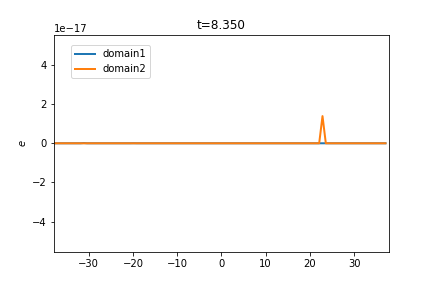
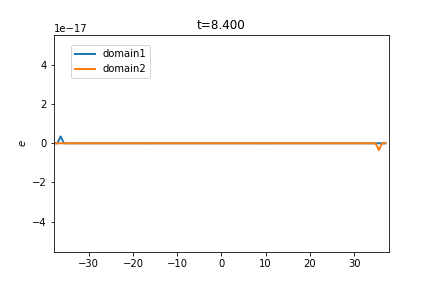
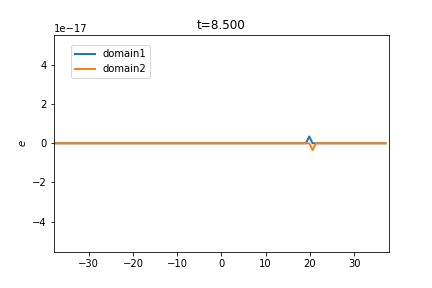
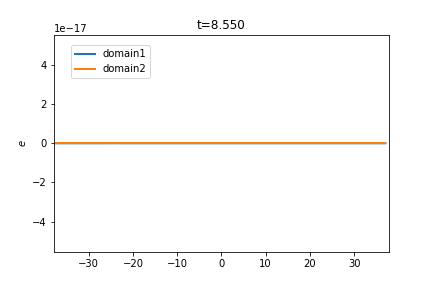
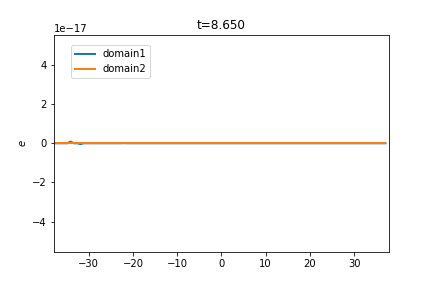
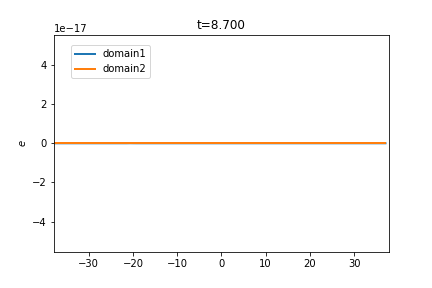
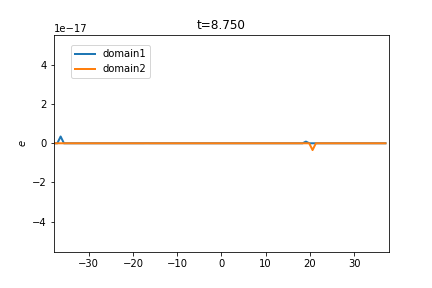
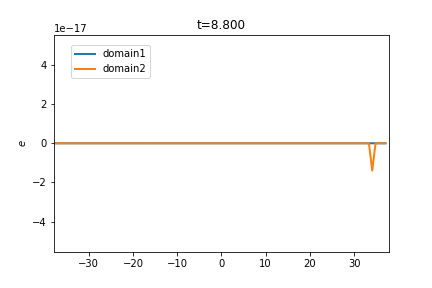
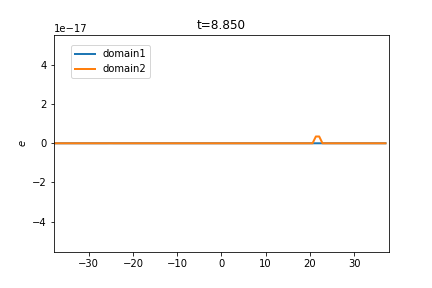
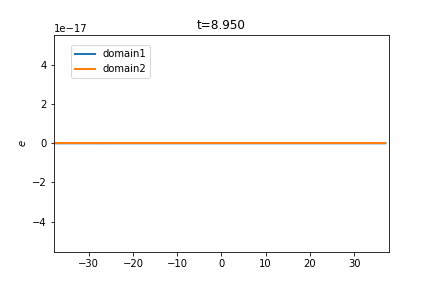
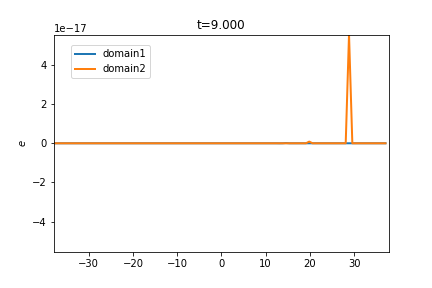
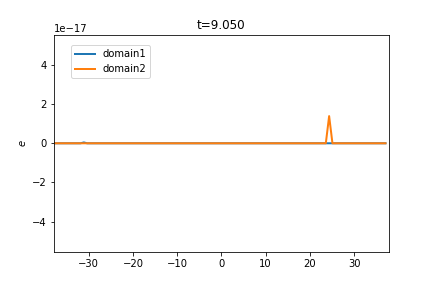
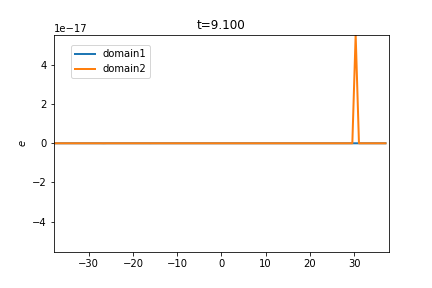
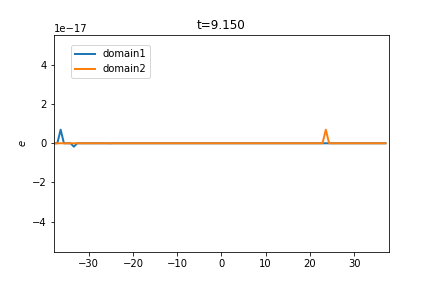
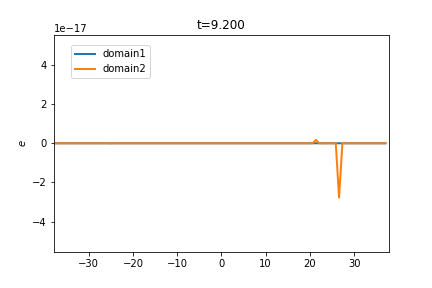
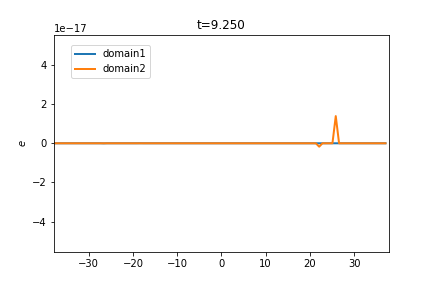
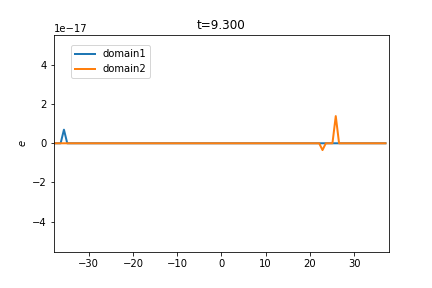
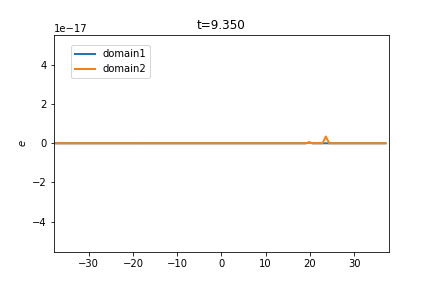
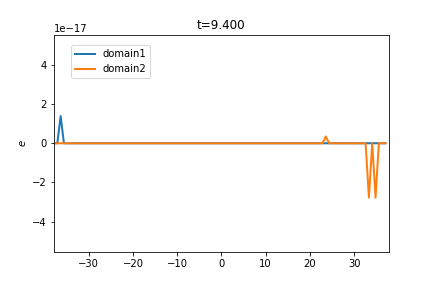
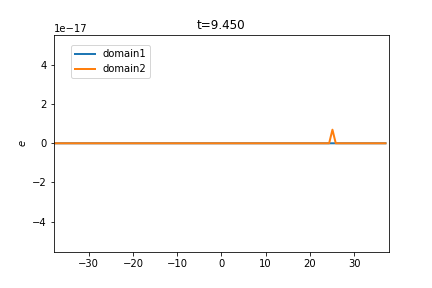
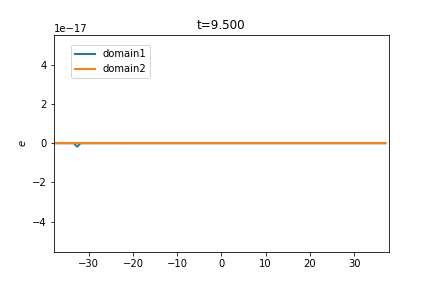
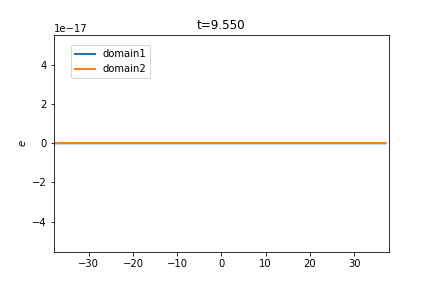
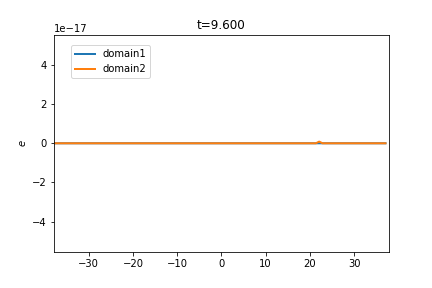
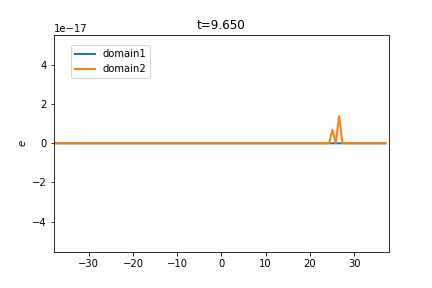
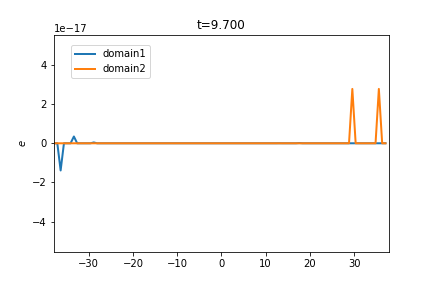
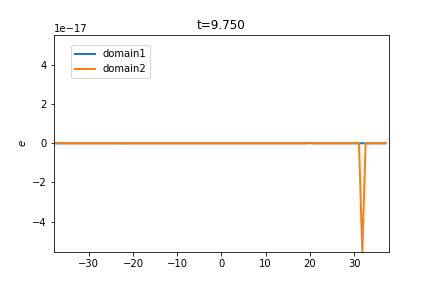
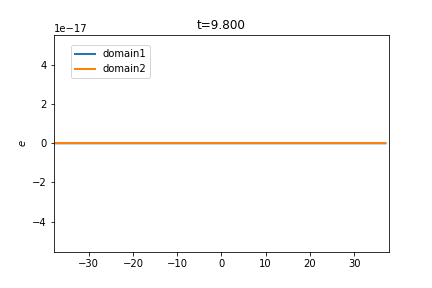
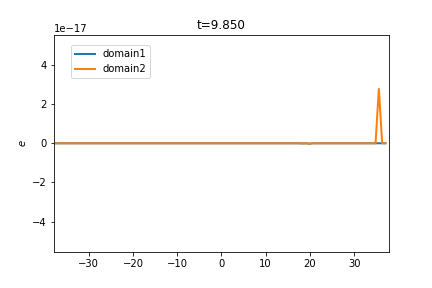
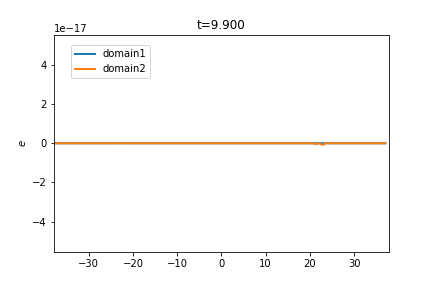
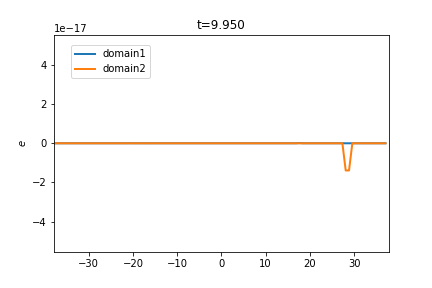
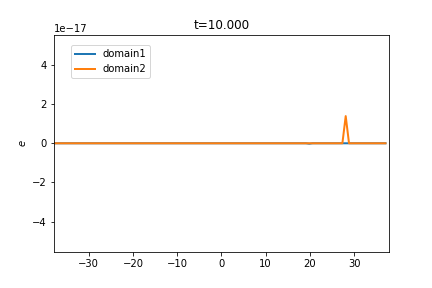
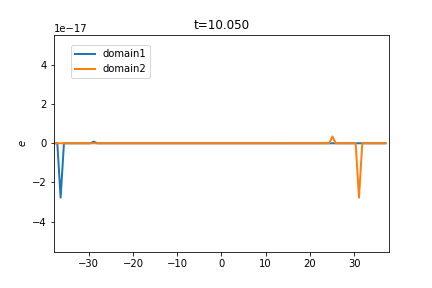
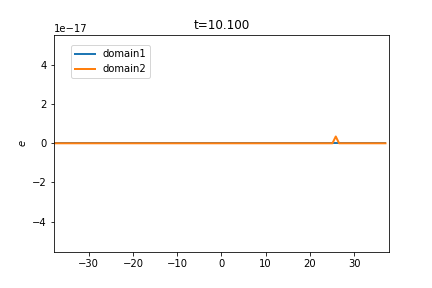
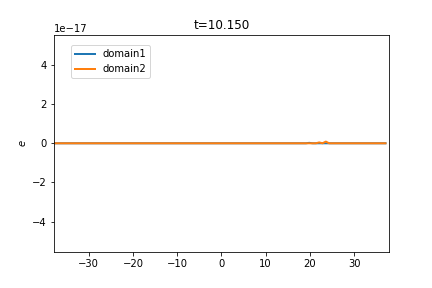
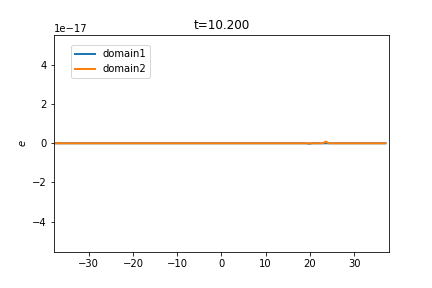
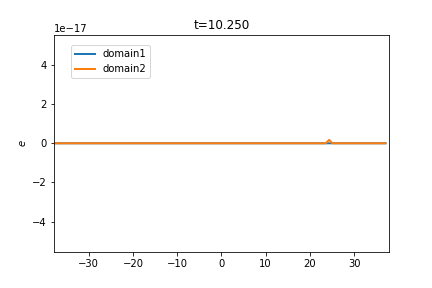
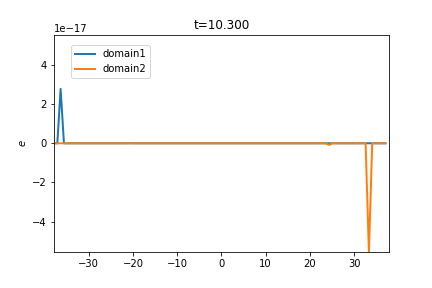
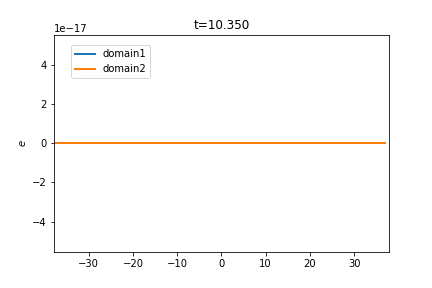
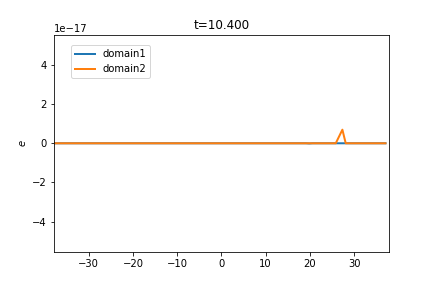
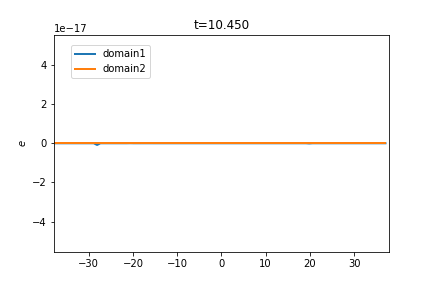
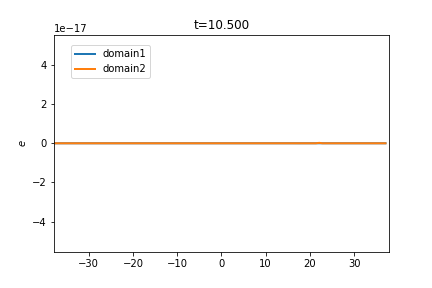
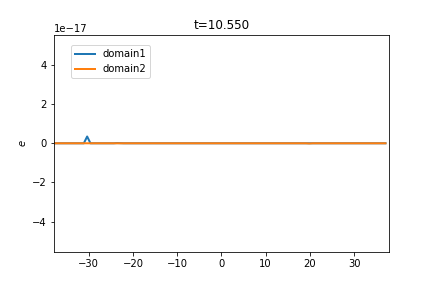
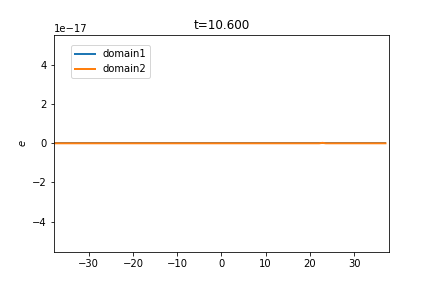
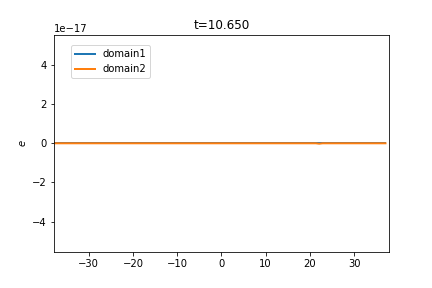
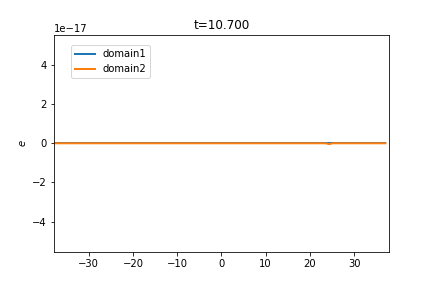
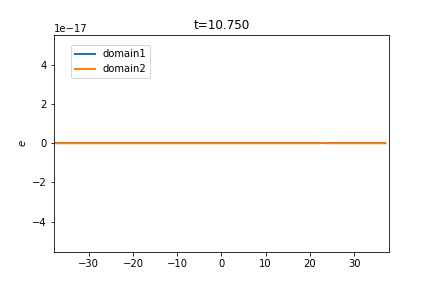
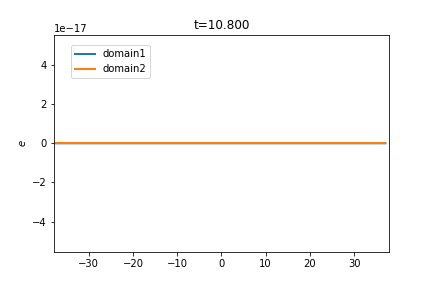
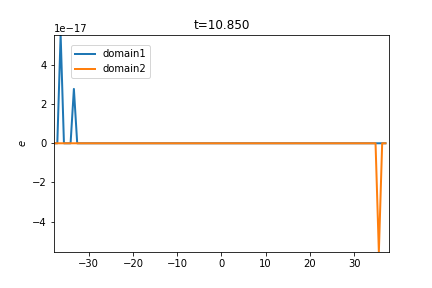
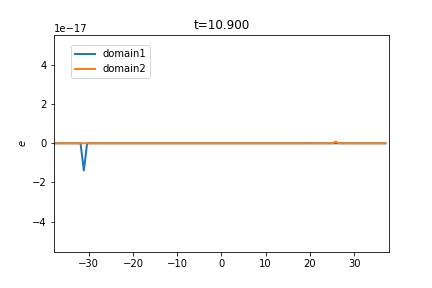
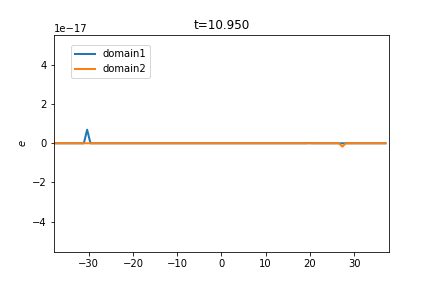
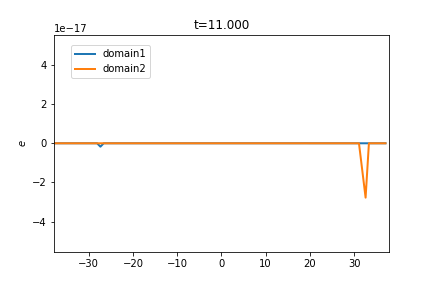
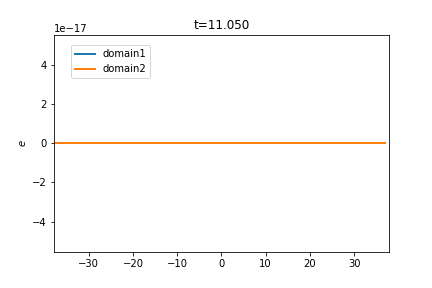
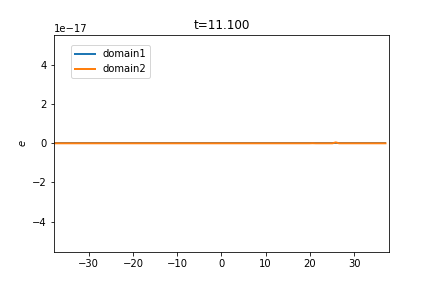
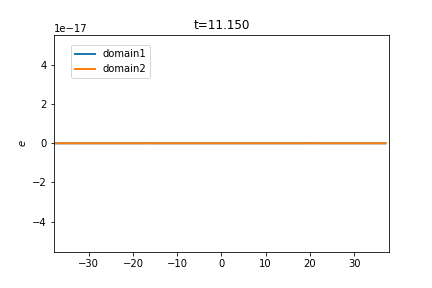
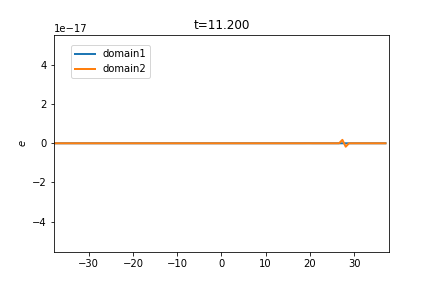
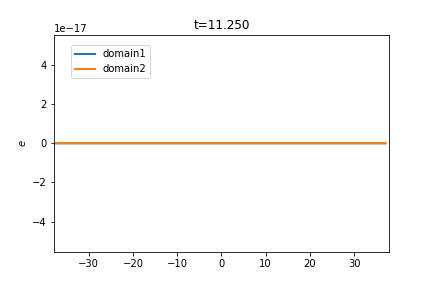
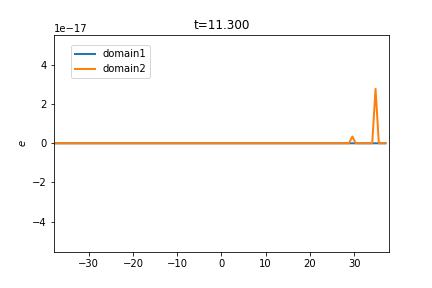
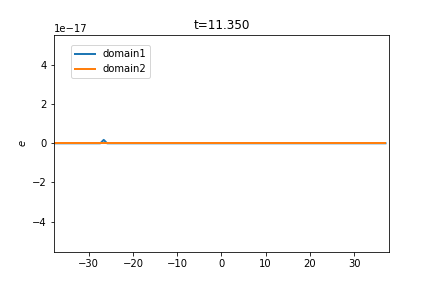
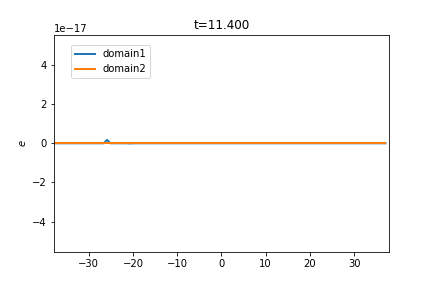
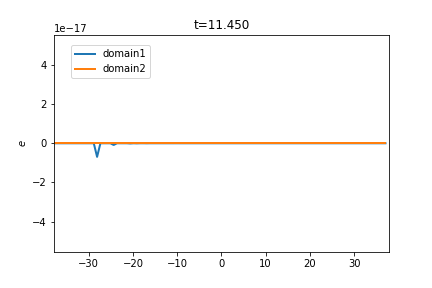
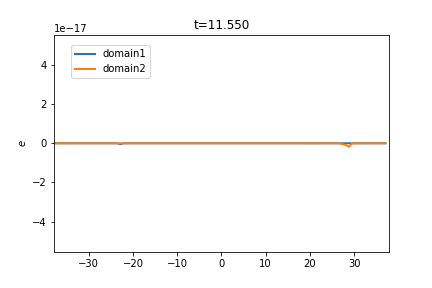
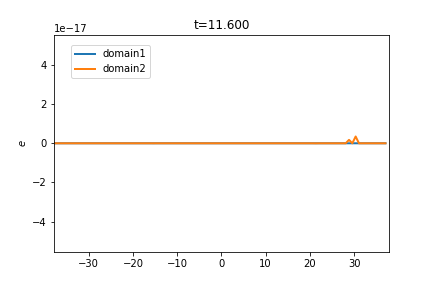
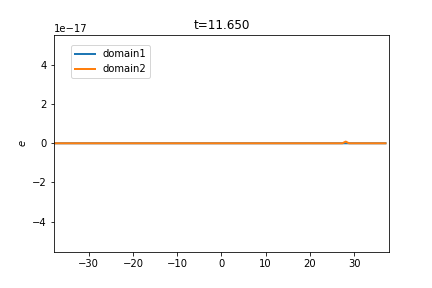
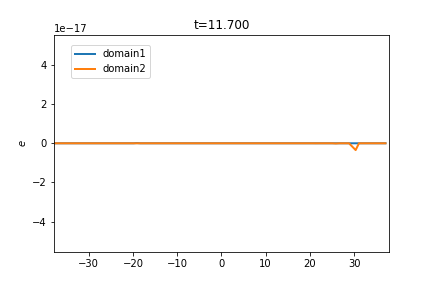
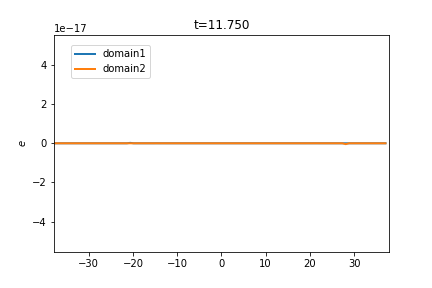
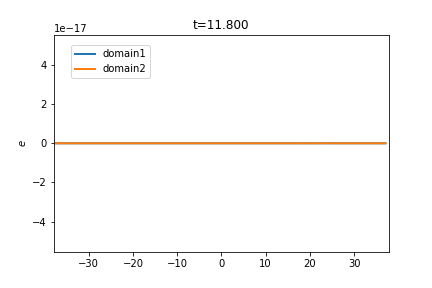
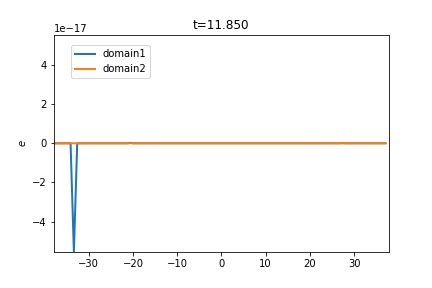
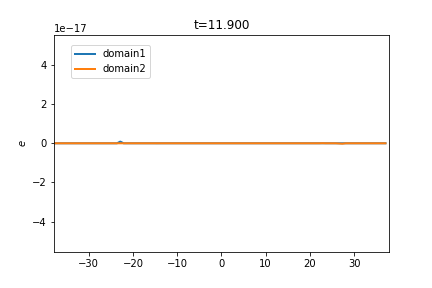
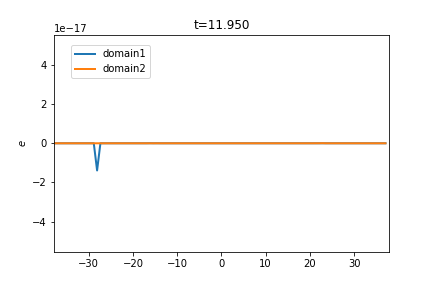
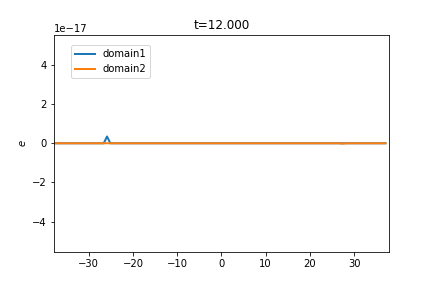
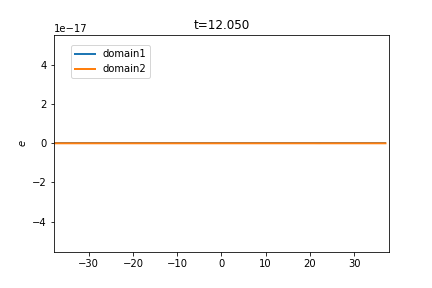
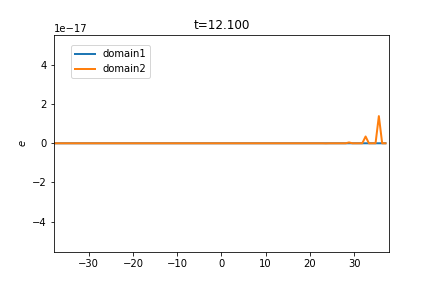
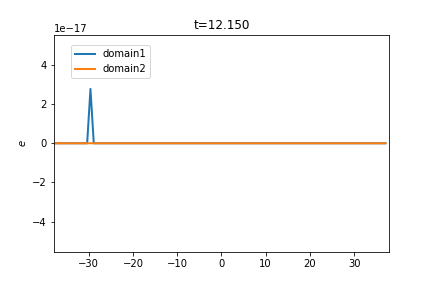
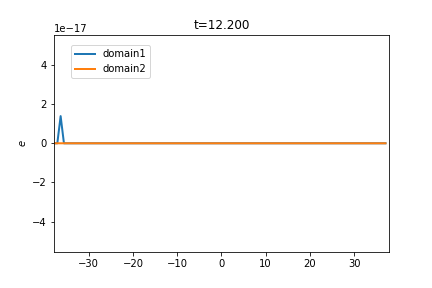
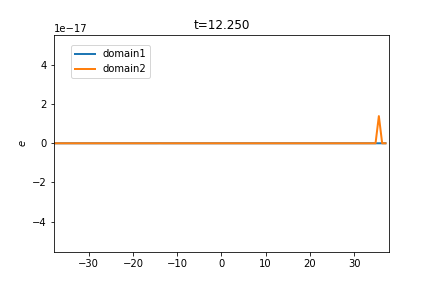
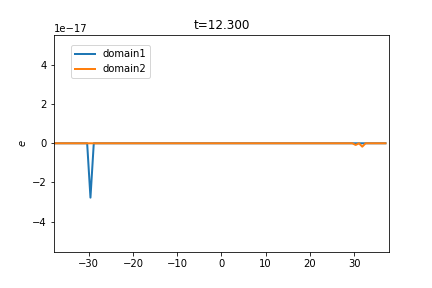
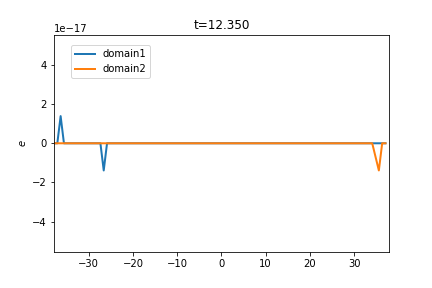
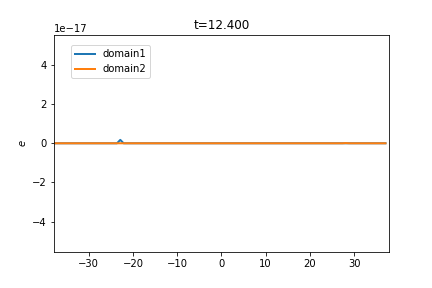
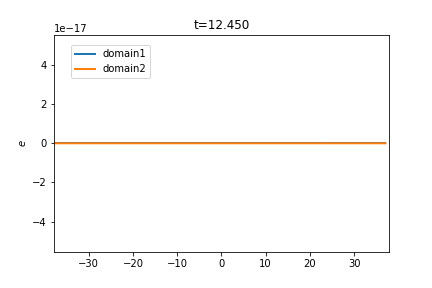
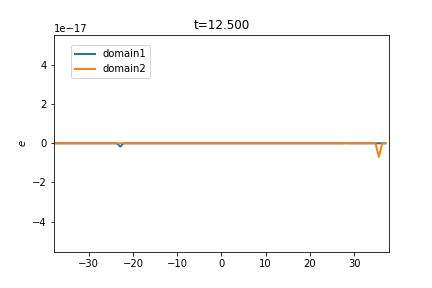
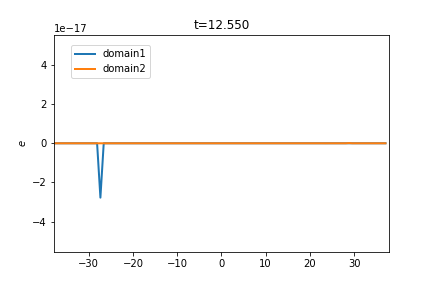
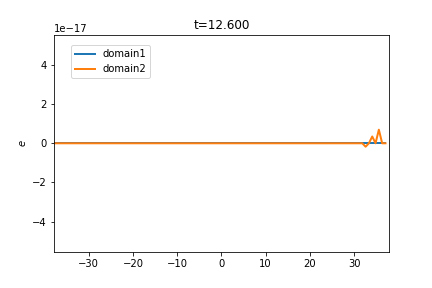
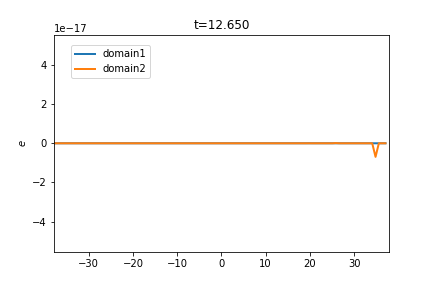
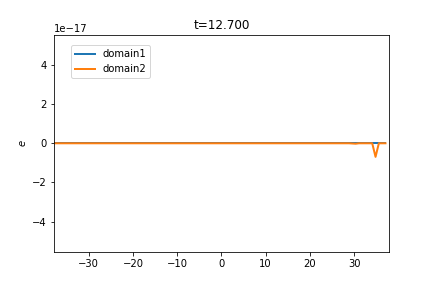
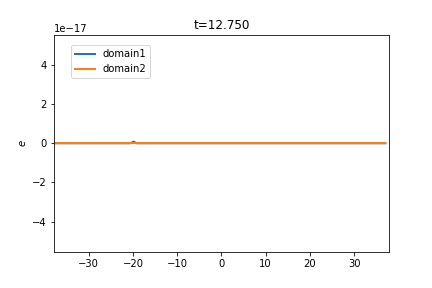
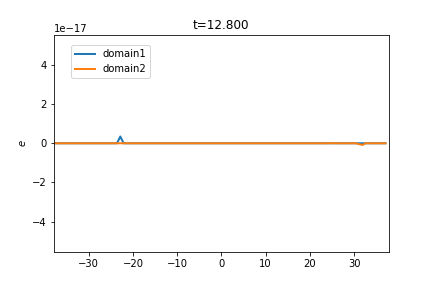
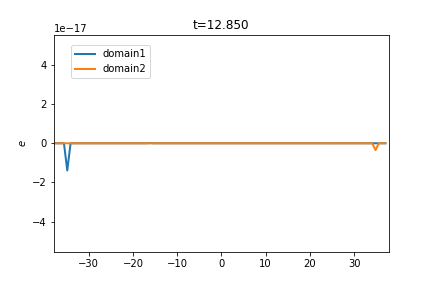
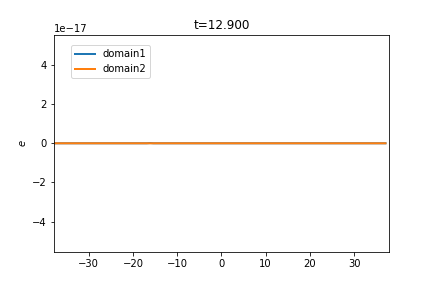
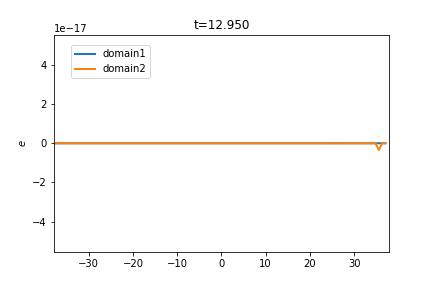
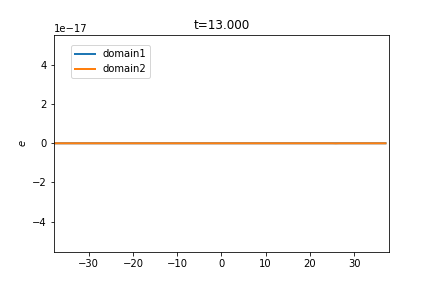
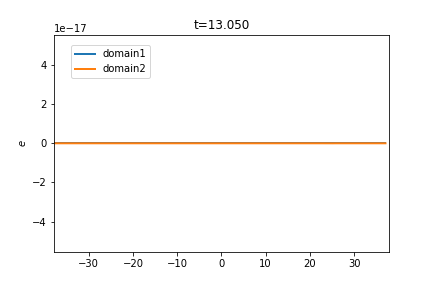
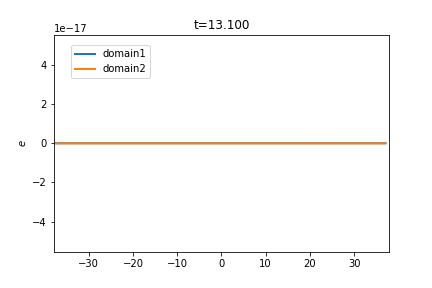
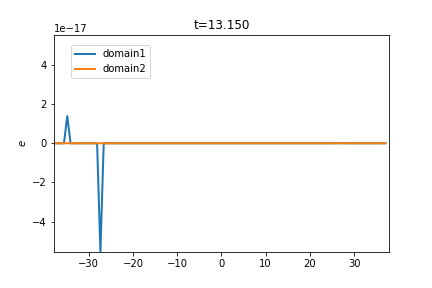
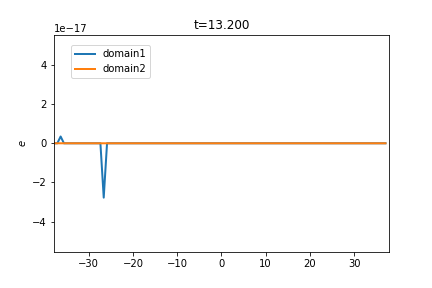
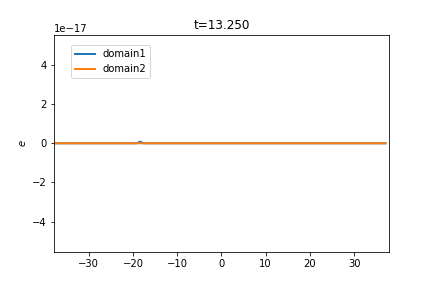
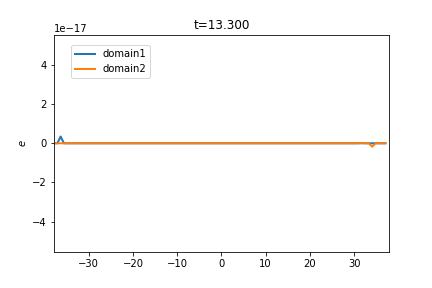
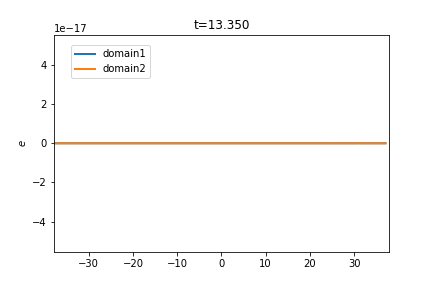
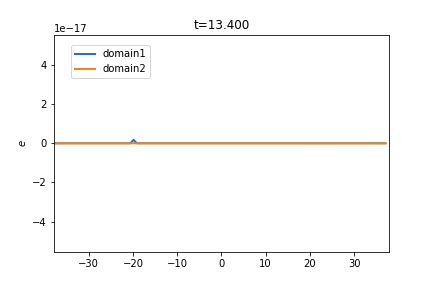
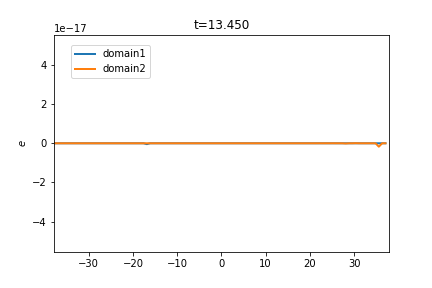
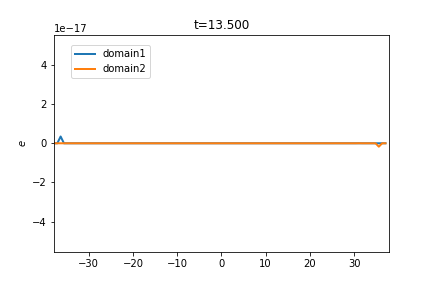
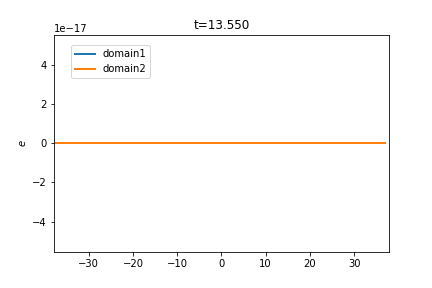
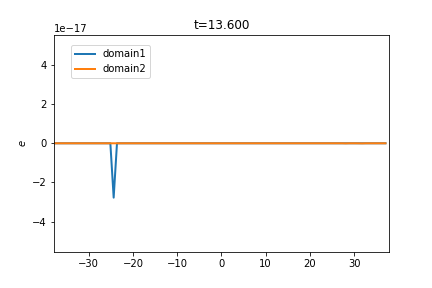
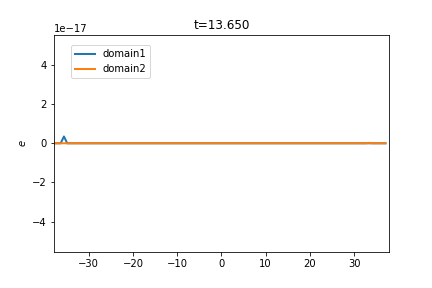
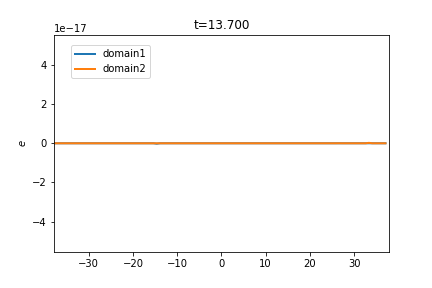
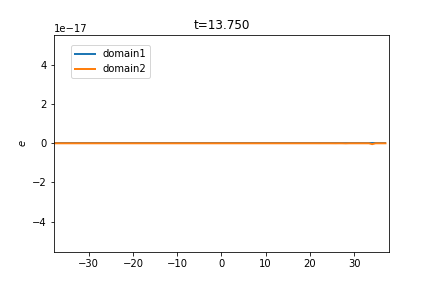
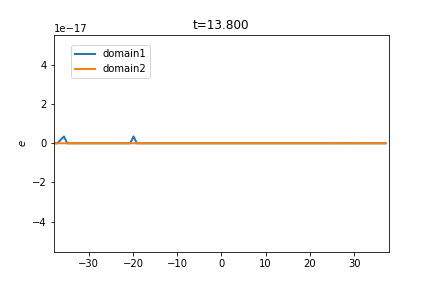
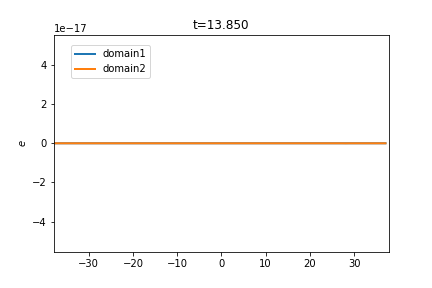
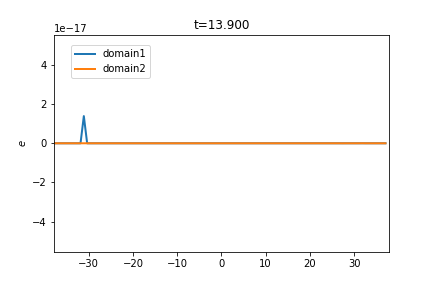
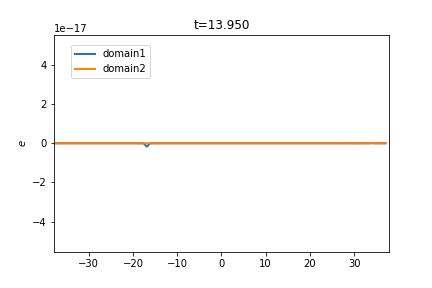
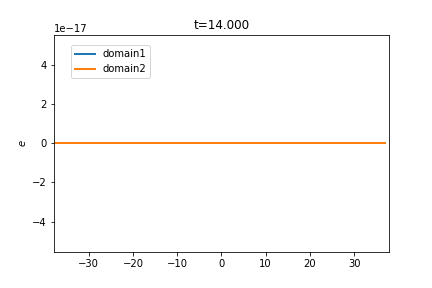
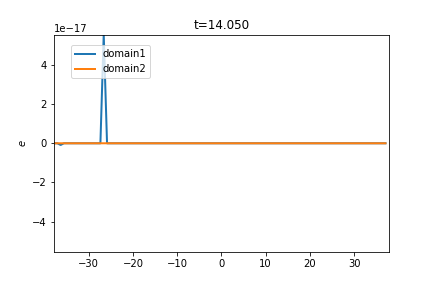
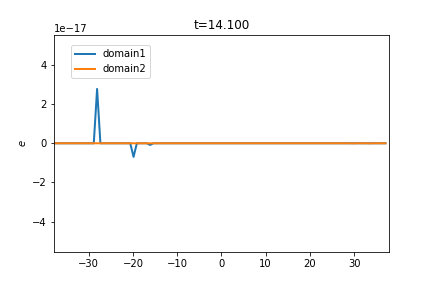
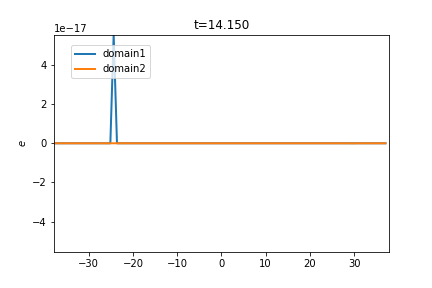
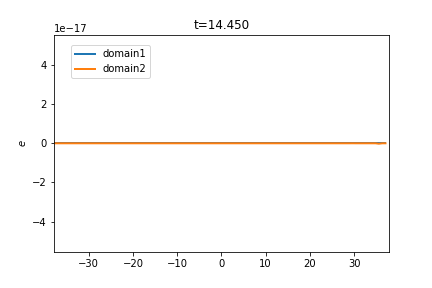
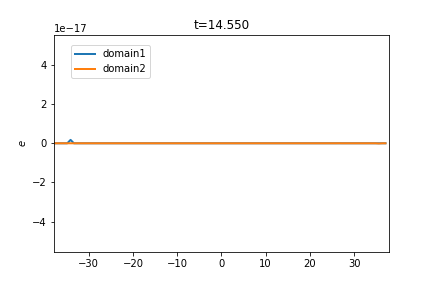
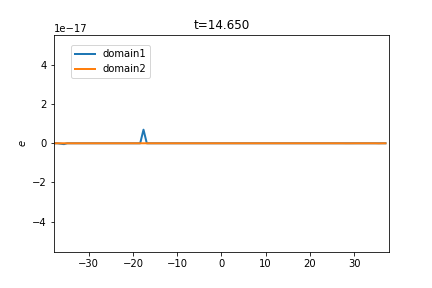
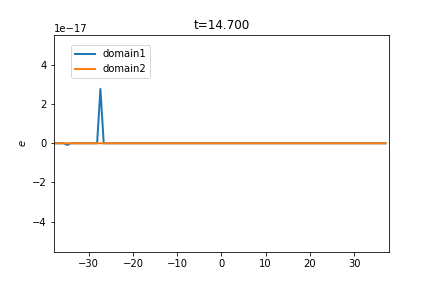
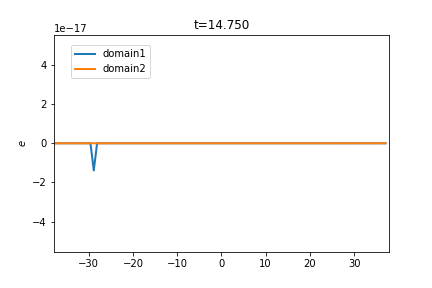
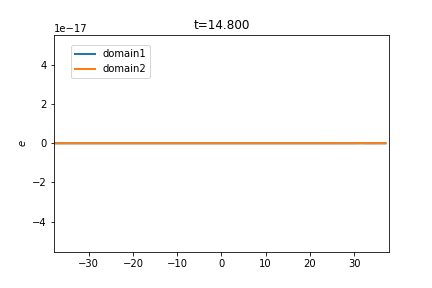
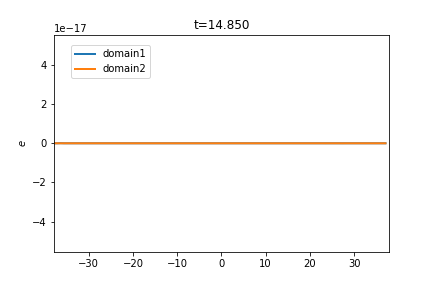
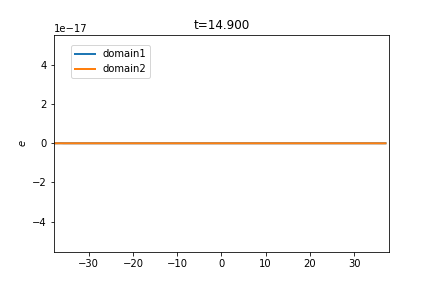

In [16]:
lb = ["domain1","domain2"]
# save = None
save = "./u_DDM_err.mp4"
gF.plotAnimationNSolutionsDiffDomain(2,[x,x],np.array([err1all,err2all]),tall,xmin,xmax,emin,emax,lb,
                                     ylabel=r'$e$',location=(0.05,0.80),savePath=save)

*** Plotting animation ...



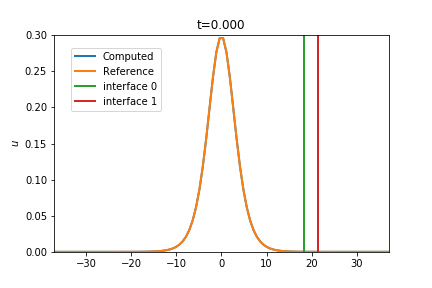
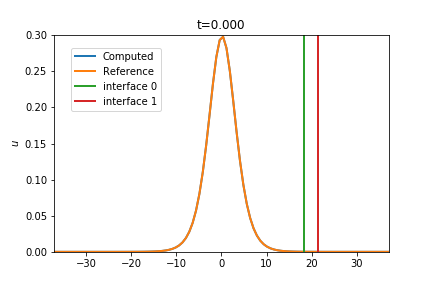
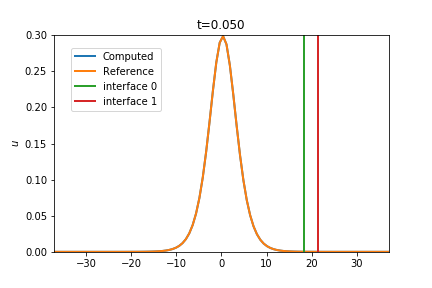
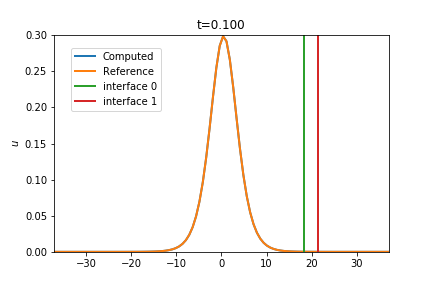
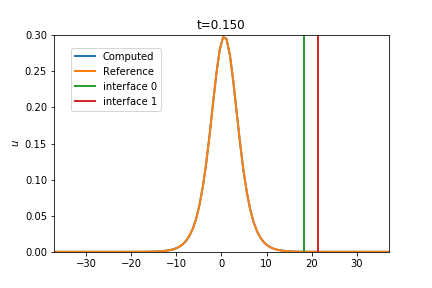
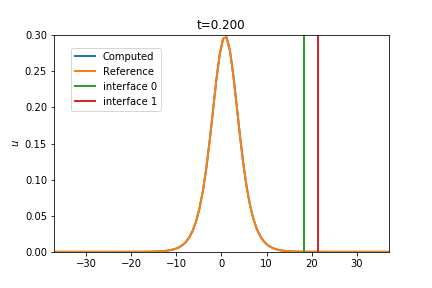
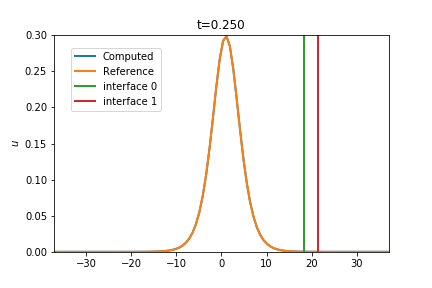
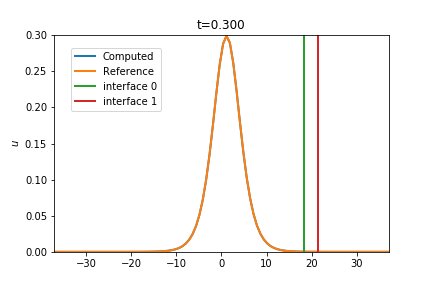
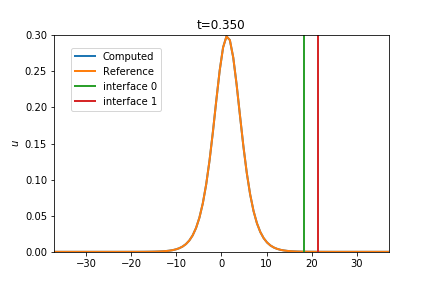
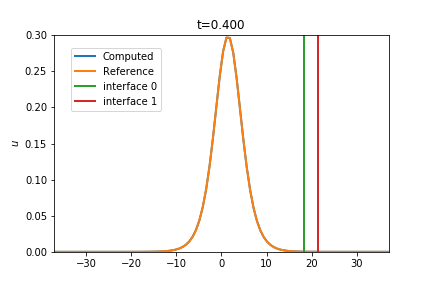
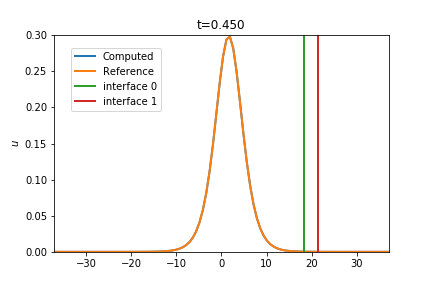
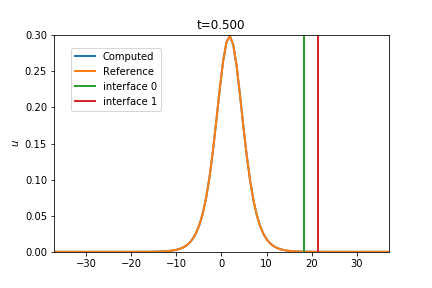
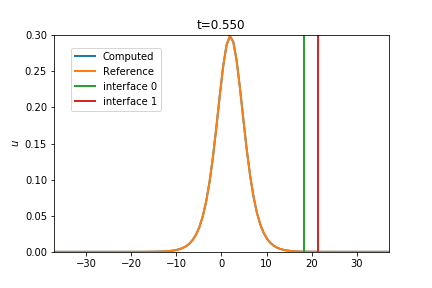
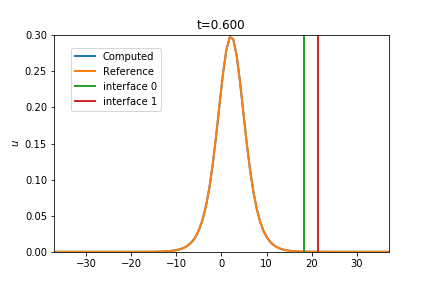
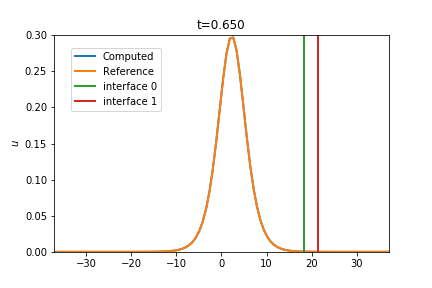
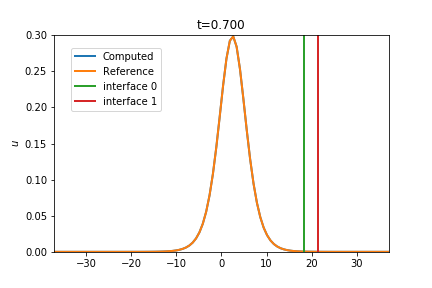
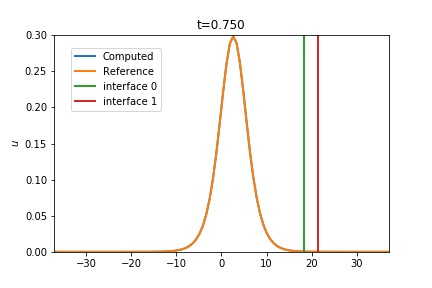
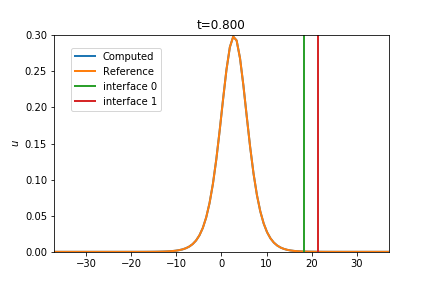
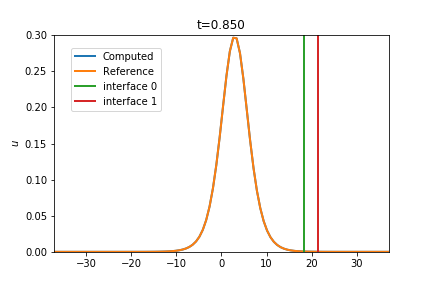
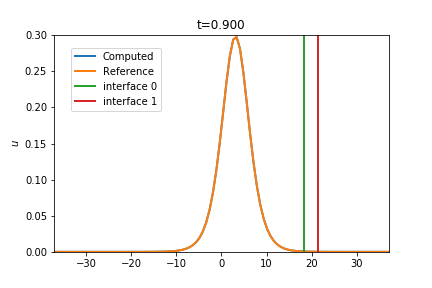
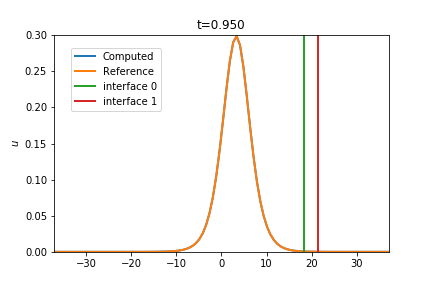
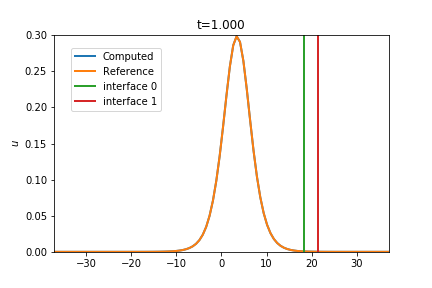
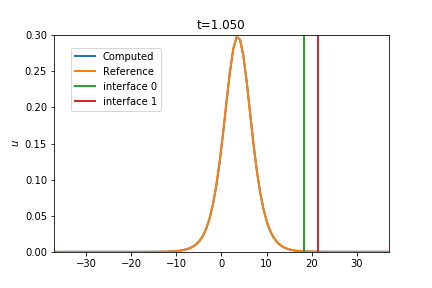
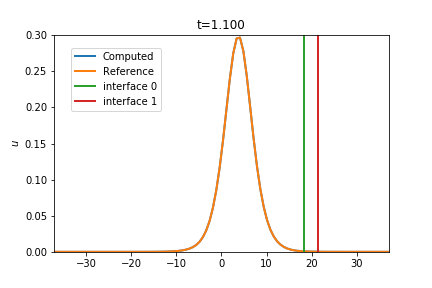
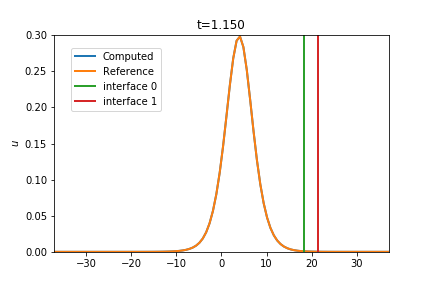
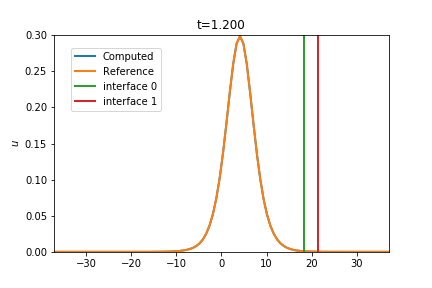
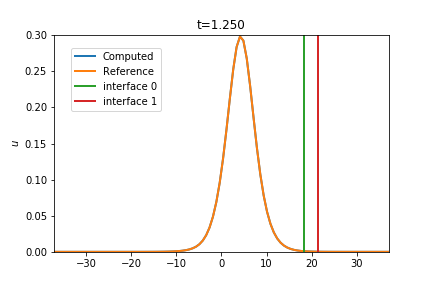
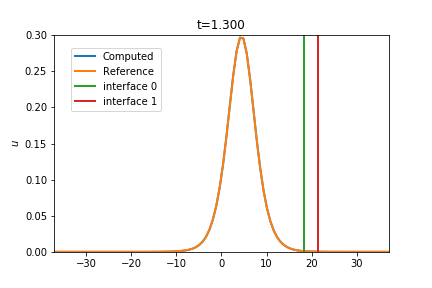
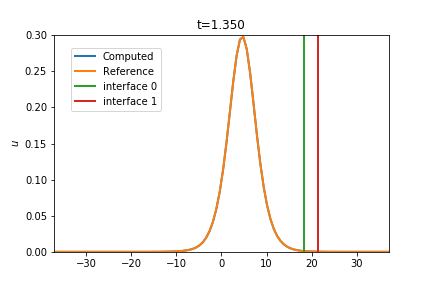
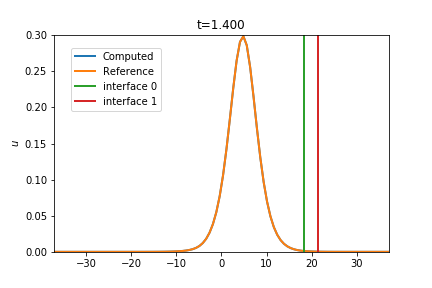
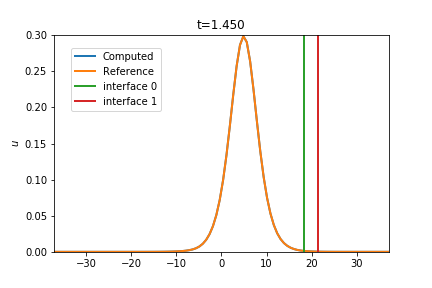
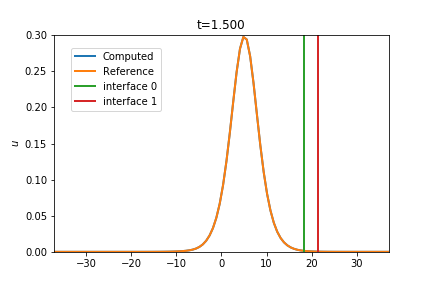
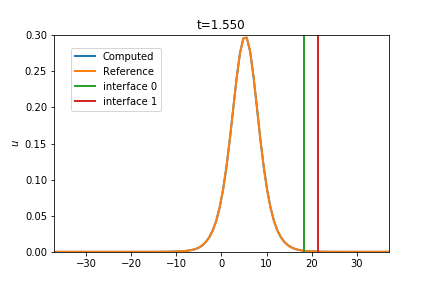
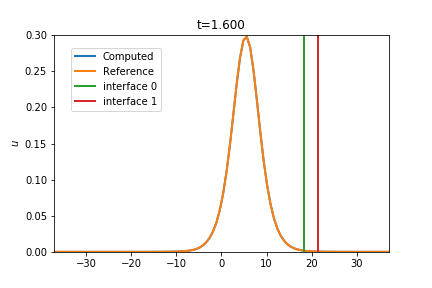
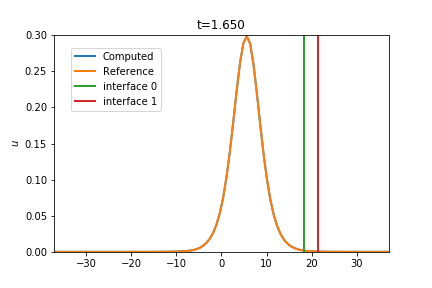
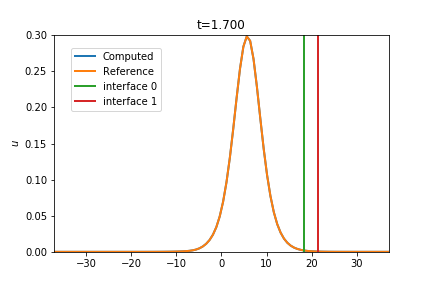
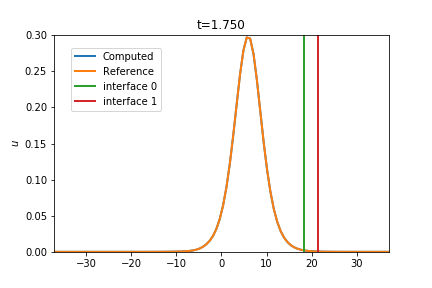
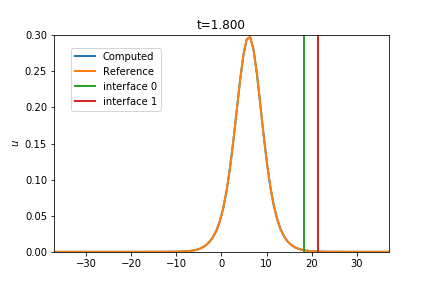
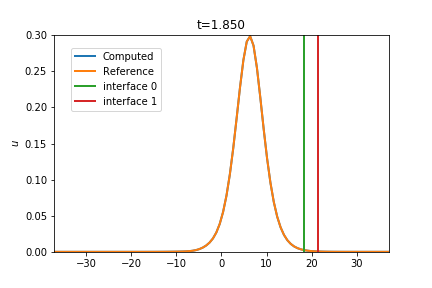
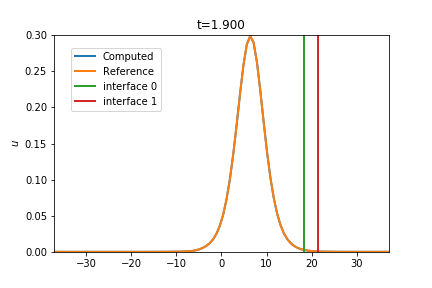
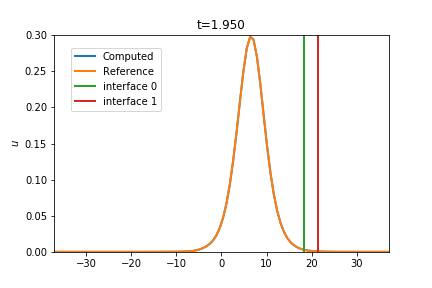
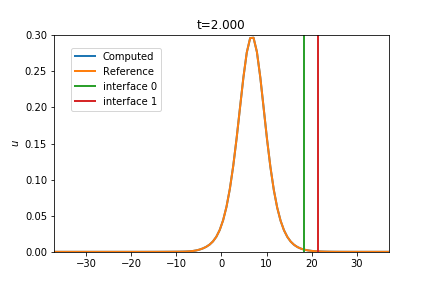
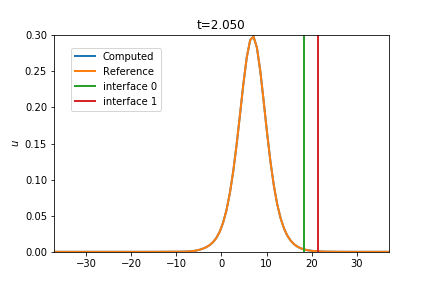
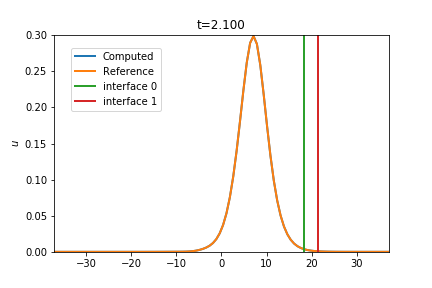
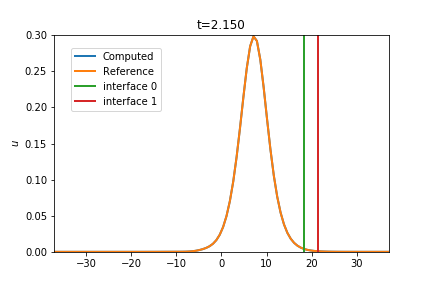
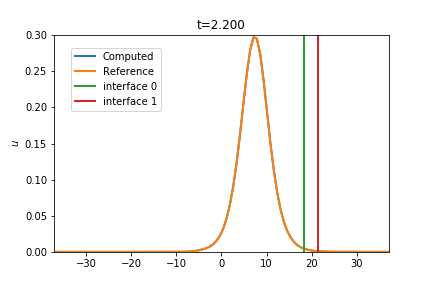
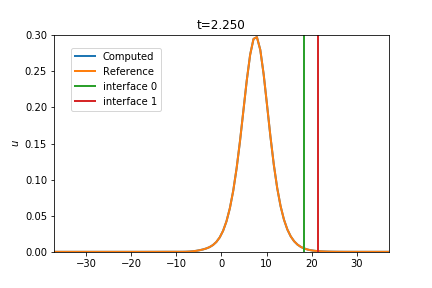
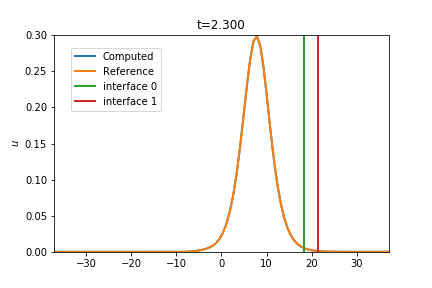
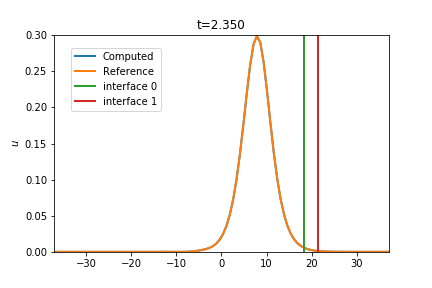
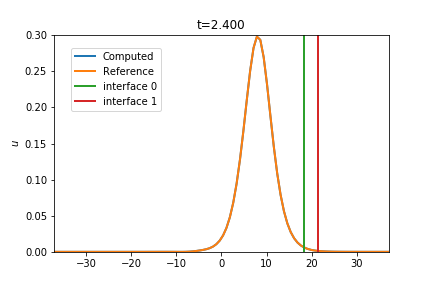
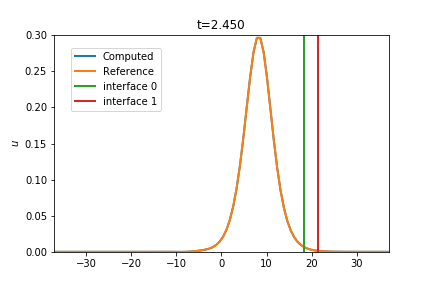
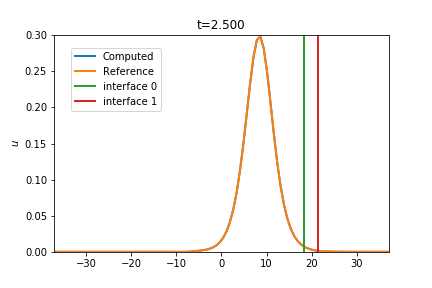
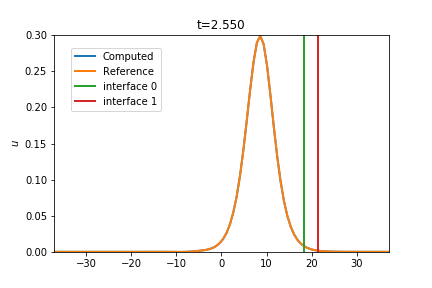
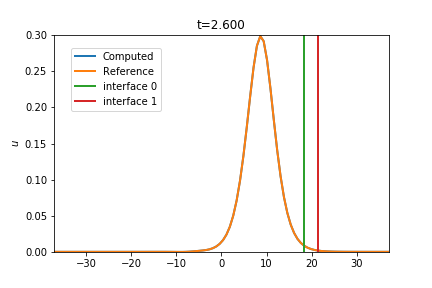
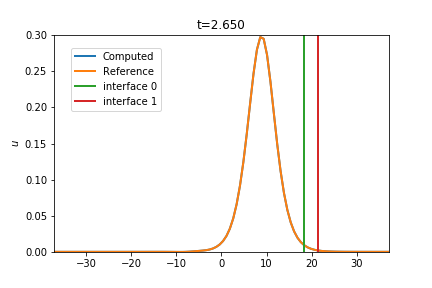
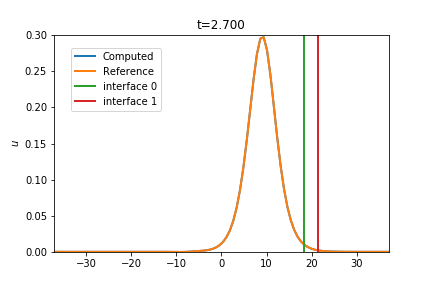
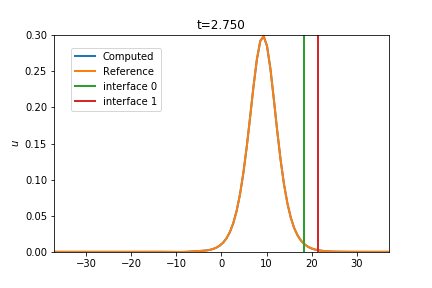
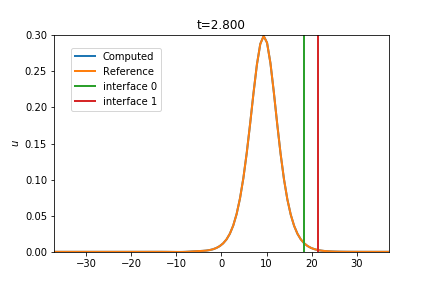
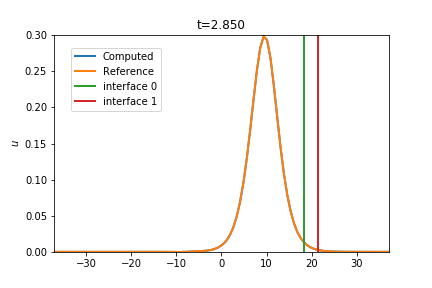
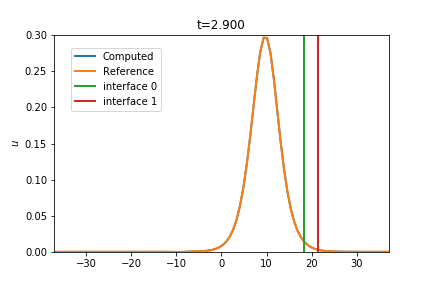
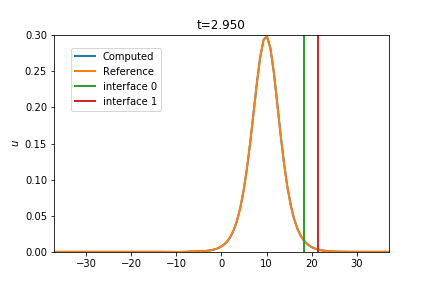
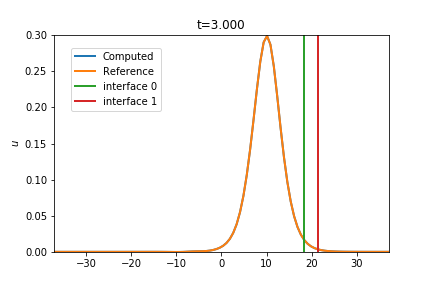
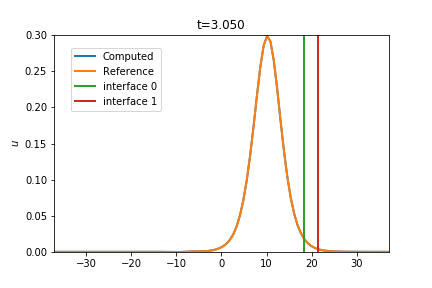
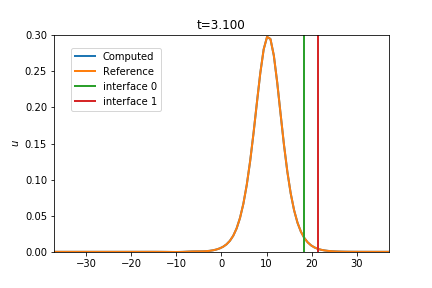
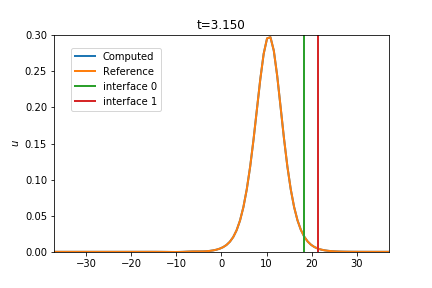
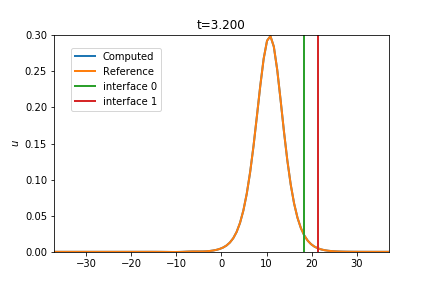
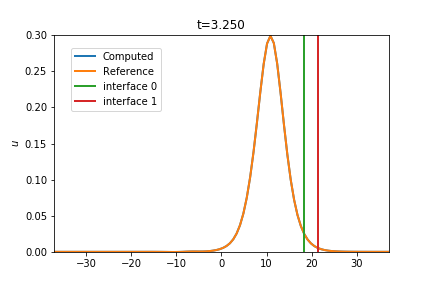
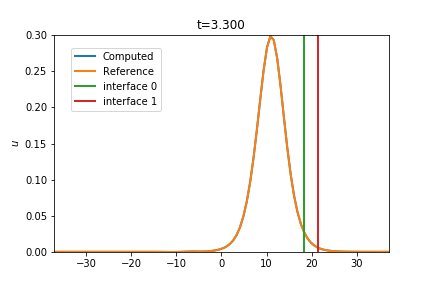
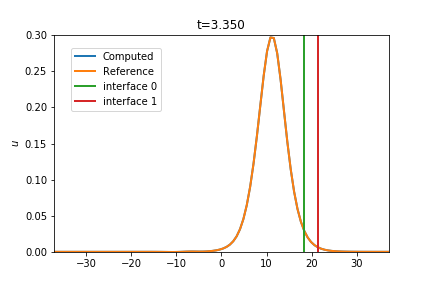
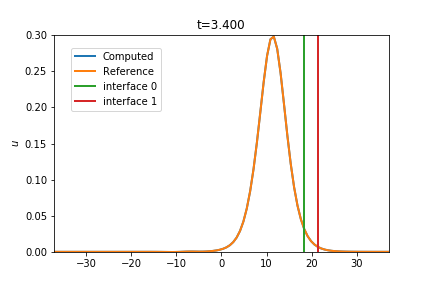
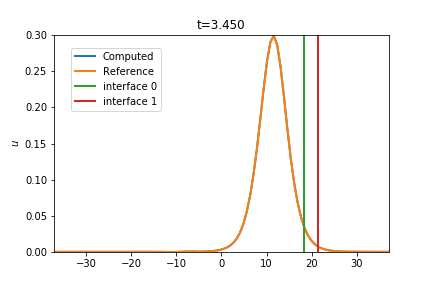
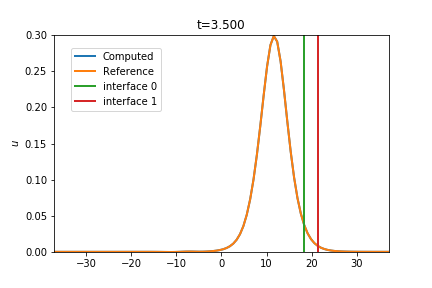
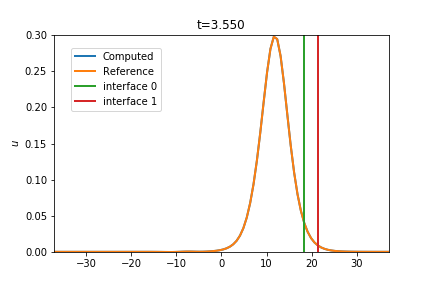
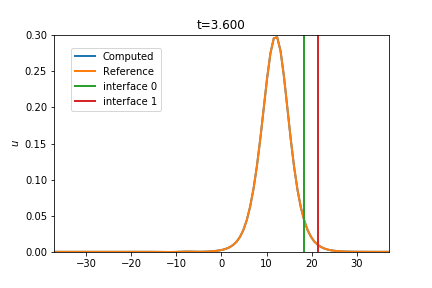
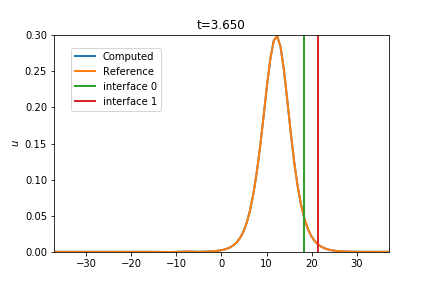
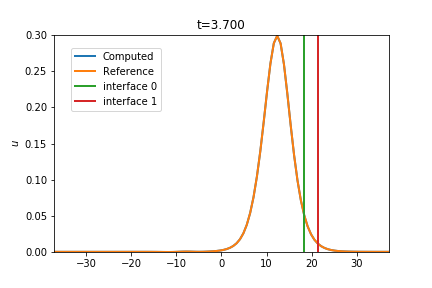
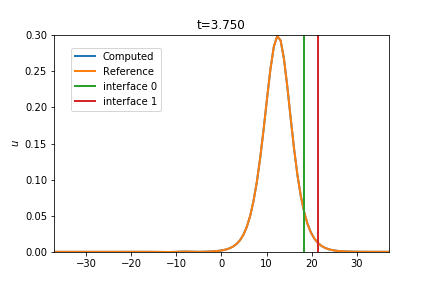
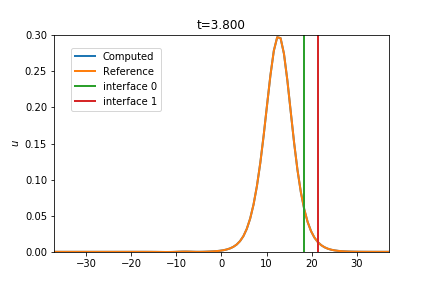
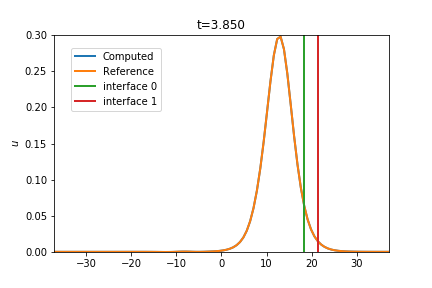
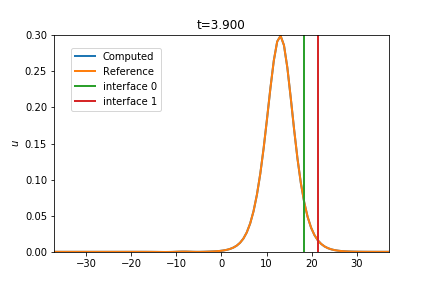
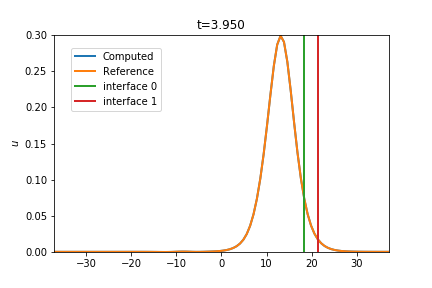
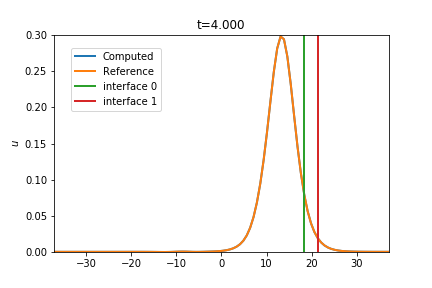
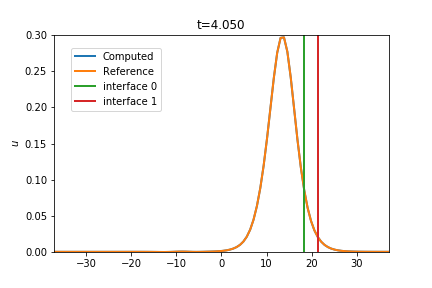
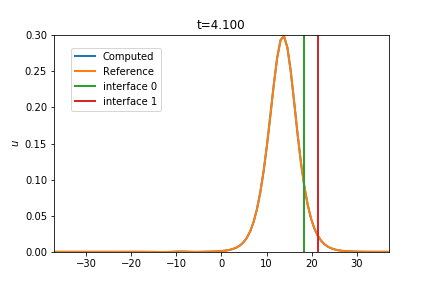
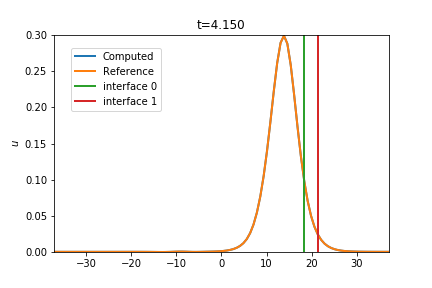
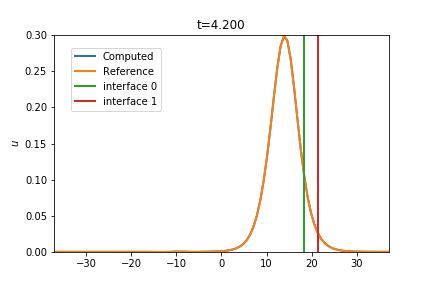
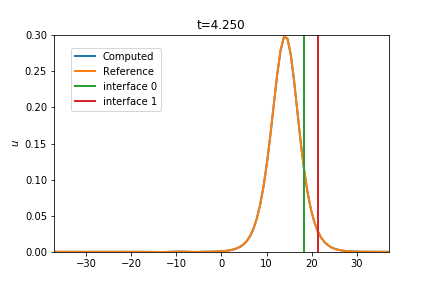
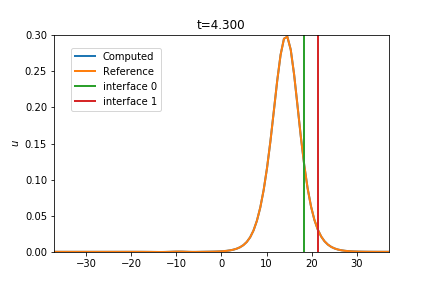
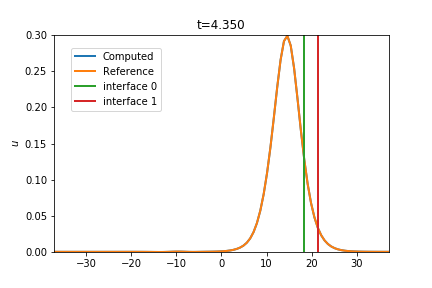
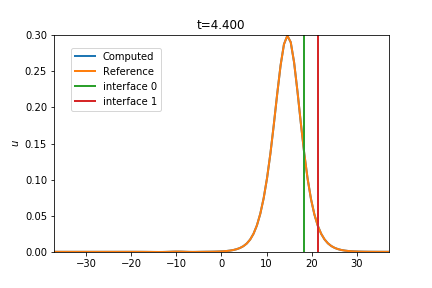
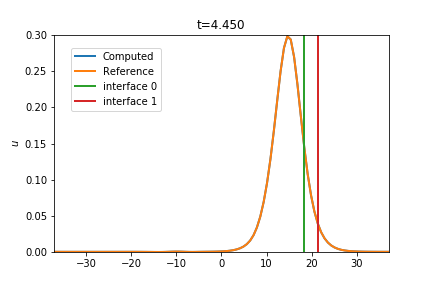
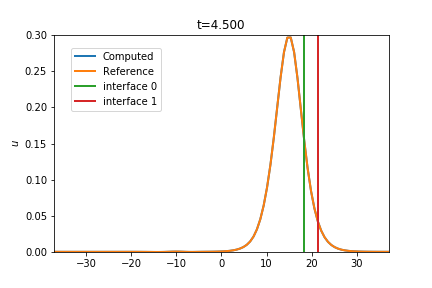
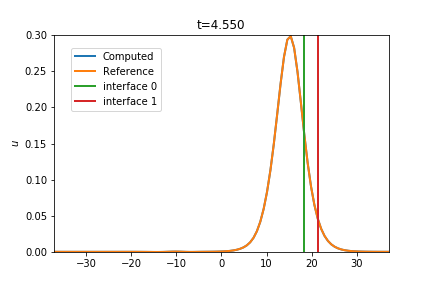
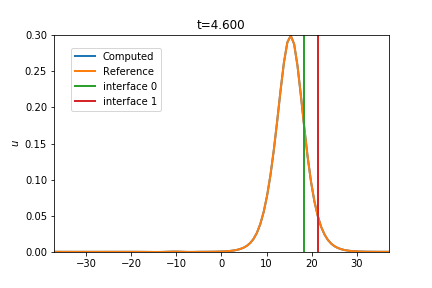
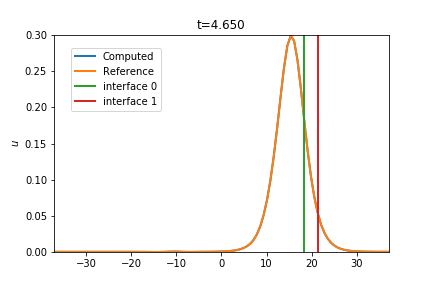
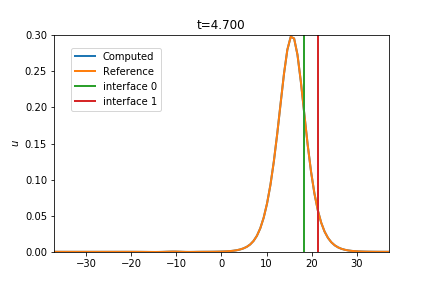
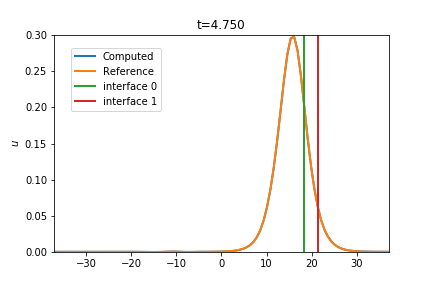
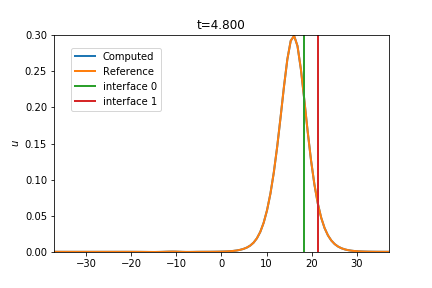
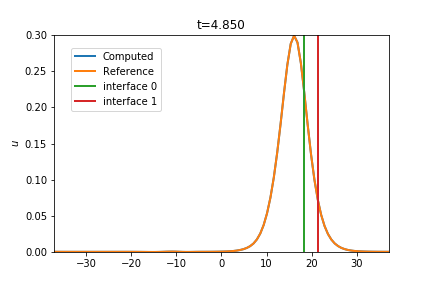
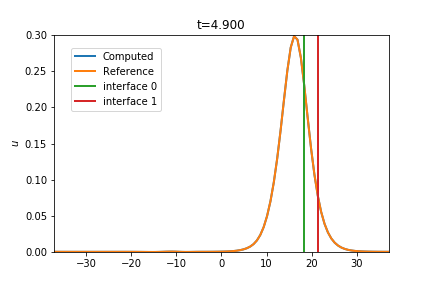
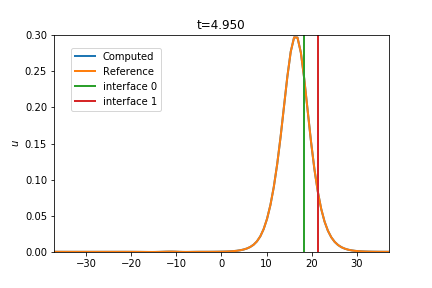
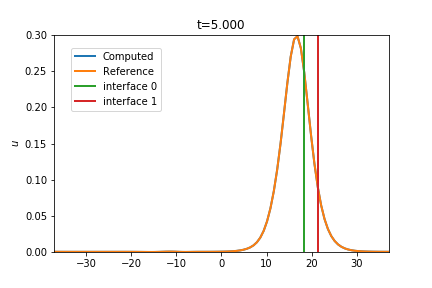
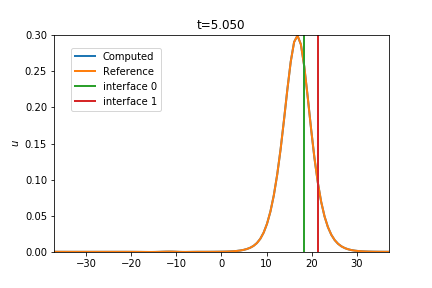
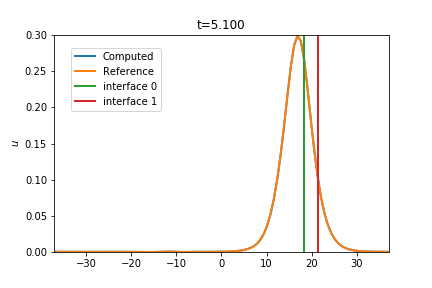
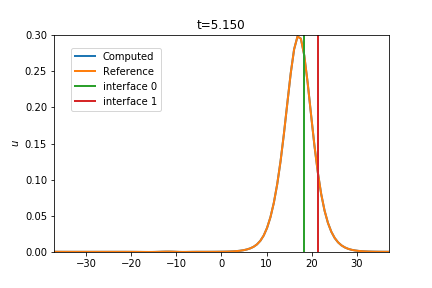
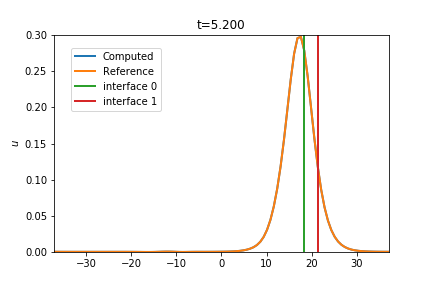
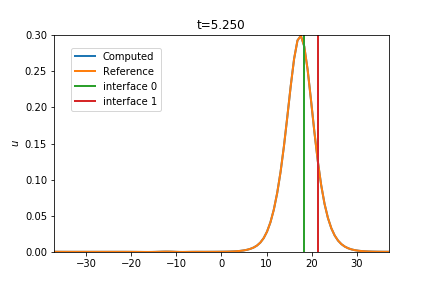
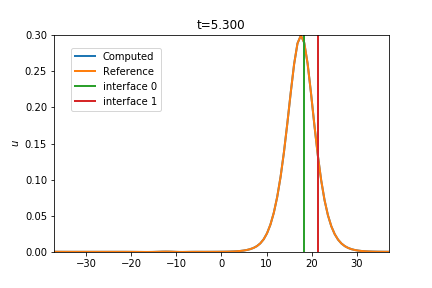
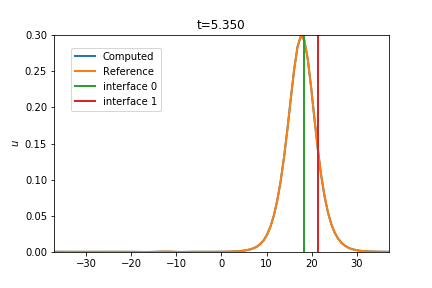
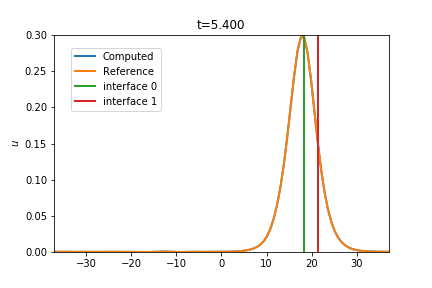
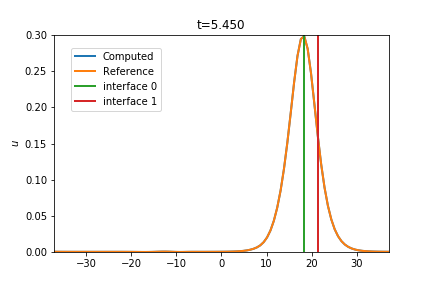
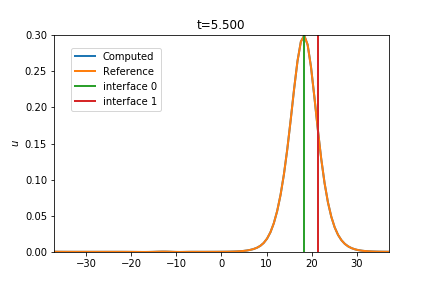
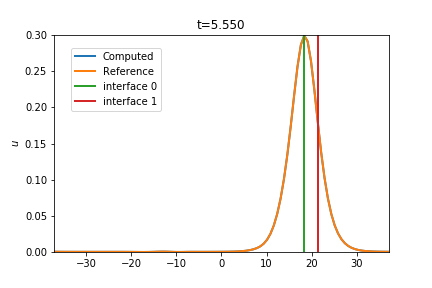
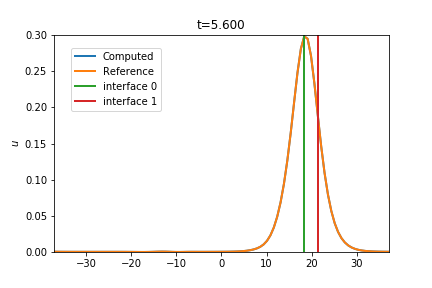
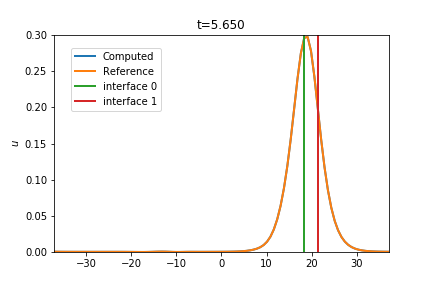
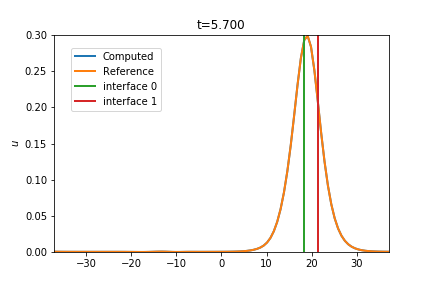
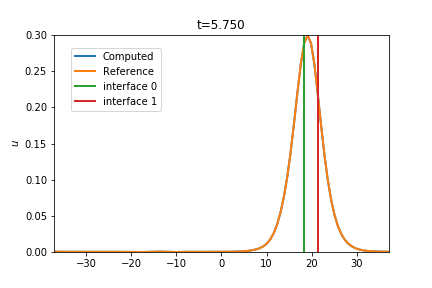
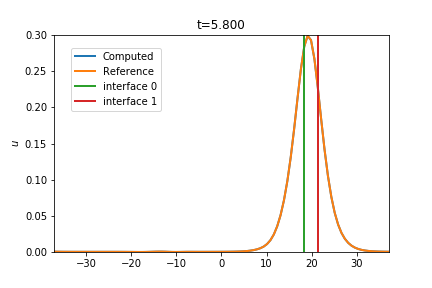
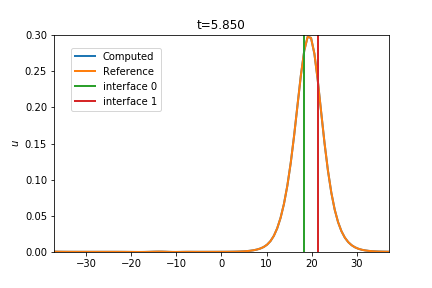
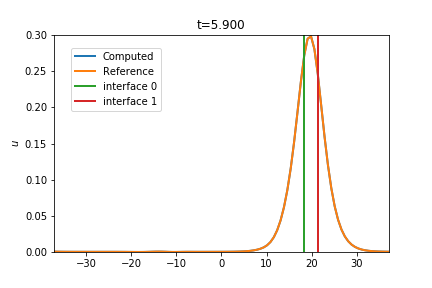
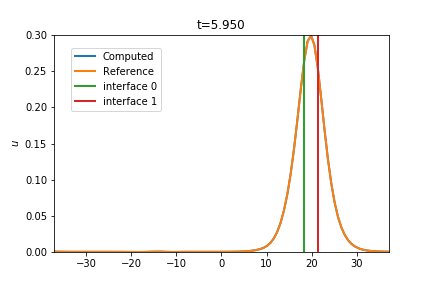
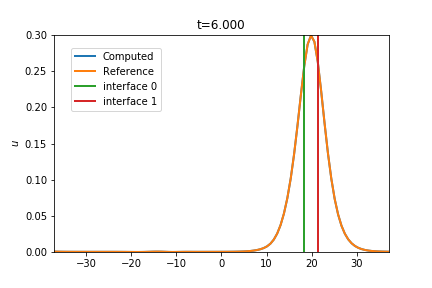
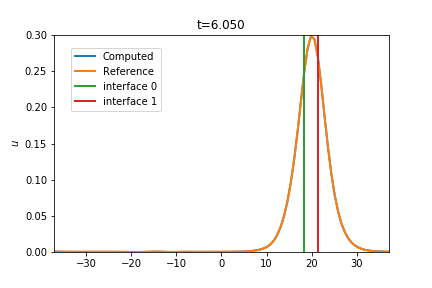
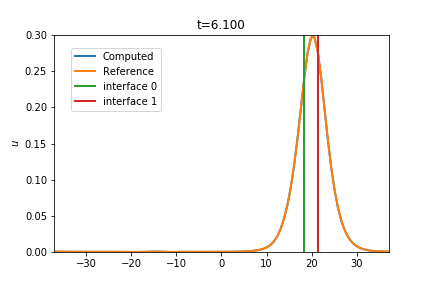
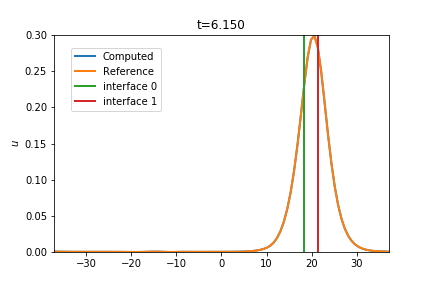
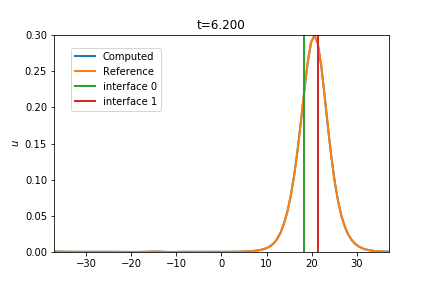
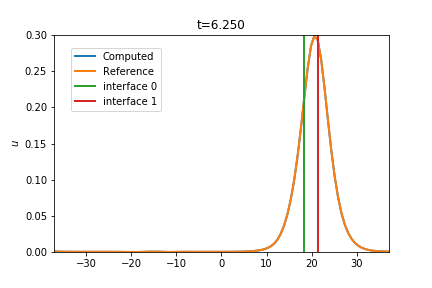
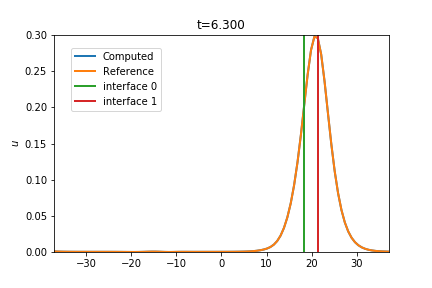
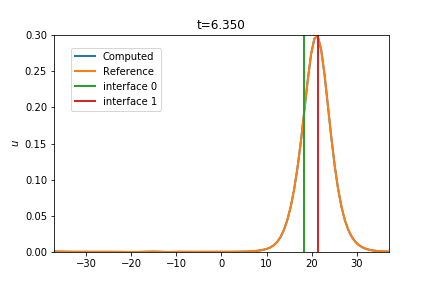
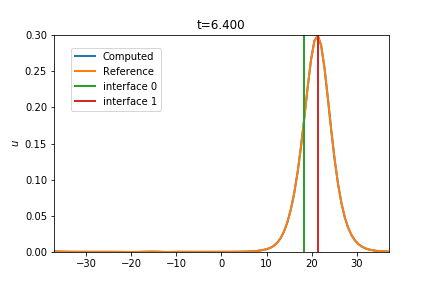
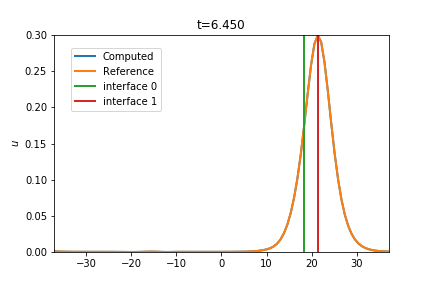
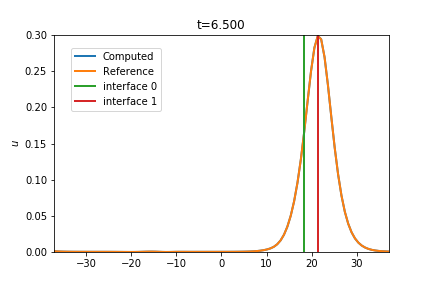
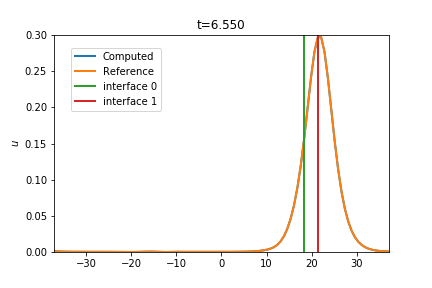
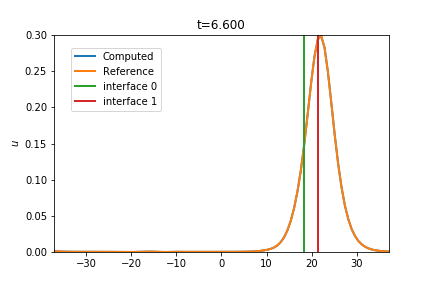
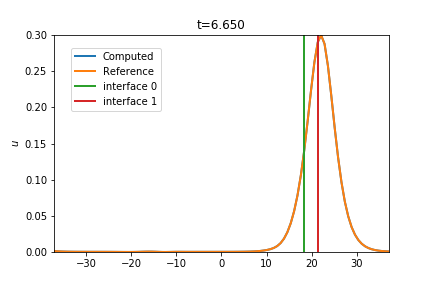
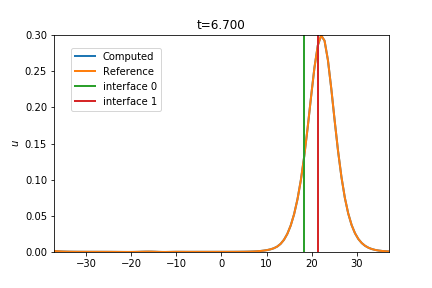
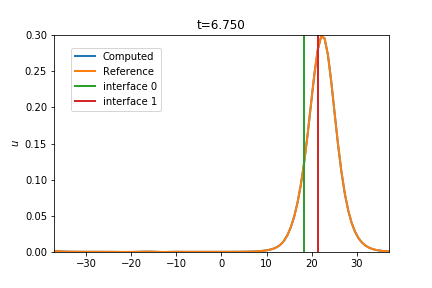
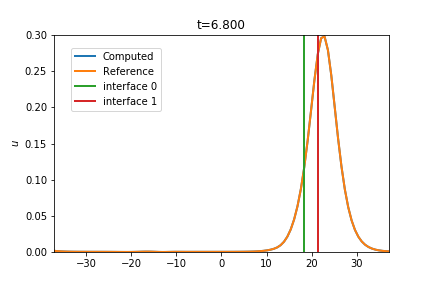
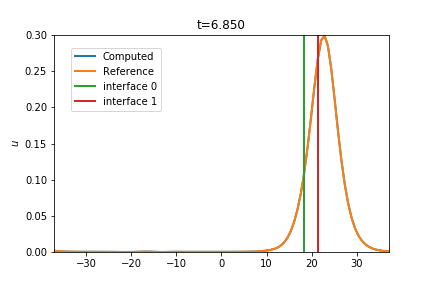
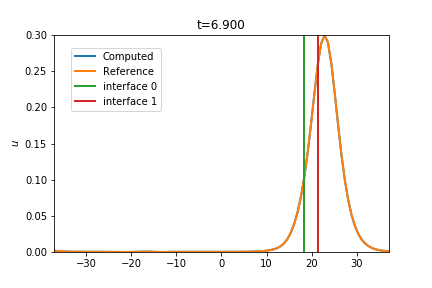
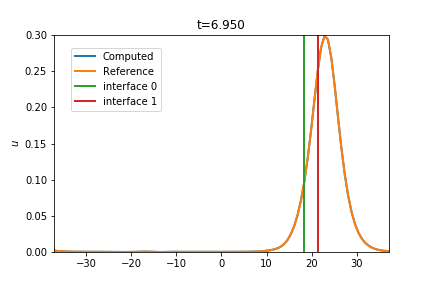
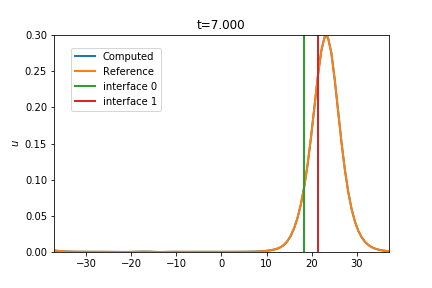
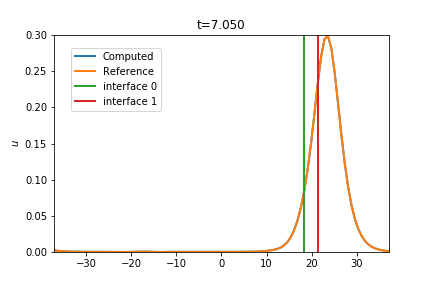
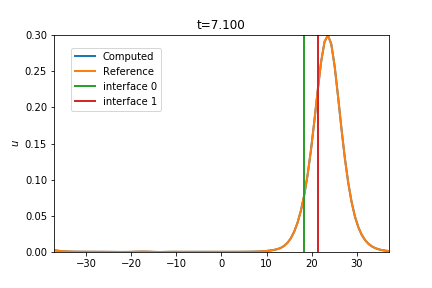
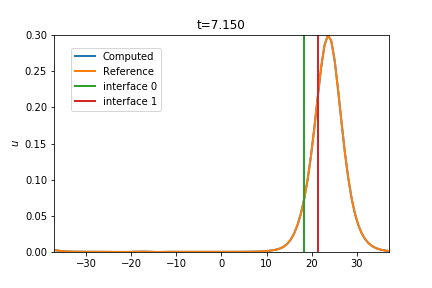
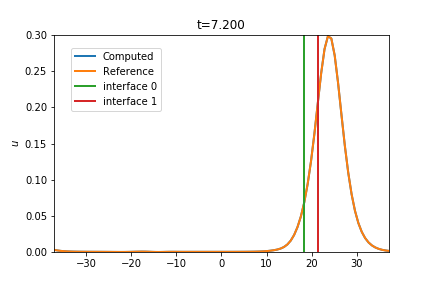
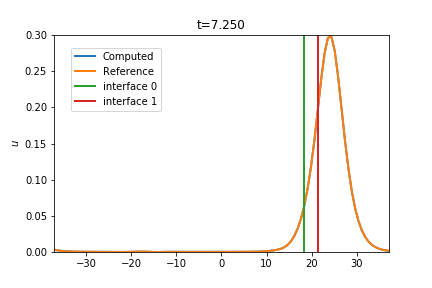
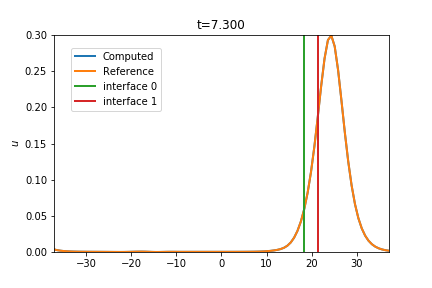
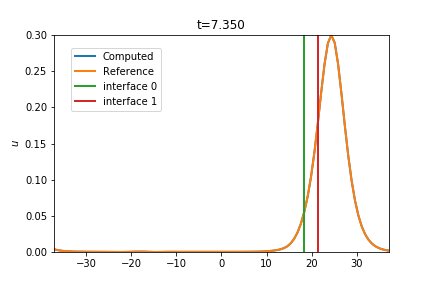
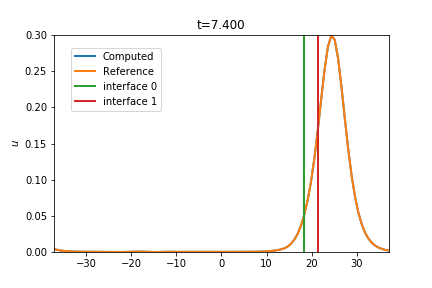
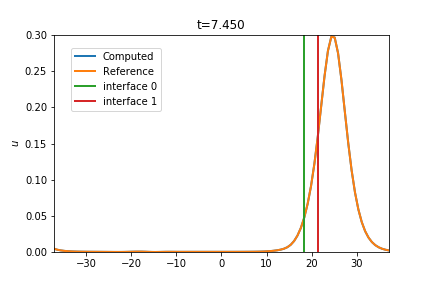
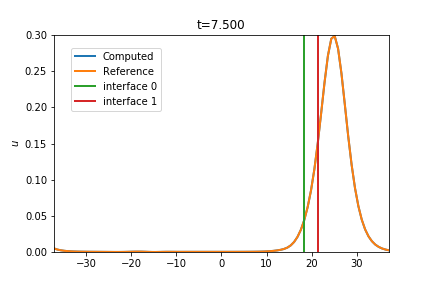
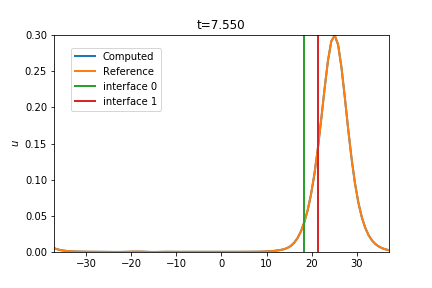
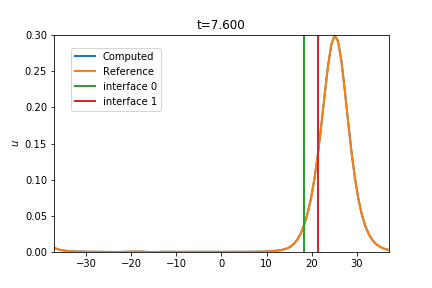
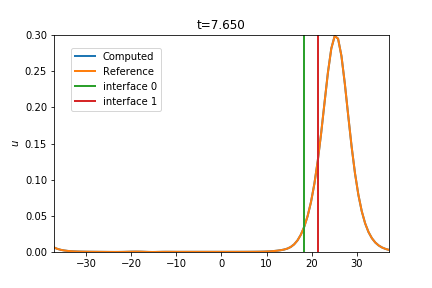
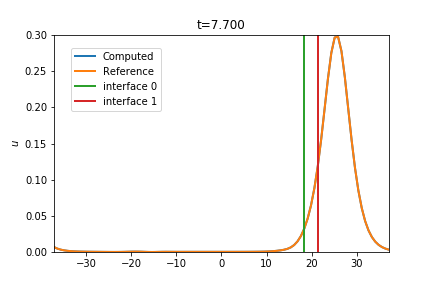
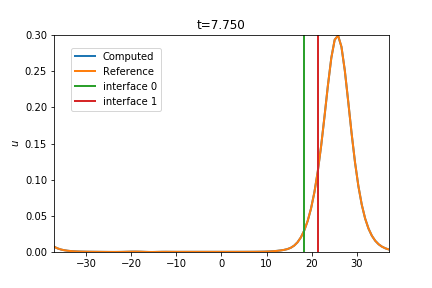
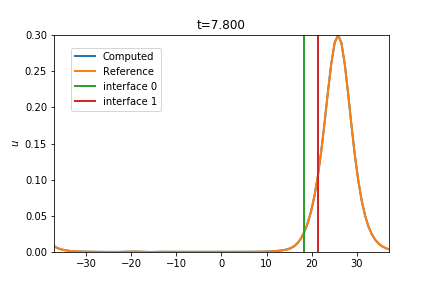
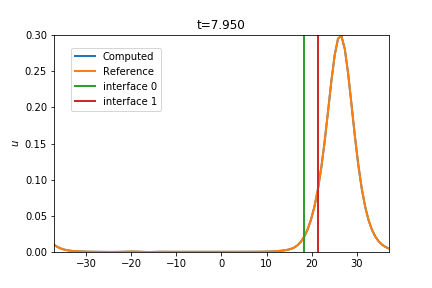
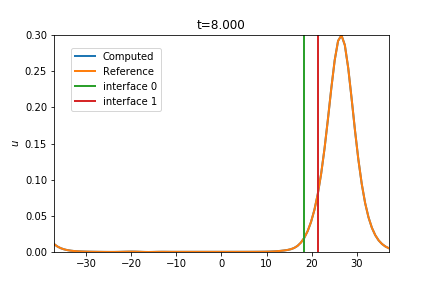
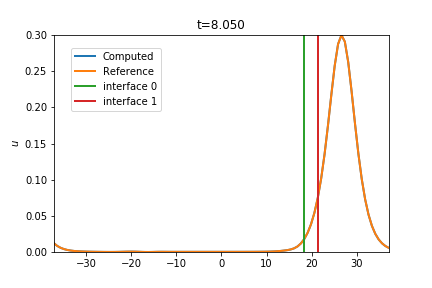
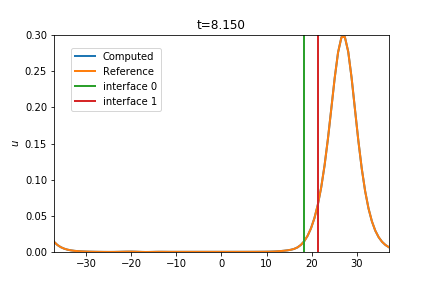
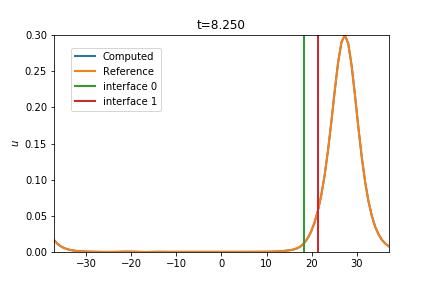
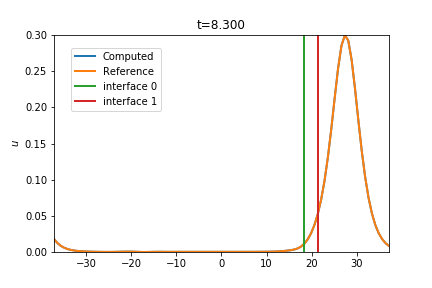
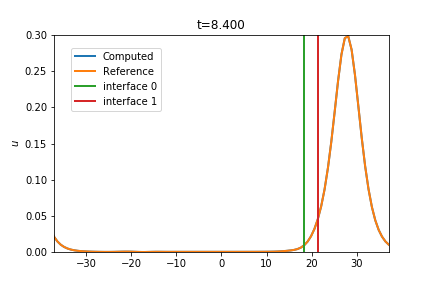
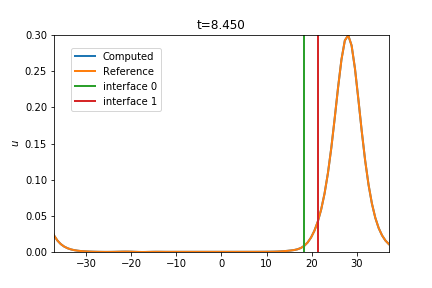
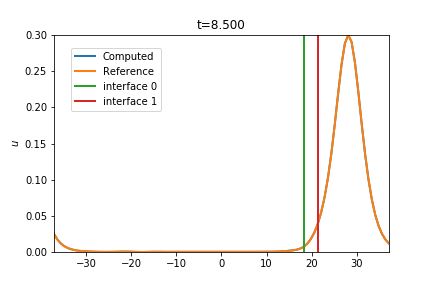
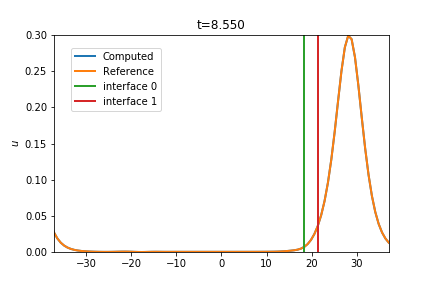
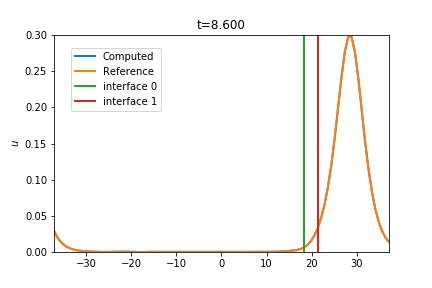
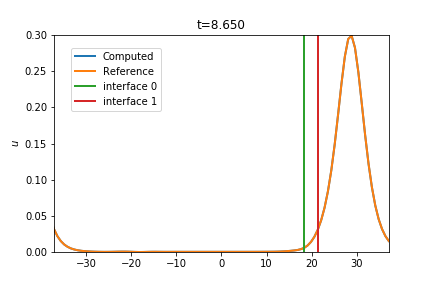
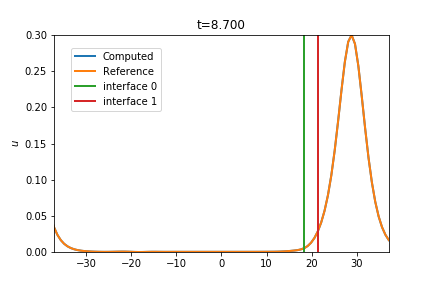
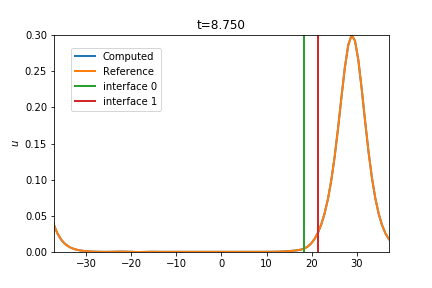
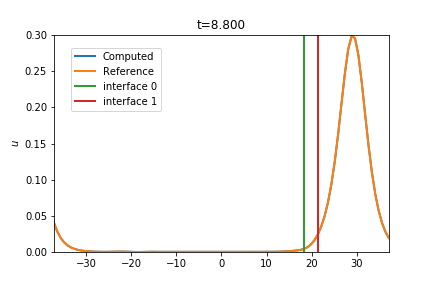
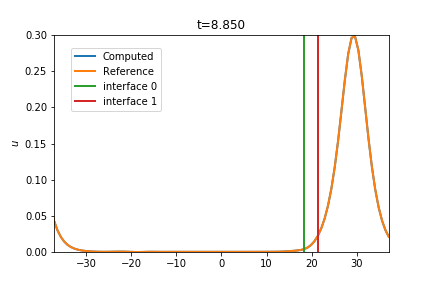
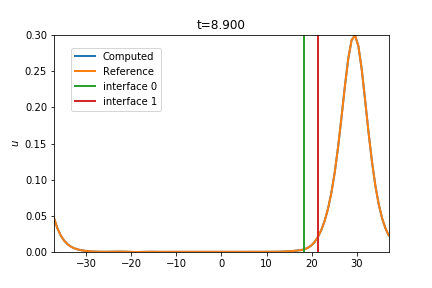
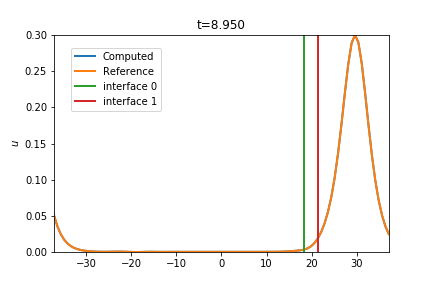
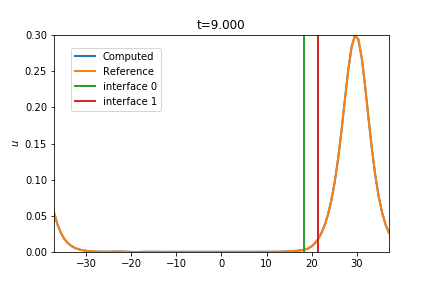
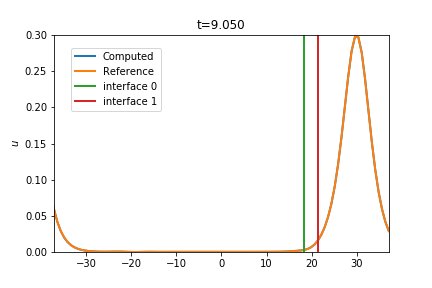
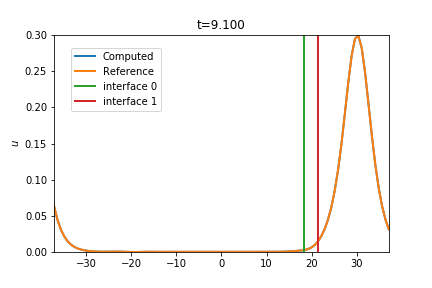
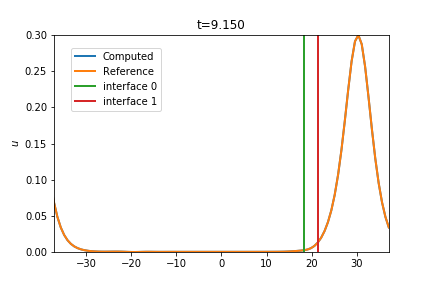
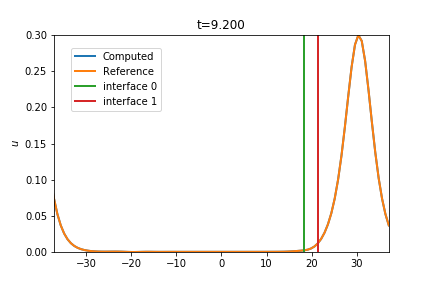
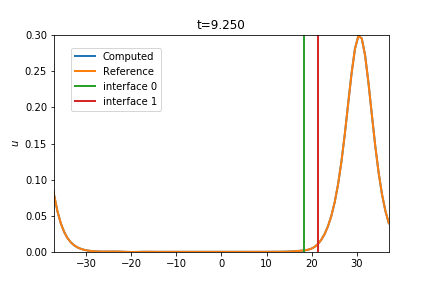
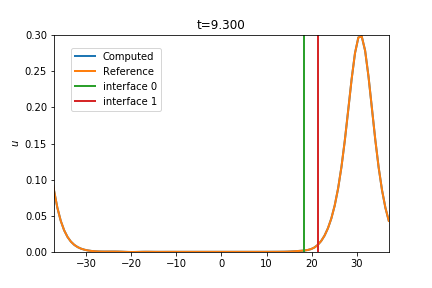
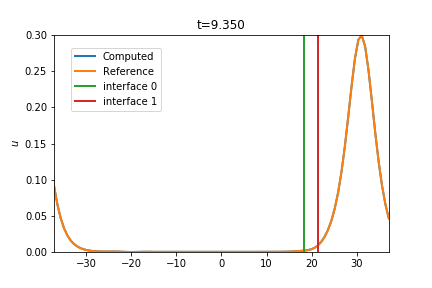
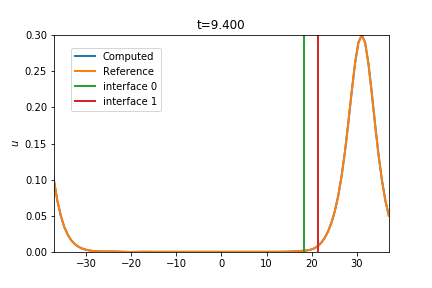
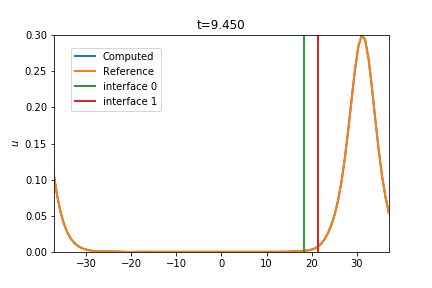
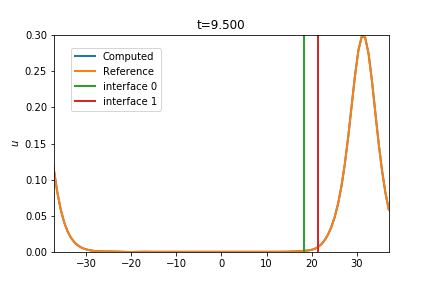
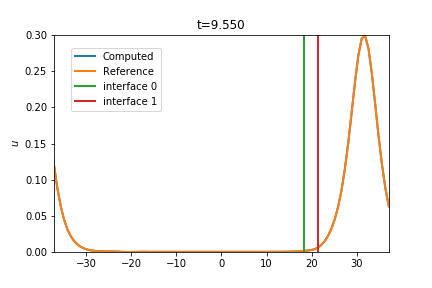
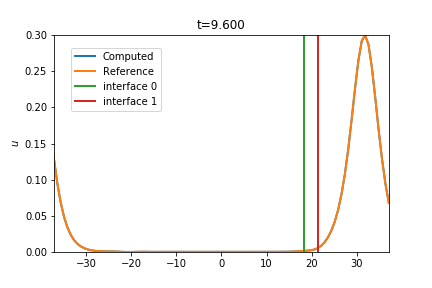
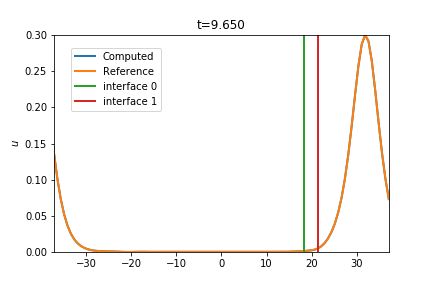
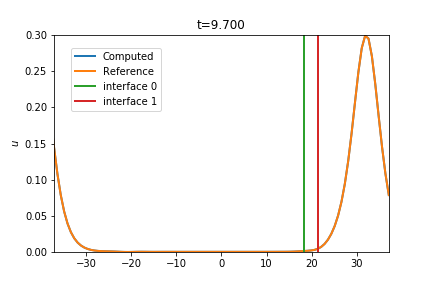
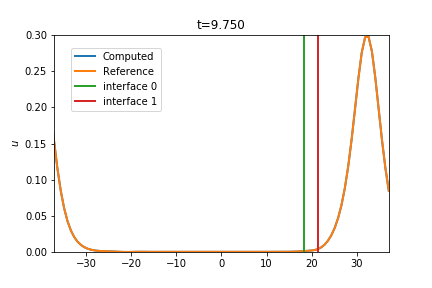
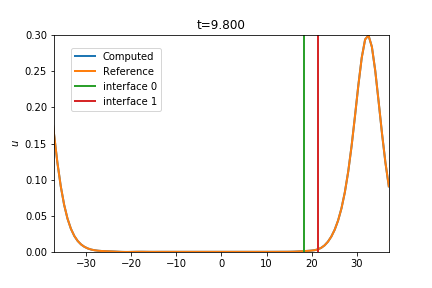
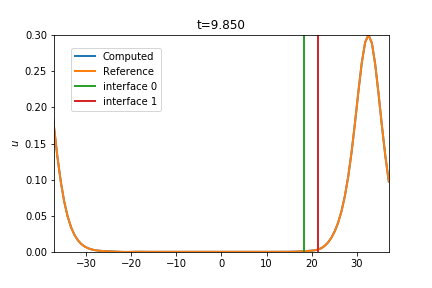
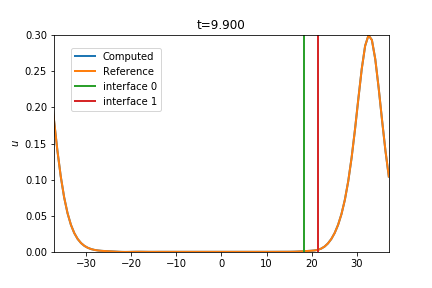
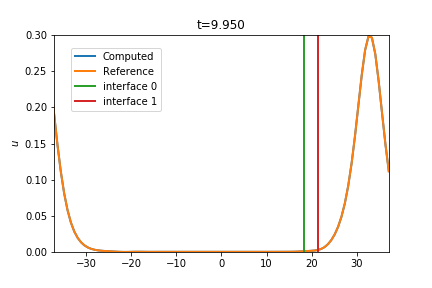
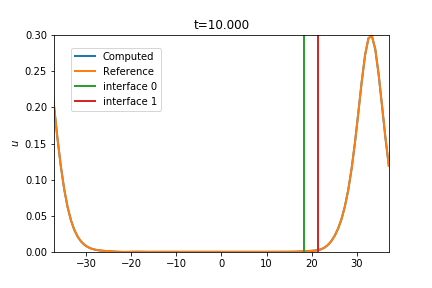
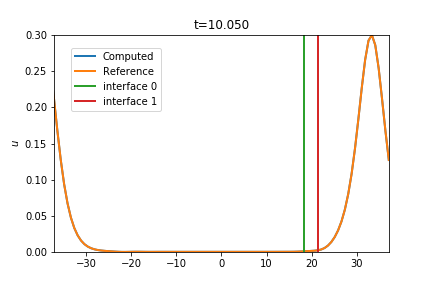
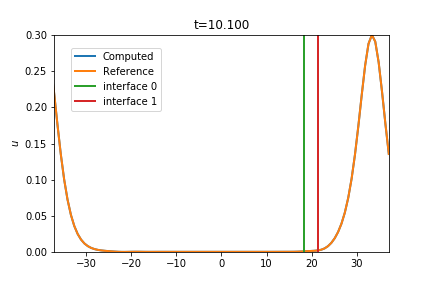
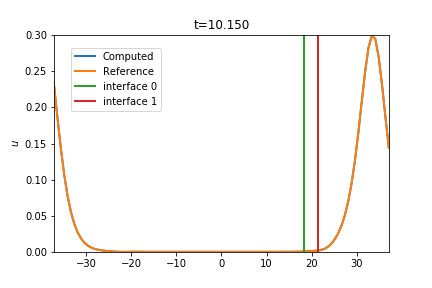
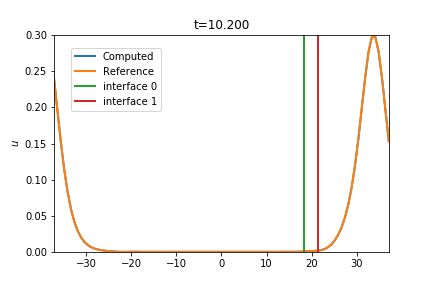
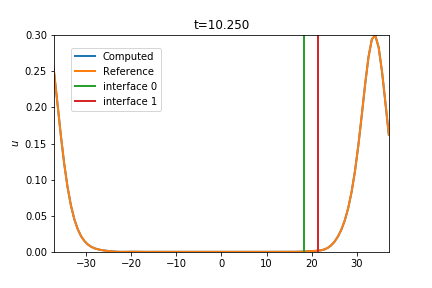
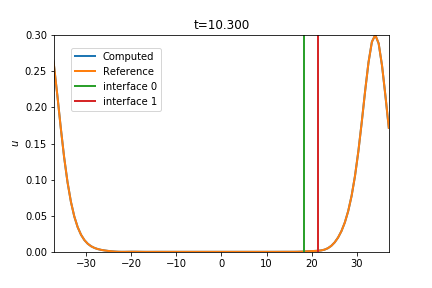
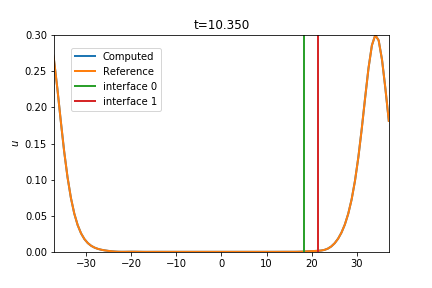
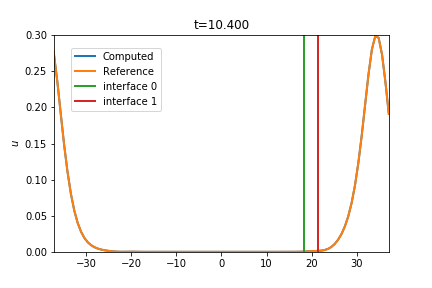
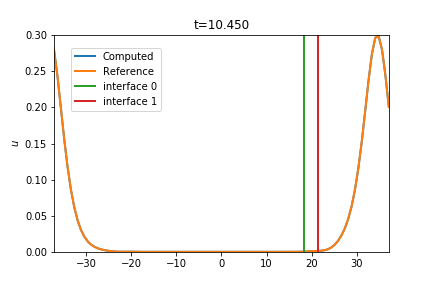
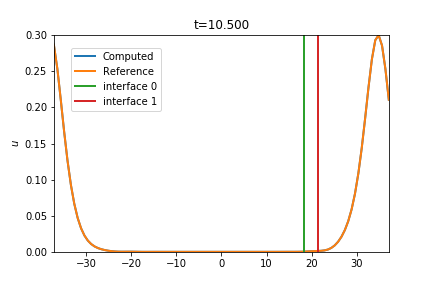
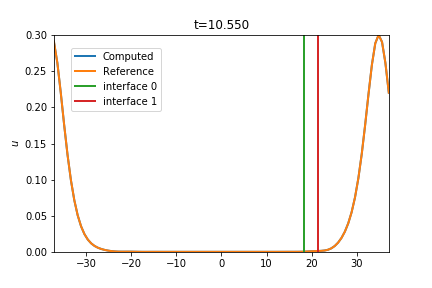
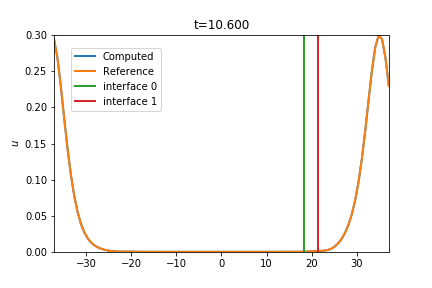
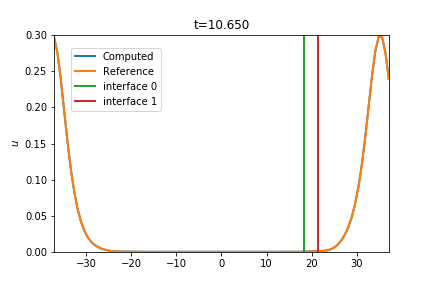
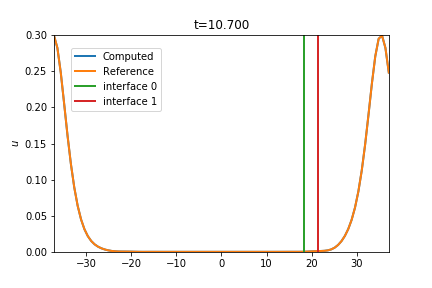
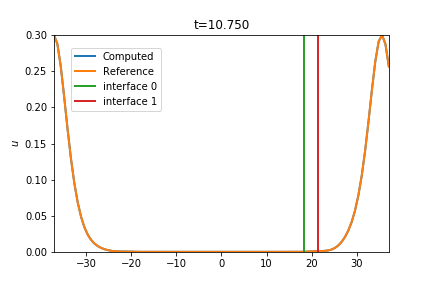
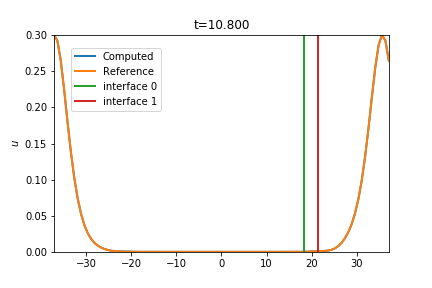
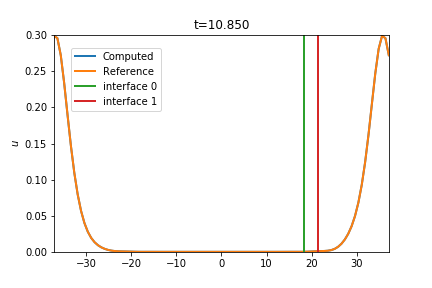
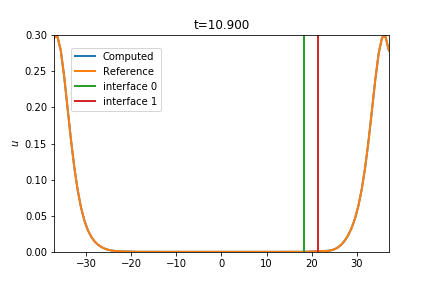
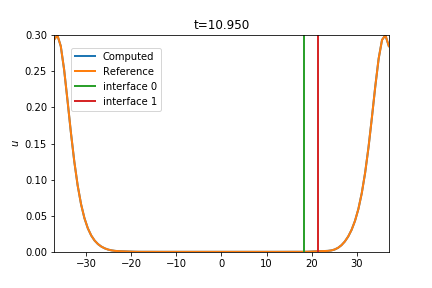
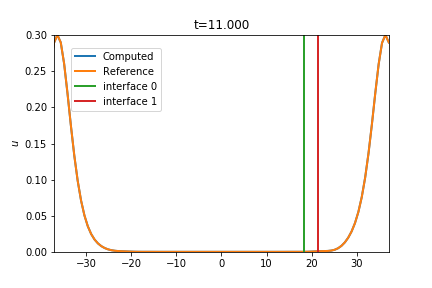
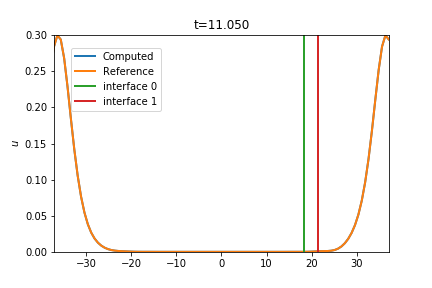
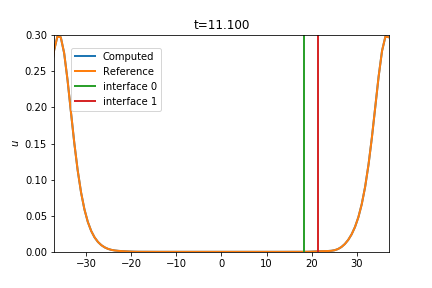
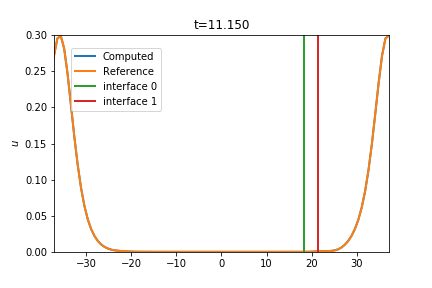
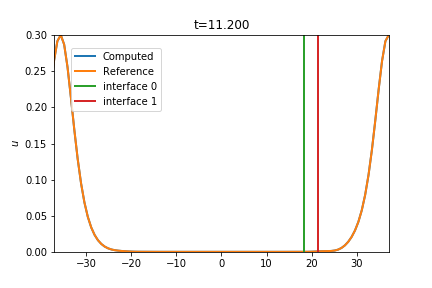
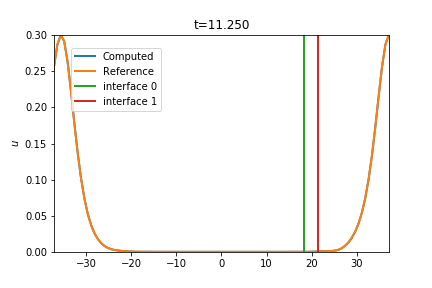
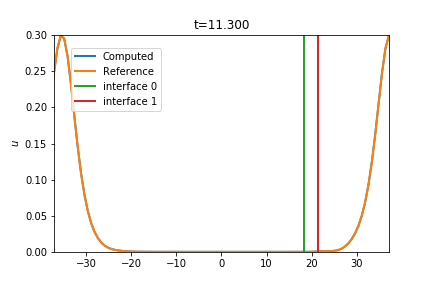
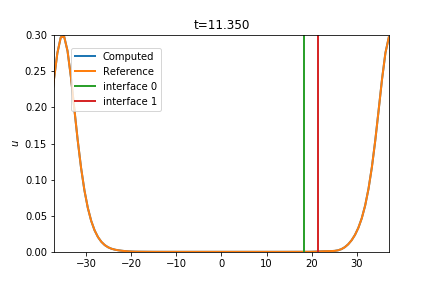
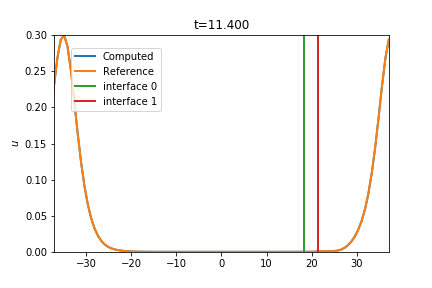
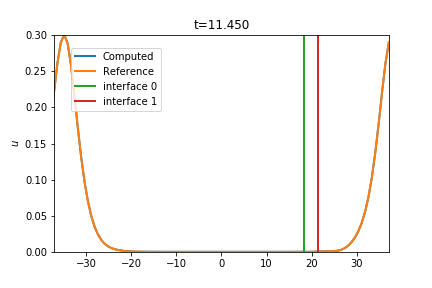
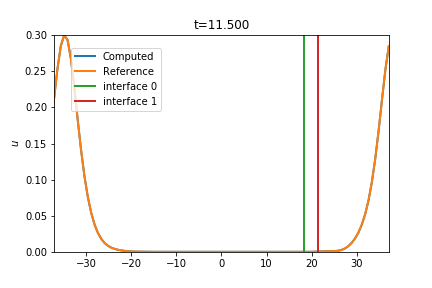
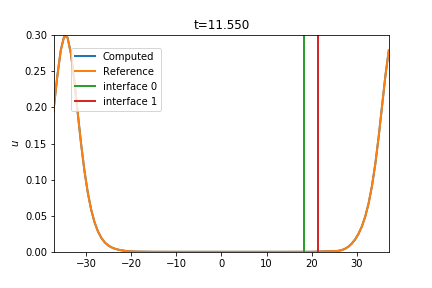
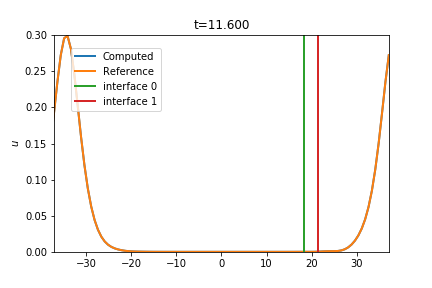
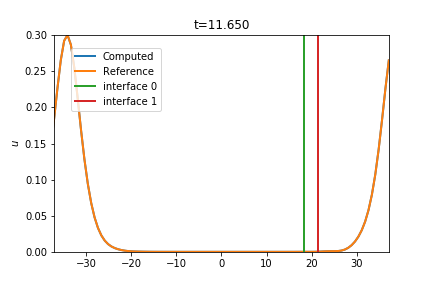
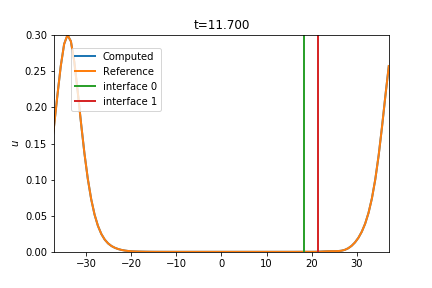
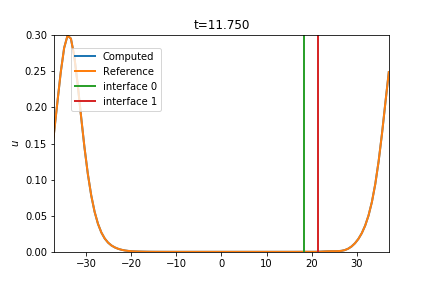
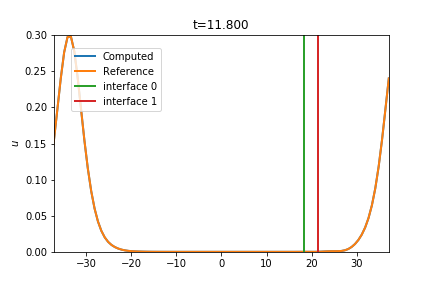
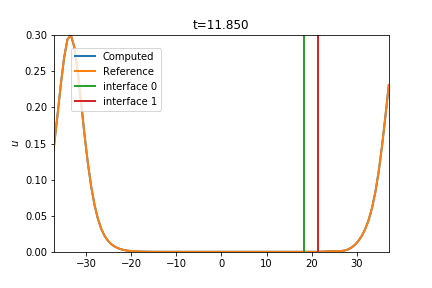
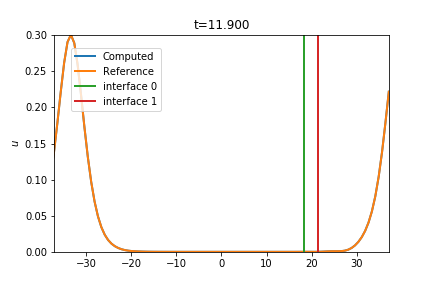
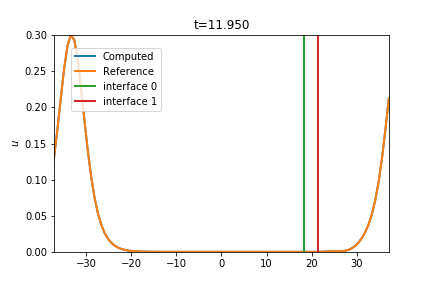
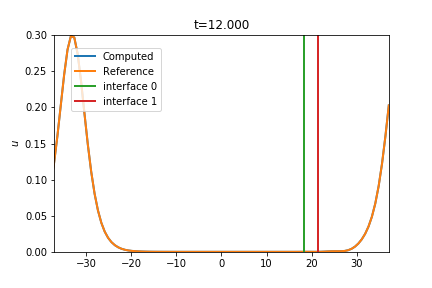
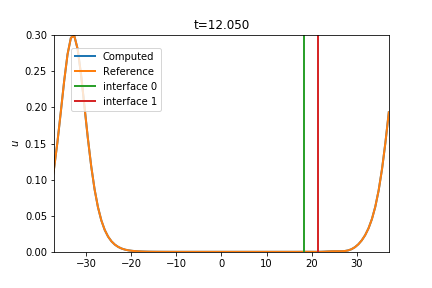
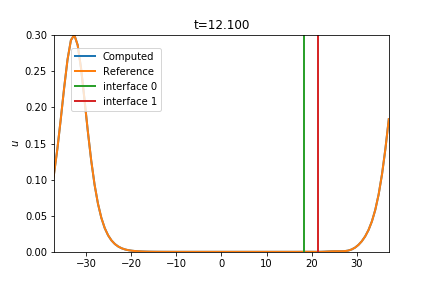
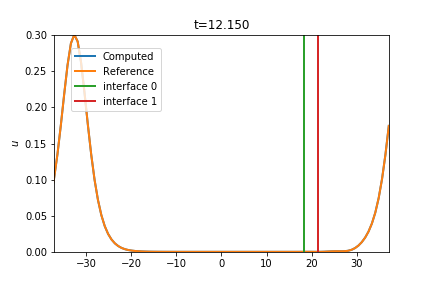
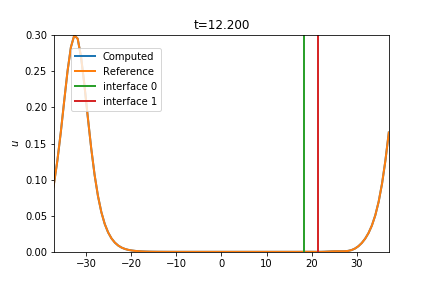
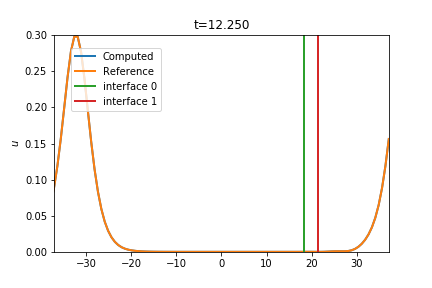
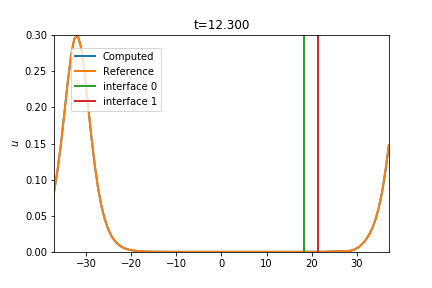
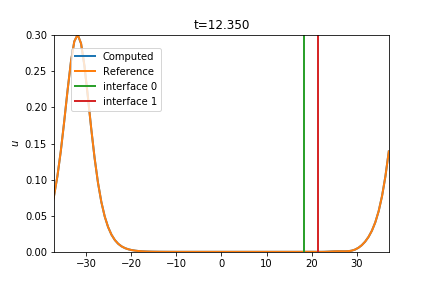
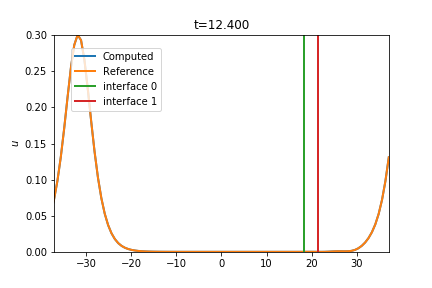
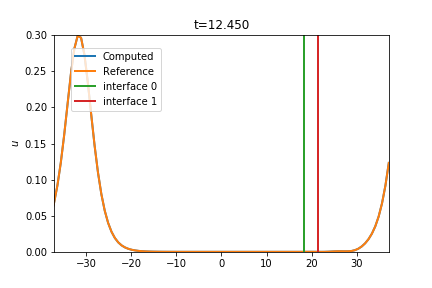
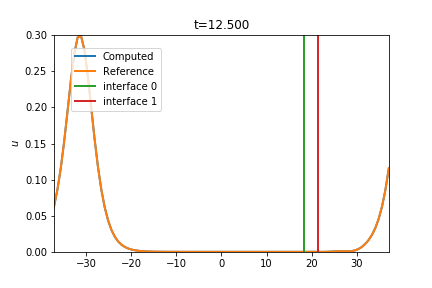
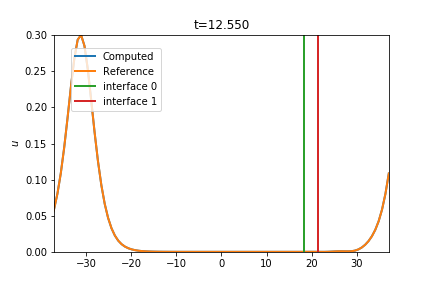
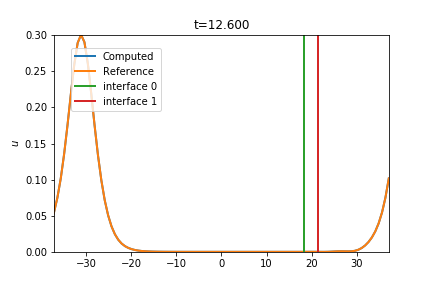
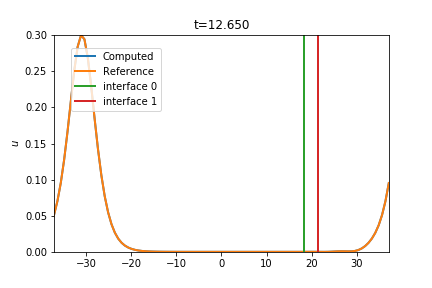
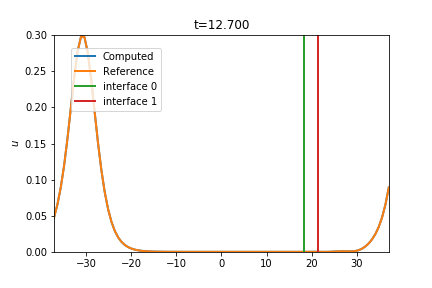
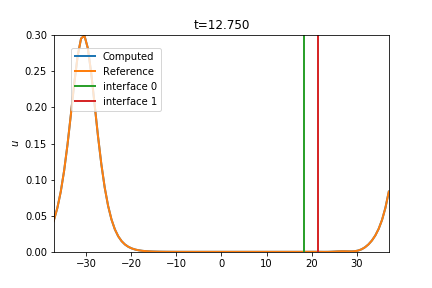
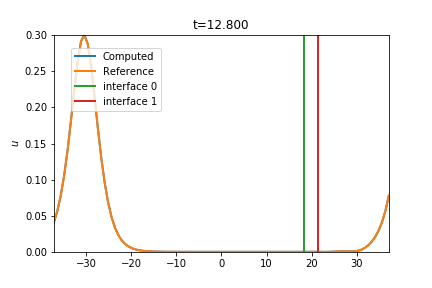
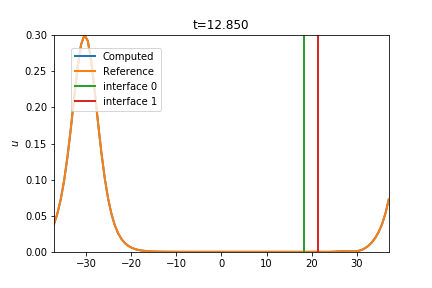
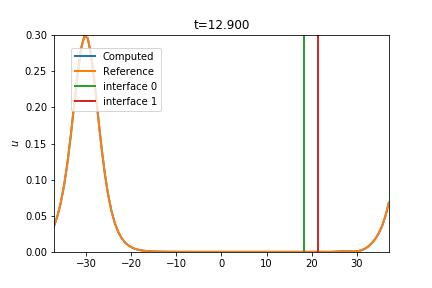
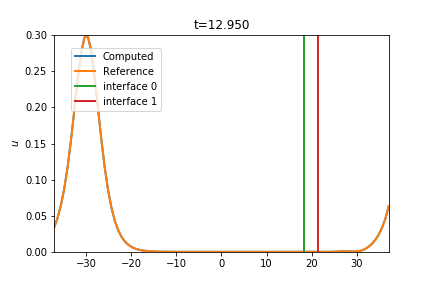
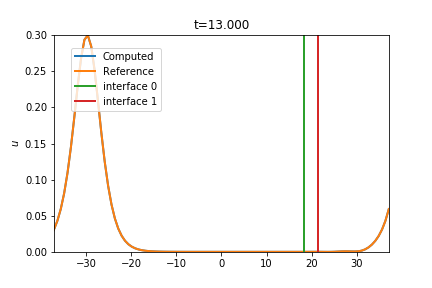
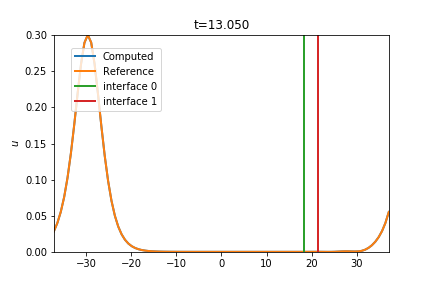
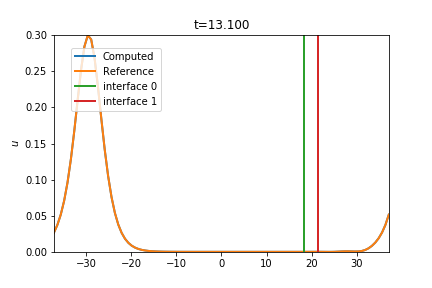
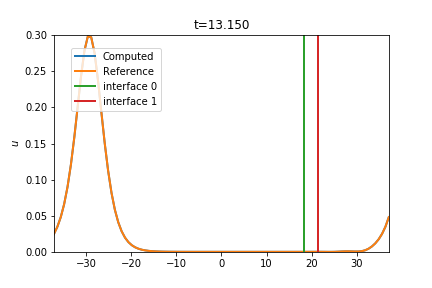
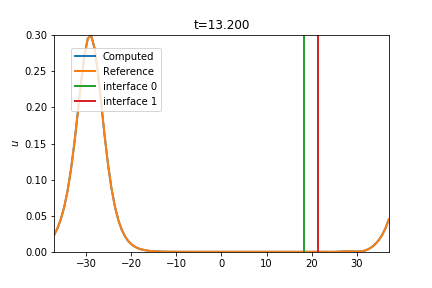
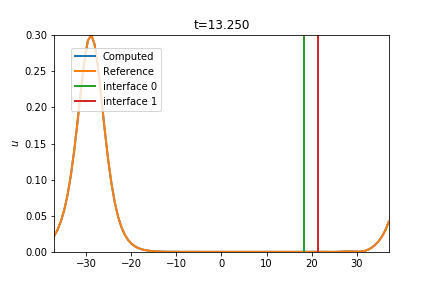
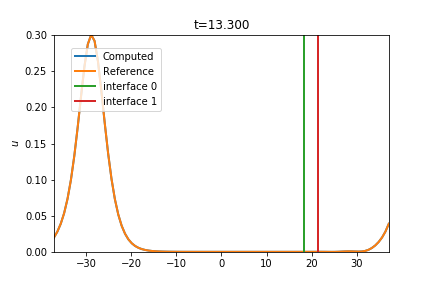
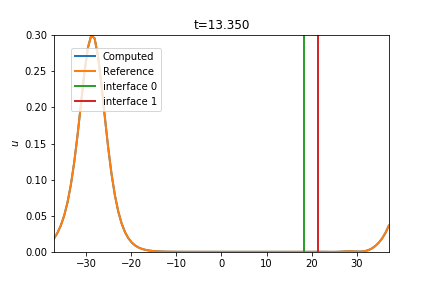
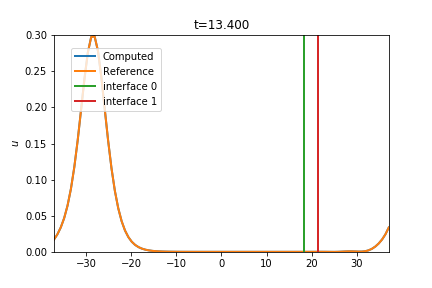
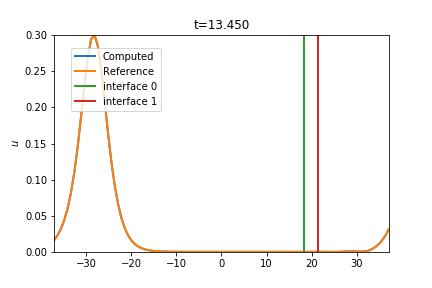
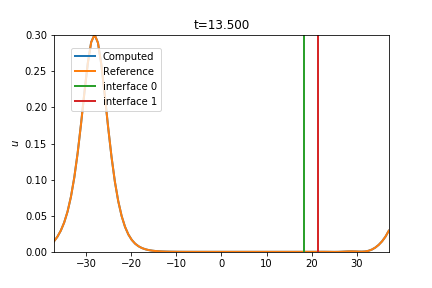
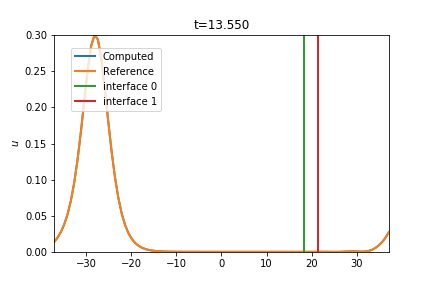
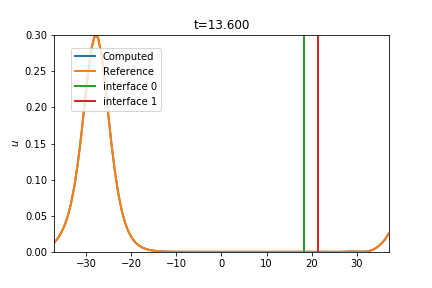
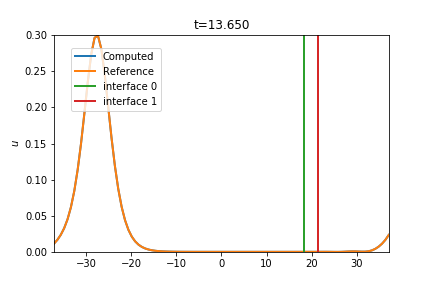
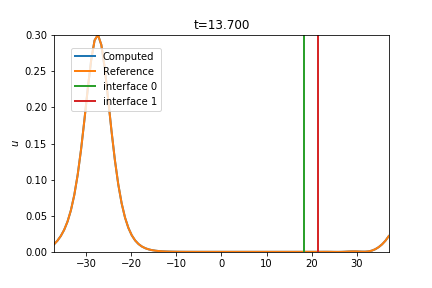
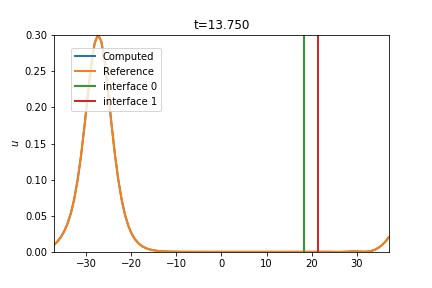
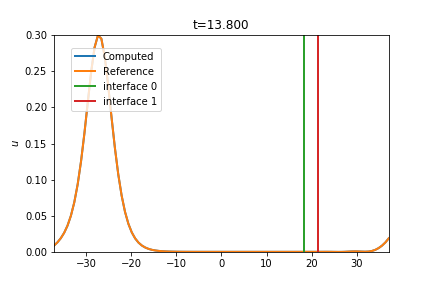
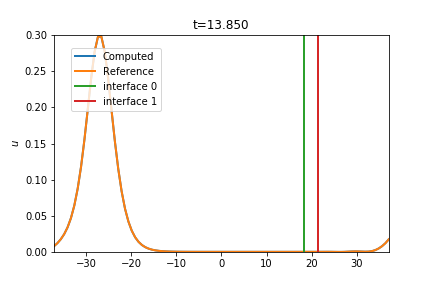
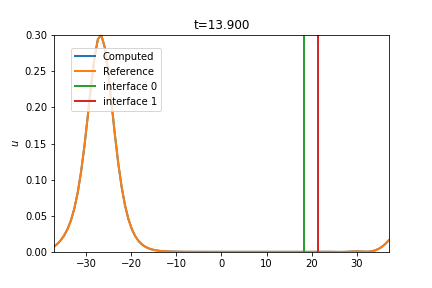
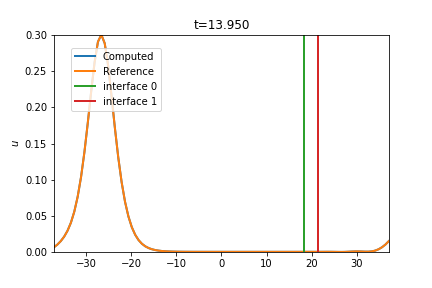
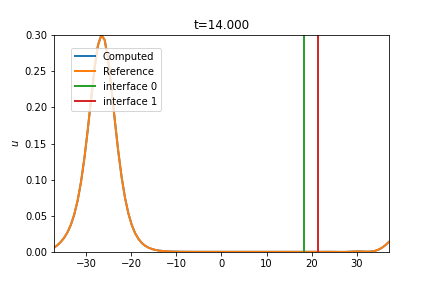
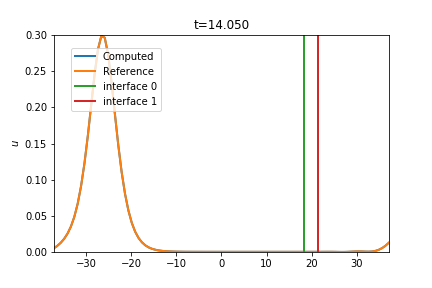
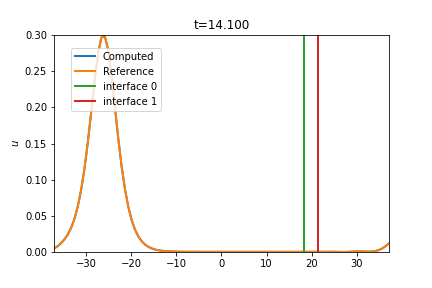
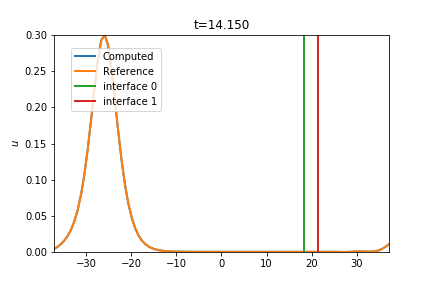
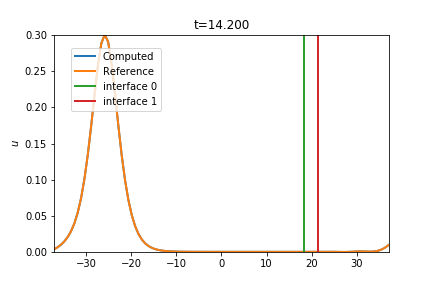
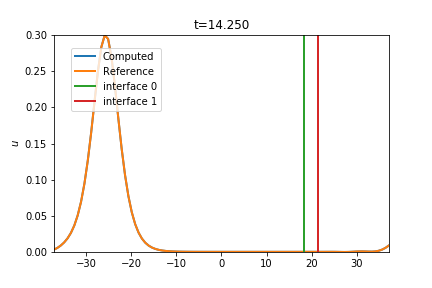
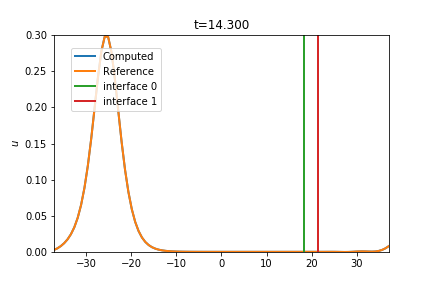
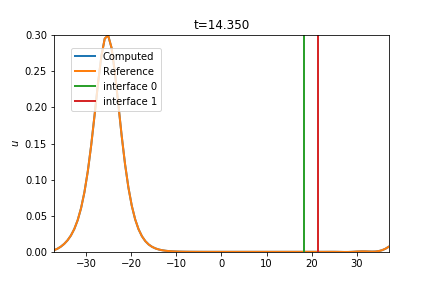
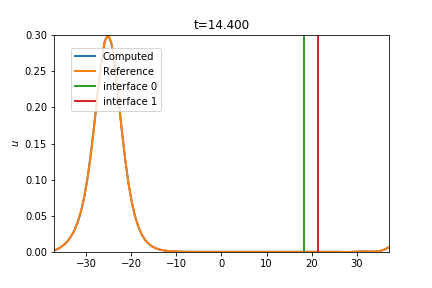
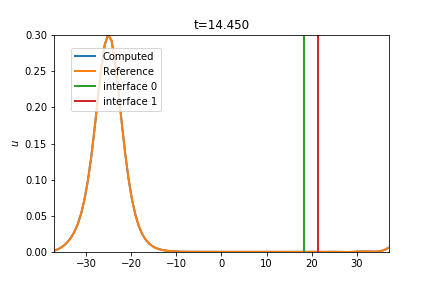
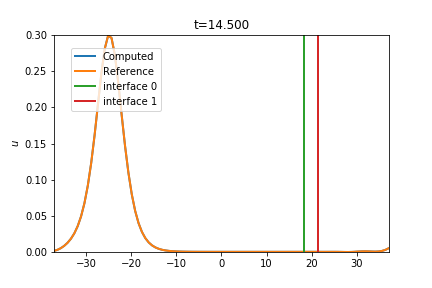
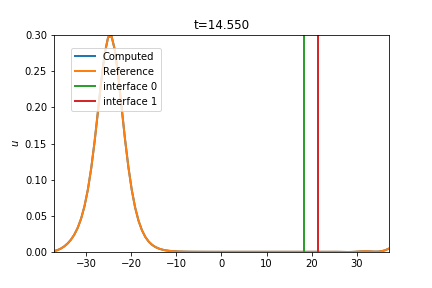
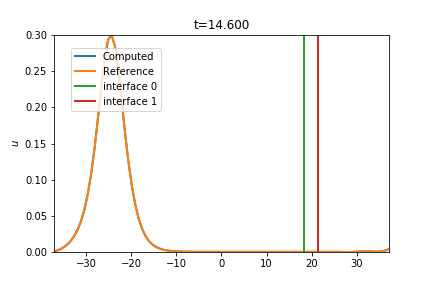
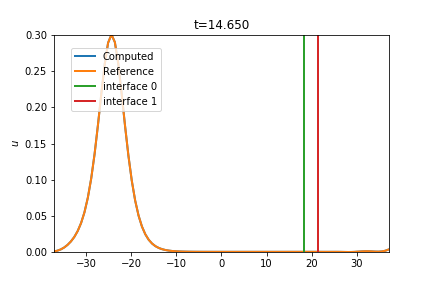
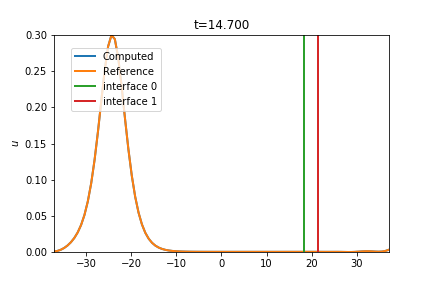
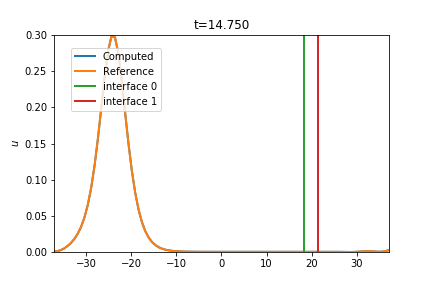
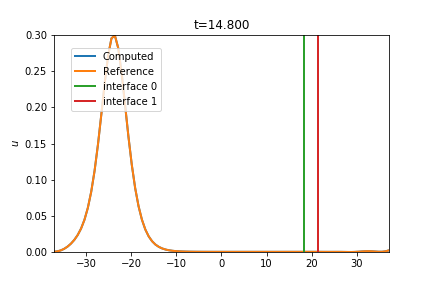
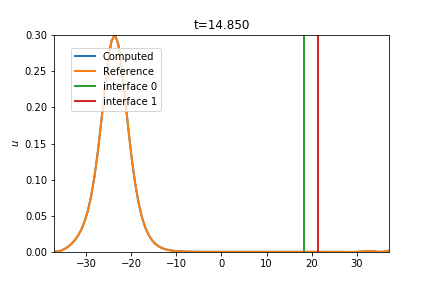
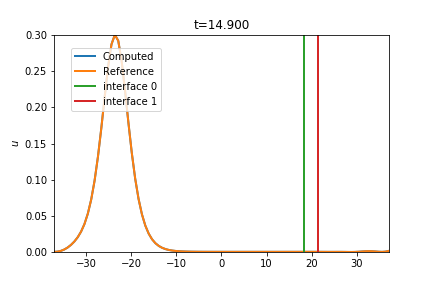
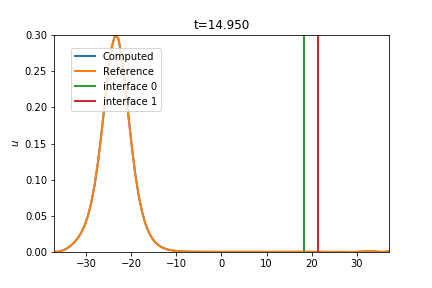

In [17]:
lb = ["Computed","Reference"]
# save = None
save = "./u_DDM.mp4"
gF.plotAnimationNSolutions(2,x,np.array([uall,uallref]),tall,xmin+dx,xmax-dx,umin,umax,lb,
                           ylabel=r'$u$',location=(0.05,0.65), savePath=save, ddm=ddm)